In [289]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import ToTensor
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from scipy import stats

# Model Definition

## Matryoshka Embedding Model

In [290]:

class MRLModel(nn.Module):
    def __init__(self, nesting_list=[2, 4, 8, 16, 32]):
        super().__init__()
        self.nesting_list = sorted(nesting_list)
        
        # Feature extractor
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc_embed = nn.Linear(64 * 5 * 5, 32) 
        
        # Shared classifier (MRL-E variant)
        self.classifier = nn.Linear(32, 10)

    def predict(self,x,dim=None):
        if dim not in self.nesting_list:
            raise Exception(f"Invalid Dimension Truncation: {dim}, use one of these {self.nesting_list}")
        
        z = self.embed(x)
        z_m = z[:, :dim]  # First m dimensions
        W_m = self.classifier.weight[:, :dim]  # Slice classifier weights
        logit = z_m @ W_m.T + self.classifier.bias  # Logits for current m

        return logit

    def embed(self, x, dim=None):
        if not dim:
           dim = max(self.nesting_list)
        
        if dim not in self.nesting_list:
            raise Exception(f"Invalid Dimension Truncation: {dim}, use one of these {self.nesting_list}")
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        
        # Generate embedding
        z = self.fc_embed(x)

        return z[:, :dim]
    
    def forward(self, x):
        # Forward pass through conv layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        
        # Generate embedding
        z = self.fc_embed(x) 
        
        logits = []
        for m in self.nesting_list:
            z_m = z[:, :m]  # First m dimensions
            W_m = self.classifier.weight[:, :m]  # Slice classifier weights
            logit = z_m @ W_m.T + self.classifier.bias  # Logits for current m
            logits.append(logit)
        
        return logits  # List of logits for all nesting sizes

In [291]:
def mr_loss(logits_list, targets):
    loss = 0.0
    for logits in logits_list:
        loss += F.cross_entropy(logits, targets)  # Sum losses for all nesting sizes
    return loss

In [292]:

# Load MNIST data
train_data = MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="data", train=False, download=True, transform=ToTensor())


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

In [293]:

def train_mrlmodel(train_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Initialize model and optimizer
    model = MRLModel(nesting_list=[2, 4, 8, 16, 32]).to(device)
    optimizer = Adam(model.parameters(), lr=1e-3)
    # model.to("cuda")
    # Training
    for epoch in range(10):
        model.train()
        for batch in tqdm.tqdm(train_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits_list = model(x)
            loss = mr_loss(logits_list, y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return model

In [294]:
model_mrl =train_mrlmodel(train_loader)

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.43it/s]


Epoch 1, Loss: 1.5148


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.48it/s]


Epoch 2, Loss: 1.2733


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.89it/s]


Epoch 3, Loss: 1.0058


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.90it/s]


Epoch 4, Loss: 0.8803


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.64it/s]


Epoch 5, Loss: 0.6307


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.36it/s]


Epoch 6, Loss: 0.6128


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.93it/s]


Epoch 7, Loss: 0.7000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 93.96it/s]


Epoch 8, Loss: 0.7485


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 91.89it/s]


Epoch 9, Loss: 0.5600


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.10it/s]

Epoch 10, Loss: 0.4851


In [295]:
def evaluate_mrl(model, test_loader):
    model.eval()
    accuracies = {}
    # Evaluate
    nesting_list = [2, 4, 8, 16, 32]
    with torch.no_grad():
        for m in nesting_list:
            correct, total = 0, 0
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                # Extract embedding and compute logits for current m
                logits=model.predict(x,dim=m)
                pred = logits.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
            acc = 100 * correct / total
            accuracies[m] = acc
            print(f"Accuracy at {m}D: {acc:.2f}%")
    return accuracies


accuracies = evaluate(model_mrl, test_loader)

Accuracy at 2D: 87.52%
Accuracy at 4D: 97.70%
Accuracy at 8D: 98.87%
Accuracy at 16D: 98.77%
Accuracy at 32D: 98.66%


In [296]:
accuracies

{2: 87.52, 4: 97.7, 8: 98.87, 16: 98.77, 32: 98.66}

## Non Matriouyshka Model

In [297]:
class ClassicCNN(nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.nesting_list = sorted(nesting_list)
        
        # Feature extractor
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc_embed = nn.Linear(64 * 5 * 5, dim) 
        
        # Shared classifier (MRL-E variant)
        self.classifier = nn.Linear(dim, 10)

    def embed(self, x, dim=None):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        
        # Generate embedding
        z = self.fc_embed(x)

        return z
    
    def predict(self,x,dim=None):
        return self.forward(x)
    
    def forward(self,x):
        z = self.embed(x)
        logit = self.classifier(z)
        return logit



In [166]:


def train_classic_model(train_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_classic = ClassicCNN(dim=2).to(device)
    optimizer = Adam(model_classic.parameters(), lr=1e-3)
    
    for epoch in range(10):
        model_classic.train()
        for batch in tqdm.tqdm(train_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logit = model_classic(x)
            loss = F.cross_entropy(logit, y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return model_classic

In [162]:
classic_model = train_classic_model(train_loader)

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.32it/s]


Epoch 1, Loss: 0.7787


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.63it/s]


Epoch 2, Loss: 0.6140


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.34it/s]


Epoch 3, Loss: 0.6579


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.30it/s]


Epoch 4, Loss: 0.4953


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.67it/s]


Epoch 5, Loss: 0.4313


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.44it/s]


Epoch 6, Loss: 0.4791


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.60it/s]


Epoch 7, Loss: 0.6145


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.48it/s]


Epoch 8, Loss: 0.2678


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.64it/s]


Epoch 9, Loss: 0.5872


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.90it/s]

Epoch 10, Loss: 0.3252


In [163]:
def evaluate_cnn(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            # Extract embedding and compute logits for current m
            logit= model.forward(x)
            pred = logit.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        acc = 100 * correct / total

    print(f"Accuracy: {acc:.2f}%")
    return acc

accuracies = evaluate_cnn(classic_model, test_loader)

Accuracy: 90.57%


# Comparing Model Results

In [167]:
N_EXPERIMENTS = 50
experiment_classic_acc = []
experiment_mrl_acc = []
DIM_FOR_EXPERIMENT = 2
for experiment in range(N_EXPERIMENTS):
    # Train CNN
    classic_model=train_classic_model(train_loader)
    
    # Train MRL CNN
    mrlmodel=train_mrlmodel(train_loader)

    # Evaluate CNN
    acc = evaluate_cnn(classic_model,test_loader)
    experiment_classic_acc.append(acc)

    # Evaluate MRL
    accuracies =evaluate(mrlmodel,test_loader)
    experiment_mrl_acc.append(accuracies[DIM_FOR_EXPERIMENT])

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.02it/s]


Epoch 1, Loss: 0.8266


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.84it/s]


Epoch 2, Loss: 0.6758


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.10it/s]


Epoch 3, Loss: 0.5225


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.37it/s]


Epoch 4, Loss: 0.4294


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.95it/s]


Epoch 5, Loss: 0.3932


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.68it/s]


Epoch 6, Loss: 0.4830


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.03it/s]


Epoch 7, Loss: 0.5396


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.23it/s]


Epoch 8, Loss: 0.4027


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.53it/s]


Epoch 9, Loss: 0.1910


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.43it/s]


Epoch 10, Loss: 0.2391


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.63it/s]


Epoch 1, Loss: 1.5419


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.70it/s]


Epoch 2, Loss: 1.5410


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.42it/s]


Epoch 3, Loss: 1.7188


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.64it/s]


Epoch 4, Loss: 0.6543


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.61it/s]


Epoch 5, Loss: 1.4569


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.72it/s]


Epoch 6, Loss: 0.6015


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.28it/s]


Epoch 7, Loss: 0.5980


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.46it/s]


Epoch 8, Loss: 0.5913


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.56it/s]


Epoch 9, Loss: 0.4206


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.14it/s]


Epoch 10, Loss: 0.5909
Accuracy: 92.58%
Accuracy at 2D: 88.83%
Accuracy at 4D: 97.72%
Accuracy at 8D: 98.50%
Accuracy at 16D: 98.90%
Accuracy at 32D: 98.88%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.48it/s]


Epoch 1, Loss: 0.9085


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.00it/s]


Epoch 2, Loss: 0.5252


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.94it/s]


Epoch 3, Loss: 0.6734


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.48it/s]


Epoch 4, Loss: 0.3945


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.84it/s]


Epoch 5, Loss: 0.4172


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.64it/s]


Epoch 6, Loss: 0.3418


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.61it/s]


Epoch 7, Loss: 0.3580


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.94it/s]


Epoch 8, Loss: 0.3461


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.32it/s]


Epoch 9, Loss: 0.3504


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.54it/s]


Epoch 10, Loss: 0.1947


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.05it/s]


Epoch 1, Loss: 1.5041


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.18it/s]


Epoch 2, Loss: 1.2669


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.13it/s]


Epoch 3, Loss: 0.7989


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.42it/s]


Epoch 4, Loss: 1.4121


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.38it/s]


Epoch 5, Loss: 0.8632


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.62it/s]


Epoch 6, Loss: 0.5181


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.34it/s]


Epoch 7, Loss: 0.9580


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.58it/s]


Epoch 8, Loss: 0.6410


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.83it/s]


Epoch 9, Loss: 0.3383


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.52it/s]


Epoch 10, Loss: 0.5380
Accuracy: 91.94%
Accuracy at 2D: 88.03%
Accuracy at 4D: 97.34%
Accuracy at 8D: 98.50%
Accuracy at 16D: 98.52%
Accuracy at 32D: 98.45%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.16it/s]


Epoch 1, Loss: 0.6885


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.37it/s]


Epoch 2, Loss: 0.7137


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.83it/s]


Epoch 3, Loss: 0.7850


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.75it/s]


Epoch 4, Loss: 0.4358


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.71it/s]


Epoch 5, Loss: 0.4220


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.11it/s]


Epoch 6, Loss: 0.3516


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.34it/s]


Epoch 7, Loss: 0.4204


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.08it/s]


Epoch 8, Loss: 0.4113


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.58it/s]


Epoch 9, Loss: 0.3183


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.52it/s]


Epoch 10, Loss: 0.3539


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.60it/s]


Epoch 1, Loss: 1.3330


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.48it/s]


Epoch 2, Loss: 1.2926


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.25it/s]


Epoch 3, Loss: 1.4388


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.07it/s]


Epoch 4, Loss: 0.9078


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.29it/s]


Epoch 5, Loss: 0.5618


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.30it/s]


Epoch 6, Loss: 0.5788


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.60it/s]


Epoch 7, Loss: 0.5145


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.95it/s]


Epoch 8, Loss: 0.3775


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.87it/s]


Epoch 9, Loss: 0.6539


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.50it/s]


Epoch 10, Loss: 0.4765
Accuracy: 90.24%
Accuracy at 2D: 89.49%
Accuracy at 4D: 97.41%
Accuracy at 8D: 98.72%
Accuracy at 16D: 98.88%
Accuracy at 32D: 98.94%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.37it/s]


Epoch 1, Loss: 1.0132


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.87it/s]


Epoch 2, Loss: 0.5425


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.53it/s]


Epoch 3, Loss: 0.7336


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.00it/s]


Epoch 4, Loss: 0.4038


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.73it/s]


Epoch 5, Loss: 0.3413


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.63it/s]


Epoch 6, Loss: 0.5588


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.50it/s]


Epoch 7, Loss: 0.4220


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.66it/s]


Epoch 8, Loss: 0.3169


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.30it/s]


Epoch 9, Loss: 0.3274


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.48it/s]


Epoch 10, Loss: 0.4042


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.16it/s]


Epoch 1, Loss: 1.7117


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.17it/s]


Epoch 2, Loss: 1.1773


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.59it/s]


Epoch 3, Loss: 1.0085


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.98it/s]


Epoch 4, Loss: 1.4852


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.20it/s]


Epoch 5, Loss: 0.6277


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.70it/s]


Epoch 6, Loss: 0.5748


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.21it/s]


Epoch 7, Loss: 0.5307


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.39it/s]


Epoch 8, Loss: 0.6797


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.89it/s]


Epoch 9, Loss: 0.6181


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.61it/s]


Epoch 10, Loss: 0.5210
Accuracy: 86.77%
Accuracy at 2D: 89.00%
Accuracy at 4D: 97.40%
Accuracy at 8D: 98.86%
Accuracy at 16D: 99.14%
Accuracy at 32D: 99.01%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.40it/s]


Epoch 1, Loss: 0.9201


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.81it/s]


Epoch 2, Loss: 0.6796


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.33it/s]


Epoch 3, Loss: 0.6673


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.11it/s]


Epoch 4, Loss: 0.5453


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.15it/s]


Epoch 5, Loss: 0.4463


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.50it/s]


Epoch 6, Loss: 0.3507


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.86it/s]


Epoch 7, Loss: 0.5242


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.61it/s]


Epoch 8, Loss: 0.4821


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.53it/s]


Epoch 9, Loss: 0.2894


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.55it/s]


Epoch 10, Loss: 0.3281


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.55it/s]


Epoch 1, Loss: 1.5620


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.28it/s]


Epoch 2, Loss: 1.7567


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.42it/s]


Epoch 3, Loss: 1.1982


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.50it/s]


Epoch 4, Loss: 0.7042


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.03it/s]


Epoch 5, Loss: 0.9575


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.82it/s]


Epoch 6, Loss: 1.1075


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.01it/s]


Epoch 7, Loss: 0.5396


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.76it/s]


Epoch 8, Loss: 0.6336


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.49it/s]


Epoch 9, Loss: 0.5284


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.23it/s]


Epoch 10, Loss: 0.5800
Accuracy: 92.21%
Accuracy at 2D: 89.44%
Accuracy at 4D: 97.36%
Accuracy at 8D: 98.57%
Accuracy at 16D: 98.88%
Accuracy at 32D: 98.90%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.90it/s]


Epoch 1, Loss: 1.0136


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.63it/s]


Epoch 2, Loss: 0.8924


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.02it/s]


Epoch 3, Loss: 0.4818


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.85it/s]


Epoch 4, Loss: 0.3040


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.58it/s]


Epoch 5, Loss: 0.2538


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.39it/s]


Epoch 6, Loss: 0.3364


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.26it/s]


Epoch 7, Loss: 0.3493


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.86it/s]


Epoch 8, Loss: 0.6541


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.07it/s]


Epoch 9, Loss: 0.2668


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.36it/s]


Epoch 10, Loss: 0.1976


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.36it/s]


Epoch 1, Loss: 2.0030


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.69it/s]


Epoch 2, Loss: 1.3106


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.74it/s]


Epoch 3, Loss: 0.9522


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.72it/s]


Epoch 4, Loss: 0.7346


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.66it/s]


Epoch 5, Loss: 0.4130


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.09it/s]


Epoch 6, Loss: 0.8089


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.62it/s]


Epoch 7, Loss: 0.4812


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 97.76it/s]


Epoch 8, Loss: 0.4454


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 96.20it/s]


Epoch 9, Loss: 0.6035


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 91.84it/s]


Epoch 10, Loss: 0.4743
Accuracy: 90.35%
Accuracy at 2D: 89.82%
Accuracy at 4D: 97.94%
Accuracy at 8D: 98.68%
Accuracy at 16D: 98.82%
Accuracy at 32D: 98.82%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.52it/s]


Epoch 1, Loss: 0.8075


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.40it/s]


Epoch 2, Loss: 0.5749


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.65it/s]


Epoch 3, Loss: 0.4168


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.25it/s]


Epoch 4, Loss: 0.4321


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.91it/s]


Epoch 5, Loss: 0.2399


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.57it/s]


Epoch 6, Loss: 0.2917


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.97it/s]


Epoch 7, Loss: 0.2727


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.82it/s]


Epoch 8, Loss: 0.4060


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.49it/s]


Epoch 9, Loss: 0.2473


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.70it/s]


Epoch 10, Loss: 0.1967


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.92it/s]


Epoch 1, Loss: 1.1311


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.21it/s]


Epoch 2, Loss: 1.1770


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.43it/s]


Epoch 3, Loss: 1.1290


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.30it/s]


Epoch 4, Loss: 0.7947


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.49it/s]


Epoch 5, Loss: 0.9258


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.49it/s]


Epoch 6, Loss: 0.6477


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.41it/s]


Epoch 7, Loss: 0.4540


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.28it/s]


Epoch 8, Loss: 0.6203


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.78it/s]


Epoch 9, Loss: 0.4084


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.73it/s]


Epoch 10, Loss: 0.8159
Accuracy: 92.16%
Accuracy at 2D: 88.86%
Accuracy at 4D: 97.40%
Accuracy at 8D: 98.75%
Accuracy at 16D: 98.86%
Accuracy at 32D: 98.86%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.78it/s]


Epoch 1, Loss: 0.9518


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.16it/s]


Epoch 2, Loss: 0.6290


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.38it/s]


Epoch 3, Loss: 0.3932


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.94it/s]


Epoch 4, Loss: 0.3399


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.65it/s]


Epoch 5, Loss: 0.5848


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.96it/s]


Epoch 6, Loss: 0.4663


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.15it/s]


Epoch 7, Loss: 0.3463


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.19it/s]


Epoch 8, Loss: 0.4093


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.95it/s]


Epoch 9, Loss: 0.4252


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.65it/s]


Epoch 10, Loss: 0.3490


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.38it/s]


Epoch 1, Loss: 1.5602


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.12it/s]


Epoch 2, Loss: 1.2680


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.01it/s]


Epoch 3, Loss: 1.4061


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.62it/s]


Epoch 4, Loss: 0.8368


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.33it/s]


Epoch 5, Loss: 0.8228


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.84it/s]


Epoch 6, Loss: 0.6733


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.62it/s]


Epoch 7, Loss: 0.6995


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.87it/s]


Epoch 8, Loss: 0.6201


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.70it/s]


Epoch 9, Loss: 0.5127


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.12it/s]


Epoch 10, Loss: 0.3734
Accuracy: 91.00%
Accuracy at 2D: 88.17%
Accuracy at 4D: 97.84%
Accuracy at 8D: 98.87%
Accuracy at 16D: 99.04%
Accuracy at 32D: 99.03%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.13it/s]


Epoch 1, Loss: 0.8082


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.78it/s]


Epoch 2, Loss: 0.8116


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.61it/s]


Epoch 3, Loss: 0.6534


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.62it/s]


Epoch 4, Loss: 0.4481


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.00it/s]


Epoch 5, Loss: 0.4812


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.40it/s]


Epoch 6, Loss: 0.3629


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.20it/s]


Epoch 7, Loss: 0.3280


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.28it/s]


Epoch 8, Loss: 0.5401


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.34it/s]


Epoch 9, Loss: 0.3090


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.23it/s]


Epoch 10, Loss: 0.2281


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.54it/s]


Epoch 1, Loss: 1.8774


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.72it/s]


Epoch 2, Loss: 1.2469


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.86it/s]


Epoch 3, Loss: 0.7893


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.35it/s]


Epoch 4, Loss: 0.9071


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.78it/s]


Epoch 5, Loss: 0.7433


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.41it/s]


Epoch 6, Loss: 0.7155


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.99it/s]


Epoch 7, Loss: 0.7649


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.29it/s]


Epoch 8, Loss: 0.4740


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.38it/s]


Epoch 9, Loss: 0.4911


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 97.71it/s]


Epoch 10, Loss: 0.4971
Accuracy: 91.72%
Accuracy at 2D: 89.17%
Accuracy at 4D: 97.48%
Accuracy at 8D: 98.75%
Accuracy at 16D: 98.95%
Accuracy at 32D: 98.91%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.08it/s]


Epoch 1, Loss: 0.6268


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.62it/s]


Epoch 2, Loss: 0.7355


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.09it/s]


Epoch 3, Loss: 0.4425


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.82it/s]


Epoch 4, Loss: 0.3439


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.74it/s]


Epoch 5, Loss: 0.2802


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.14it/s]


Epoch 6, Loss: 0.6135


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.43it/s]


Epoch 7, Loss: 0.2951


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.34it/s]


Epoch 8, Loss: 0.3451


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.77it/s]


Epoch 9, Loss: 0.3002


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.69it/s]


Epoch 10, Loss: 0.4355


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.81it/s]


Epoch 1, Loss: 1.2554


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.07it/s]


Epoch 2, Loss: 1.3191


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.62it/s]


Epoch 3, Loss: 1.6707


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.80it/s]


Epoch 4, Loss: 0.8336


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.22it/s]


Epoch 5, Loss: 1.0328


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.75it/s]


Epoch 6, Loss: 0.5117


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.83it/s]


Epoch 7, Loss: 0.9923


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.95it/s]


Epoch 8, Loss: 0.5658


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.54it/s]


Epoch 9, Loss: 0.8162


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.44it/s]


Epoch 10, Loss: 0.5135
Accuracy: 91.33%
Accuracy at 2D: 90.47%
Accuracy at 4D: 97.22%
Accuracy at 8D: 98.81%
Accuracy at 16D: 98.94%
Accuracy at 32D: 98.84%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.97it/s]


Epoch 1, Loss: 0.8046


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.83it/s]


Epoch 2, Loss: 0.5175


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.84it/s]


Epoch 3, Loss: 0.5004


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.03it/s]


Epoch 4, Loss: 0.5121


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.64it/s]


Epoch 5, Loss: 0.3102


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.22it/s]


Epoch 6, Loss: 0.3016


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.77it/s]


Epoch 7, Loss: 0.2782


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.69it/s]


Epoch 8, Loss: 0.2500


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.27it/s]


Epoch 9, Loss: 0.6101


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.77it/s]


Epoch 10, Loss: 0.5177


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.93it/s]


Epoch 1, Loss: 1.6535


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.73it/s]


Epoch 2, Loss: 1.7225


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.03it/s]


Epoch 3, Loss: 1.2893


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.07it/s]


Epoch 4, Loss: 1.3988


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.64it/s]


Epoch 5, Loss: 0.4575


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.91it/s]


Epoch 6, Loss: 0.6175


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.54it/s]


Epoch 7, Loss: 0.8226


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.64it/s]


Epoch 8, Loss: 0.9741


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 96.20it/s]


Epoch 9, Loss: 0.5299


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.09it/s]


Epoch 10, Loss: 0.6075
Accuracy: 91.08%
Accuracy at 2D: 91.12%
Accuracy at 4D: 97.77%
Accuracy at 8D: 98.72%
Accuracy at 16D: 98.76%
Accuracy at 32D: 98.78%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.43it/s]


Epoch 1, Loss: 0.9825


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.30it/s]


Epoch 2, Loss: 0.5410


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.26it/s]


Epoch 3, Loss: 0.4116


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.24it/s]


Epoch 4, Loss: 0.4235


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.97it/s]


Epoch 5, Loss: 0.2467


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.11it/s]


Epoch 6, Loss: 0.2884


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.67it/s]


Epoch 7, Loss: 0.4095


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.59it/s]


Epoch 8, Loss: 0.4249


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.88it/s]


Epoch 9, Loss: 0.2066


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.84it/s]


Epoch 10, Loss: 0.3534


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.45it/s]


Epoch 1, Loss: 1.6140


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.87it/s]


Epoch 2, Loss: 1.3493


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 98.13it/s]


Epoch 3, Loss: 0.6480


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.21it/s]


Epoch 4, Loss: 0.6996


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.84it/s]


Epoch 5, Loss: 0.7263


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.55it/s]


Epoch 6, Loss: 0.8027


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.94it/s]


Epoch 7, Loss: 1.5162


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.43it/s]


Epoch 8, Loss: 0.5103


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 92.56it/s]


Epoch 9, Loss: 0.7286


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 94.95it/s]


Epoch 10, Loss: 0.4976
Accuracy: 92.86%
Accuracy at 2D: 88.16%
Accuracy at 4D: 97.58%
Accuracy at 8D: 98.61%
Accuracy at 16D: 98.74%
Accuracy at 32D: 98.74%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.15it/s]


Epoch 1, Loss: 0.8936


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.18it/s]


Epoch 2, Loss: 0.5800


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.57it/s]


Epoch 3, Loss: 0.6446


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.36it/s]


Epoch 4, Loss: 0.4921


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.50it/s]


Epoch 5, Loss: 0.4739


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.34it/s]


Epoch 6, Loss: 0.4672


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.23it/s]


Epoch 7, Loss: 0.3876


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.35it/s]


Epoch 8, Loss: 0.4410


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.16it/s]


Epoch 9, Loss: 0.2921


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.04it/s]


Epoch 10, Loss: 0.2469


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.22it/s]


Epoch 1, Loss: 1.5440


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.85it/s]


Epoch 2, Loss: 1.1876


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 97.92it/s]


Epoch 3, Loss: 0.8991


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.59it/s]


Epoch 4, Loss: 1.2552


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.27it/s]


Epoch 5, Loss: 0.8898


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.85it/s]


Epoch 6, Loss: 0.6782


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 94.76it/s]


Epoch 7, Loss: 0.7226


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.52it/s]


Epoch 8, Loss: 0.5417


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.59it/s]


Epoch 9, Loss: 0.6064


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.63it/s]


Epoch 10, Loss: 0.6177
Accuracy: 90.68%
Accuracy at 2D: 90.17%
Accuracy at 4D: 97.53%
Accuracy at 8D: 98.75%
Accuracy at 16D: 98.95%
Accuracy at 32D: 98.94%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.28it/s]


Epoch 1, Loss: 1.0403


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.26it/s]


Epoch 2, Loss: 0.6816


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.03it/s]


Epoch 3, Loss: 0.6141


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.86it/s]


Epoch 4, Loss: 0.5292


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.20it/s]


Epoch 5, Loss: 0.4026


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.90it/s]


Epoch 6, Loss: 0.4475


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.04it/s]


Epoch 7, Loss: 0.5078


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.54it/s]


Epoch 8, Loss: 0.4029


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.52it/s]


Epoch 9, Loss: 0.4097


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.07it/s]


Epoch 10, Loss: 0.2613


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.15it/s]


Epoch 1, Loss: 1.9628


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.37it/s]


Epoch 2, Loss: 1.2997


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.79it/s]


Epoch 3, Loss: 1.0754


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.94it/s]


Epoch 4, Loss: 0.6310


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.68it/s]


Epoch 5, Loss: 0.6636


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 96.18it/s]


Epoch 6, Loss: 0.8879


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.07it/s]


Epoch 7, Loss: 0.7785


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.91it/s]


Epoch 8, Loss: 0.3613


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.11it/s]


Epoch 9, Loss: 0.6381


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.34it/s]


Epoch 10, Loss: 0.4298
Accuracy: 90.25%
Accuracy at 2D: 89.05%
Accuracy at 4D: 97.88%
Accuracy at 8D: 98.81%
Accuracy at 16D: 98.88%
Accuracy at 32D: 98.86%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.24it/s]


Epoch 1, Loss: 0.8941


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.45it/s]


Epoch 2, Loss: 0.5449


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.92it/s]


Epoch 3, Loss: 0.6972


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.10it/s]


Epoch 4, Loss: 0.3252


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.34it/s]


Epoch 5, Loss: 0.6311


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.46it/s]


Epoch 6, Loss: 0.5819


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.68it/s]


Epoch 7, Loss: 0.2639


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.54it/s]


Epoch 8, Loss: 0.3354


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.44it/s]


Epoch 9, Loss: 0.2842


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.35it/s]


Epoch 10, Loss: 0.3701


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.58it/s]


Epoch 1, Loss: 1.4176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.95it/s]


Epoch 2, Loss: 1.4227


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.93it/s]


Epoch 3, Loss: 1.3613


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.89it/s]


Epoch 4, Loss: 1.2333


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.78it/s]


Epoch 5, Loss: 0.7496


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.57it/s]


Epoch 6, Loss: 0.5614


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.78it/s]


Epoch 7, Loss: 0.4091


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.29it/s]


Epoch 8, Loss: 0.6861


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.31it/s]


Epoch 9, Loss: 1.0133


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.40it/s]


Epoch 10, Loss: 0.3354
Accuracy: 92.17%
Accuracy at 2D: 88.84%
Accuracy at 4D: 97.51%
Accuracy at 8D: 98.76%
Accuracy at 16D: 98.93%
Accuracy at 32D: 98.99%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.20it/s]


Epoch 1, Loss: 0.9324


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.46it/s]


Epoch 2, Loss: 0.6169


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.11it/s]


Epoch 3, Loss: 0.6628


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.84it/s]


Epoch 4, Loss: 0.5940


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.66it/s]


Epoch 5, Loss: 0.6107


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.12it/s]


Epoch 6, Loss: 0.5565


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.76it/s]


Epoch 7, Loss: 0.3090


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.98it/s]


Epoch 8, Loss: 0.3331


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.48it/s]


Epoch 9, Loss: 0.5351


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.00it/s]


Epoch 10, Loss: 0.3662


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.22it/s]


Epoch 1, Loss: 1.4109


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.59it/s]


Epoch 2, Loss: 1.0745


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.04it/s]


Epoch 3, Loss: 0.6907


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.33it/s]


Epoch 4, Loss: 0.5433


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.16it/s]


Epoch 5, Loss: 0.5814


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.62it/s]


Epoch 6, Loss: 0.9585


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.40it/s]


Epoch 7, Loss: 0.7321


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.97it/s]


Epoch 8, Loss: 0.4720


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 92.83it/s]


Epoch 9, Loss: 0.6987


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 98.46it/s]


Epoch 10, Loss: 0.4371
Accuracy: 88.84%
Accuracy at 2D: 89.17%
Accuracy at 4D: 97.49%
Accuracy at 8D: 98.67%
Accuracy at 16D: 98.66%
Accuracy at 32D: 98.61%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.38it/s]


Epoch 1, Loss: 0.7578


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.86it/s]


Epoch 2, Loss: 0.5397


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.75it/s]


Epoch 3, Loss: 0.4984


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.94it/s]


Epoch 4, Loss: 0.3795


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.07it/s]


Epoch 5, Loss: 0.3973


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.44it/s]


Epoch 6, Loss: 0.4011


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.18it/s]


Epoch 7, Loss: 0.4920


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.02it/s]


Epoch 8, Loss: 0.6592


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.88it/s]


Epoch 9, Loss: 0.2674


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.12it/s]


Epoch 10, Loss: 0.3967


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.97it/s]


Epoch 1, Loss: 1.6265


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.18it/s]


Epoch 2, Loss: 1.1933


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 95.77it/s]


Epoch 3, Loss: 1.0041


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.61it/s]


Epoch 4, Loss: 1.1306


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.91it/s]


Epoch 5, Loss: 1.0454


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.56it/s]


Epoch 6, Loss: 1.0669


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 93.85it/s]


Epoch 7, Loss: 0.7323


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.00it/s]


Epoch 8, Loss: 0.8558


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.73it/s]


Epoch 9, Loss: 0.7719


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.81it/s]


Epoch 10, Loss: 0.7845
Accuracy: 91.18%
Accuracy at 2D: 88.79%
Accuracy at 4D: 97.43%
Accuracy at 8D: 98.65%
Accuracy at 16D: 98.84%
Accuracy at 32D: 98.89%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.96it/s]


Epoch 1, Loss: 0.7977


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.70it/s]


Epoch 2, Loss: 0.6184


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.13it/s]


Epoch 3, Loss: 0.7755


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.82it/s]


Epoch 4, Loss: 0.5549


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.34it/s]


Epoch 5, Loss: 0.4528


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.30it/s]


Epoch 6, Loss: 0.3383


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.51it/s]


Epoch 7, Loss: 0.2865


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.35it/s]


Epoch 8, Loss: 0.3608


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.92it/s]


Epoch 9, Loss: 0.3212


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.34it/s]


Epoch 10, Loss: 0.3904


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.34it/s]


Epoch 1, Loss: 1.4798


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.22it/s]


Epoch 2, Loss: 1.0712


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.19it/s]


Epoch 3, Loss: 1.4449


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.27it/s]


Epoch 4, Loss: 0.9710


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.73it/s]


Epoch 5, Loss: 1.7221


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.53it/s]


Epoch 6, Loss: 0.7964


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.34it/s]


Epoch 7, Loss: 0.6960


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.94it/s]


Epoch 8, Loss: 0.4563


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.06it/s]


Epoch 9, Loss: 0.8893


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.72it/s]


Epoch 10, Loss: 0.3615
Accuracy: 90.85%
Accuracy at 2D: 90.20%
Accuracy at 4D: 97.98%
Accuracy at 8D: 98.85%
Accuracy at 16D: 99.07%
Accuracy at 32D: 98.97%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.55it/s]


Epoch 1, Loss: 0.7961


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.96it/s]


Epoch 2, Loss: 0.4809


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.96it/s]


Epoch 3, Loss: 0.4154


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.92it/s]


Epoch 4, Loss: 0.4569


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.25it/s]


Epoch 5, Loss: 0.3649


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.70it/s]


Epoch 6, Loss: 0.4087


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.82it/s]


Epoch 7, Loss: 0.4331


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.53it/s]


Epoch 8, Loss: 0.4150


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.66it/s]


Epoch 9, Loss: 0.2024


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.44it/s]


Epoch 10, Loss: 0.2585


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 98.44it/s]


Epoch 1, Loss: 2.3750


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.16it/s]


Epoch 2, Loss: 1.6607


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.18it/s]


Epoch 3, Loss: 1.2683


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.27it/s]


Epoch 4, Loss: 0.7287


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.44it/s]


Epoch 5, Loss: 1.1609


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.56it/s]


Epoch 6, Loss: 0.7011


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.36it/s]


Epoch 7, Loss: 0.6325


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.82it/s]


Epoch 8, Loss: 0.5449


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.67it/s]


Epoch 9, Loss: 1.1686


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.83it/s]


Epoch 10, Loss: 0.3209
Accuracy: 92.74%
Accuracy at 2D: 90.84%
Accuracy at 4D: 97.51%
Accuracy at 8D: 98.65%
Accuracy at 16D: 98.93%
Accuracy at 32D: 98.94%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.29it/s]


Epoch 1, Loss: 0.7033


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.45it/s]


Epoch 2, Loss: 0.5498


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.73it/s]


Epoch 3, Loss: 0.6492


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.90it/s]


Epoch 4, Loss: 0.3900


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.93it/s]


Epoch 5, Loss: 0.3511


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.59it/s]


Epoch 6, Loss: 0.3847


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.47it/s]


Epoch 7, Loss: 0.3111


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.17it/s]


Epoch 8, Loss: 0.3745


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.91it/s]


Epoch 9, Loss: 0.4393


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.68it/s]


Epoch 10, Loss: 0.2363


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.87it/s]


Epoch 1, Loss: 1.3394


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.42it/s]


Epoch 2, Loss: 0.6039


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.32it/s]


Epoch 3, Loss: 1.0340


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.50it/s]


Epoch 4, Loss: 0.7938


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.78it/s]


Epoch 5, Loss: 1.0204


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.73it/s]


Epoch 6, Loss: 0.7580


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.72it/s]


Epoch 7, Loss: 0.3490


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.50it/s]


Epoch 8, Loss: 0.3573


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.85it/s]


Epoch 9, Loss: 0.3731


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.42it/s]


Epoch 10, Loss: 0.5488
Accuracy: 91.14%
Accuracy at 2D: 90.02%
Accuracy at 4D: 97.85%
Accuracy at 8D: 98.71%
Accuracy at 16D: 98.76%
Accuracy at 32D: 98.59%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.76it/s]


Epoch 1, Loss: 0.9608


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.59it/s]


Epoch 2, Loss: 0.5999


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.35it/s]


Epoch 3, Loss: 0.5173


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.02it/s]


Epoch 4, Loss: 0.7618


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.50it/s]


Epoch 5, Loss: 0.4063


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.72it/s]


Epoch 6, Loss: 0.3378


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.08it/s]


Epoch 7, Loss: 0.3850


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.98it/s]


Epoch 8, Loss: 0.4058


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.17it/s]


Epoch 9, Loss: 0.3097


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.12it/s]


Epoch 10, Loss: 0.2540


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.72it/s]


Epoch 1, Loss: 1.7036


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.73it/s]


Epoch 2, Loss: 1.3692


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.23it/s]


Epoch 3, Loss: 0.9055


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.79it/s]


Epoch 4, Loss: 0.7380


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.22it/s]


Epoch 5, Loss: 0.6858


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.89it/s]


Epoch 6, Loss: 0.4503


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.09it/s]


Epoch 7, Loss: 0.5042


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.49it/s]


Epoch 8, Loss: 0.4213


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.88it/s]


Epoch 9, Loss: 0.4416


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.31it/s]


Epoch 10, Loss: 0.3602
Accuracy: 92.67%
Accuracy at 2D: 89.92%
Accuracy at 4D: 97.98%
Accuracy at 8D: 98.89%
Accuracy at 16D: 98.95%
Accuracy at 32D: 98.99%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.44it/s]


Epoch 1, Loss: 0.9607


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.03it/s]


Epoch 2, Loss: 0.5329


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.87it/s]


Epoch 3, Loss: 0.6280


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.58it/s]


Epoch 4, Loss: 0.4155


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.39it/s]


Epoch 5, Loss: 0.5487


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.94it/s]


Epoch 6, Loss: 0.4929


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.76it/s]


Epoch 7, Loss: 0.6454


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.24it/s]


Epoch 8, Loss: 0.4722


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.20it/s]


Epoch 9, Loss: 0.3734


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.58it/s]


Epoch 10, Loss: 0.4100


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.19it/s]


Epoch 1, Loss: 1.6704


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.97it/s]


Epoch 2, Loss: 1.2441


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.64it/s]


Epoch 3, Loss: 1.4960


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.19it/s]


Epoch 4, Loss: 1.4705


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.35it/s]


Epoch 5, Loss: 0.6943


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.87it/s]


Epoch 6, Loss: 1.3240


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.04it/s]


Epoch 7, Loss: 0.9669


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.54it/s]


Epoch 8, Loss: 0.5396


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.25it/s]


Epoch 9, Loss: 0.4144


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.07it/s]


Epoch 10, Loss: 1.0146
Accuracy: 89.90%
Accuracy at 2D: 92.11%
Accuracy at 4D: 97.18%
Accuracy at 8D: 98.89%
Accuracy at 16D: 99.03%
Accuracy at 32D: 98.99%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.61it/s]


Epoch 1, Loss: 0.9069


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.25it/s]


Epoch 2, Loss: 0.5654


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.95it/s]


Epoch 3, Loss: 0.7520


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.40it/s]


Epoch 4, Loss: 0.4624


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.14it/s]


Epoch 5, Loss: 0.3692


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.10it/s]


Epoch 6, Loss: 0.4481


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.51it/s]


Epoch 7, Loss: 0.2753


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.31it/s]


Epoch 8, Loss: 0.2774


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.99it/s]


Epoch 9, Loss: 0.2488


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.35it/s]


Epoch 10, Loss: 0.3749


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.17it/s]


Epoch 1, Loss: 1.8128


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 98.68it/s]


Epoch 2, Loss: 0.7505


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.43it/s]


Epoch 3, Loss: 0.9312


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.68it/s]


Epoch 4, Loss: 1.3473


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.63it/s]


Epoch 5, Loss: 0.4846


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.79it/s]


Epoch 6, Loss: 0.5609


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.19it/s]


Epoch 7, Loss: 0.5608


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.35it/s]


Epoch 8, Loss: 0.4669


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.88it/s]


Epoch 9, Loss: 0.5647


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.12it/s]


Epoch 10, Loss: 0.8198
Accuracy: 90.23%
Accuracy at 2D: 89.24%
Accuracy at 4D: 97.35%
Accuracy at 8D: 98.68%
Accuracy at 16D: 98.92%
Accuracy at 32D: 98.81%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.68it/s]


Epoch 1, Loss: 0.7644


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.69it/s]


Epoch 2, Loss: 0.6574


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.69it/s]


Epoch 3, Loss: 0.5438


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.67it/s]


Epoch 4, Loss: 0.2847


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.21it/s]


Epoch 5, Loss: 0.5660


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.71it/s]


Epoch 6, Loss: 0.4257


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.15it/s]


Epoch 7, Loss: 0.3498


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.86it/s]


Epoch 8, Loss: 0.3808


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.57it/s]


Epoch 9, Loss: 0.2668


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.06it/s]


Epoch 10, Loss: 0.1989


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.07it/s]


Epoch 1, Loss: 1.9067


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 97.14it/s]


Epoch 2, Loss: 1.3947


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.24it/s]


Epoch 3, Loss: 1.0497


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.55it/s]


Epoch 4, Loss: 0.8220


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.50it/s]


Epoch 5, Loss: 0.6231


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.61it/s]


Epoch 6, Loss: 2.1813


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.62it/s]


Epoch 7, Loss: 0.5228


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.75it/s]


Epoch 8, Loss: 0.5900


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.27it/s]


Epoch 9, Loss: 0.2766


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.59it/s]


Epoch 10, Loss: 0.2720
Accuracy: 92.09%
Accuracy at 2D: 91.05%
Accuracy at 4D: 97.72%
Accuracy at 8D: 98.69%
Accuracy at 16D: 98.79%
Accuracy at 32D: 98.76%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.50it/s]


Epoch 1, Loss: 0.8110


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.66it/s]


Epoch 2, Loss: 0.7927


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.95it/s]


Epoch 3, Loss: 0.6825


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.06it/s]


Epoch 4, Loss: 0.5512


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.17it/s]


Epoch 5, Loss: 0.3783


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.69it/s]


Epoch 6, Loss: 0.5578


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.80it/s]


Epoch 7, Loss: 0.2775


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.39it/s]


Epoch 8, Loss: 0.2725


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.73it/s]


Epoch 9, Loss: 0.5758


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.88it/s]


Epoch 10, Loss: 0.1791


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.53it/s]


Epoch 1, Loss: 1.8359


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.31it/s]


Epoch 2, Loss: 0.9694


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.23it/s]


Epoch 3, Loss: 1.2041


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.69it/s]


Epoch 4, Loss: 0.6732


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.68it/s]


Epoch 5, Loss: 1.3611


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.17it/s]


Epoch 6, Loss: 1.0129


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.52it/s]


Epoch 7, Loss: 0.7302


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.38it/s]


Epoch 8, Loss: 0.4593


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.19it/s]


Epoch 9, Loss: 0.6905


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.33it/s]


Epoch 10, Loss: 0.5691
Accuracy: 89.37%
Accuracy at 2D: 90.26%
Accuracy at 4D: 97.13%
Accuracy at 8D: 98.49%
Accuracy at 16D: 98.96%
Accuracy at 32D: 98.97%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.02it/s]


Epoch 1, Loss: 0.7415


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.11it/s]


Epoch 2, Loss: 0.6425


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.66it/s]


Epoch 3, Loss: 0.5682


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.30it/s]


Epoch 4, Loss: 0.4511


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.40it/s]


Epoch 5, Loss: 0.4345


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.55it/s]


Epoch 6, Loss: 0.3695


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.44it/s]


Epoch 7, Loss: 0.4414


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.74it/s]


Epoch 8, Loss: 0.2787


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.61it/s]


Epoch 9, Loss: 0.2760


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.41it/s]


Epoch 10, Loss: 0.3941


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.98it/s]


Epoch 1, Loss: 1.4776


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.10it/s]


Epoch 2, Loss: 1.1832


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.07it/s]


Epoch 3, Loss: 0.8031


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.59it/s]


Epoch 4, Loss: 0.8125


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.04it/s]


Epoch 5, Loss: 0.7166


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.77it/s]


Epoch 6, Loss: 0.5705


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.12it/s]


Epoch 7, Loss: 0.9548


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.89it/s]


Epoch 8, Loss: 0.7498


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.44it/s]


Epoch 9, Loss: 0.8396


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.28it/s]


Epoch 10, Loss: 0.8575
Accuracy: 90.93%
Accuracy at 2D: 88.45%
Accuracy at 4D: 97.24%
Accuracy at 8D: 98.68%
Accuracy at 16D: 98.92%
Accuracy at 32D: 98.95%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.96it/s]


Epoch 1, Loss: 0.7538


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.57it/s]


Epoch 2, Loss: 0.8603


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.50it/s]


Epoch 3, Loss: 0.5789


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.03it/s]


Epoch 4, Loss: 0.5297


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.88it/s]


Epoch 5, Loss: 0.4826


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.02it/s]


Epoch 6, Loss: 0.5264


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.26it/s]


Epoch 7, Loss: 0.3635


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.51it/s]


Epoch 8, Loss: 0.2675


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.60it/s]


Epoch 9, Loss: 0.3025


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.50it/s]


Epoch 10, Loss: 0.3390


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 94.89it/s]


Epoch 1, Loss: 1.4070


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 88.58it/s]


Epoch 2, Loss: 0.9458


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.40it/s]


Epoch 3, Loss: 1.5165


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.91it/s]


Epoch 4, Loss: 0.9235


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.44it/s]


Epoch 5, Loss: 0.5446


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.70it/s]


Epoch 6, Loss: 0.7610


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.37it/s]


Epoch 7, Loss: 0.7123


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.56it/s]


Epoch 8, Loss: 0.5304


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 98.00it/s]


Epoch 9, Loss: 0.6918


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.64it/s]


Epoch 10, Loss: 0.3364
Accuracy: 89.83%
Accuracy at 2D: 90.22%
Accuracy at 4D: 97.47%
Accuracy at 8D: 98.85%
Accuracy at 16D: 99.04%
Accuracy at 32D: 98.95%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.57it/s]


Epoch 1, Loss: 0.7933


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.11it/s]


Epoch 2, Loss: 0.6108


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.99it/s]


Epoch 3, Loss: 0.5598


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.85it/s]


Epoch 4, Loss: 0.3763


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.73it/s]


Epoch 5, Loss: 0.4485


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.83it/s]


Epoch 6, Loss: 0.3177


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.63it/s]


Epoch 7, Loss: 0.3154


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.56it/s]


Epoch 8, Loss: 0.3634


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.28it/s]


Epoch 9, Loss: 0.3025


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.84it/s]


Epoch 10, Loss: 0.2493


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.12it/s]


Epoch 1, Loss: 1.0691


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.56it/s]


Epoch 2, Loss: 1.0867


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.36it/s]


Epoch 3, Loss: 0.9705


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.94it/s]


Epoch 4, Loss: 1.6266


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.82it/s]


Epoch 5, Loss: 1.2237


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.06it/s]


Epoch 6, Loss: 0.7665


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.59it/s]


Epoch 7, Loss: 0.3771


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.54it/s]


Epoch 8, Loss: 0.6023


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.40it/s]


Epoch 9, Loss: 0.4734


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.38it/s]


Epoch 10, Loss: 0.6648
Accuracy: 92.70%
Accuracy at 2D: 89.87%
Accuracy at 4D: 97.24%
Accuracy at 8D: 98.63%
Accuracy at 16D: 98.86%
Accuracy at 32D: 98.79%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.40it/s]


Epoch 1, Loss: 0.7078


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.31it/s]


Epoch 2, Loss: 0.6947


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.22it/s]


Epoch 3, Loss: 0.6603


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.70it/s]


Epoch 4, Loss: 0.4348


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.40it/s]


Epoch 5, Loss: 0.3996


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.08it/s]


Epoch 6, Loss: 0.3476


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.19it/s]


Epoch 7, Loss: 0.3131


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.68it/s]


Epoch 8, Loss: 0.1425


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.25it/s]


Epoch 9, Loss: 0.2255


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.08it/s]


Epoch 10, Loss: 0.1996


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.90it/s]


Epoch 1, Loss: 1.7064


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.72it/s]


Epoch 2, Loss: 1.2040


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.12it/s]


Epoch 3, Loss: 1.2532


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.61it/s]


Epoch 4, Loss: 0.8214


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.55it/s]


Epoch 5, Loss: 0.8030


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.15it/s]


Epoch 6, Loss: 0.8527


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.21it/s]


Epoch 7, Loss: 0.5721


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.99it/s]


Epoch 8, Loss: 0.5105


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.01it/s]


Epoch 9, Loss: 0.5580


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.51it/s]


Epoch 10, Loss: 0.3723
Accuracy: 92.97%
Accuracy at 2D: 89.77%
Accuracy at 4D: 97.58%
Accuracy at 8D: 98.68%
Accuracy at 16D: 98.93%
Accuracy at 32D: 98.88%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.02it/s]


Epoch 1, Loss: 0.9505


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.16it/s]


Epoch 2, Loss: 0.5915


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.00it/s]


Epoch 3, Loss: 0.5007


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.70it/s]


Epoch 4, Loss: 0.5322


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.05it/s]


Epoch 5, Loss: 0.3975


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.52it/s]


Epoch 6, Loss: 0.3360


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.74it/s]


Epoch 7, Loss: 0.2986


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.65it/s]


Epoch 8, Loss: 0.3592


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.78it/s]


Epoch 9, Loss: 0.3315


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.20it/s]


Epoch 10, Loss: 0.3280


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.76it/s]


Epoch 1, Loss: 1.5906


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.76it/s]


Epoch 2, Loss: 0.7828


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.58it/s]


Epoch 3, Loss: 0.6936


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.55it/s]


Epoch 4, Loss: 0.7113


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.06it/s]


Epoch 5, Loss: 0.5968


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.70it/s]


Epoch 6, Loss: 0.9162


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.00it/s]


Epoch 7, Loss: 0.4451


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.63it/s]


Epoch 8, Loss: 0.4468


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.52it/s]


Epoch 9, Loss: 0.5480


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.44it/s]


Epoch 10, Loss: 0.7356
Accuracy: 91.71%
Accuracy at 2D: 88.42%
Accuracy at 4D: 97.36%
Accuracy at 8D: 98.69%
Accuracy at 16D: 98.71%
Accuracy at 32D: 98.61%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.92it/s]


Epoch 1, Loss: 0.7410


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.25it/s]


Epoch 2, Loss: 0.7596


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.49it/s]


Epoch 3, Loss: 0.6873


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.41it/s]


Epoch 4, Loss: 0.3707


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.45it/s]


Epoch 5, Loss: 0.5217


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.86it/s]


Epoch 6, Loss: 0.5564


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.93it/s]


Epoch 7, Loss: 0.3631


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.58it/s]


Epoch 8, Loss: 0.2607


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.04it/s]


Epoch 9, Loss: 0.5176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.11it/s]


Epoch 10, Loss: 0.3199


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 97.15it/s]


Epoch 1, Loss: 1.5824


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.09it/s]


Epoch 2, Loss: 1.4084


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.08it/s]


Epoch 3, Loss: 1.1699


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.57it/s]


Epoch 4, Loss: 0.7628


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.39it/s]


Epoch 5, Loss: 0.8630


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.46it/s]


Epoch 6, Loss: 0.6042


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.28it/s]


Epoch 7, Loss: 0.6770


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 92.79it/s]


Epoch 8, Loss: 0.3764


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 97.86it/s]


Epoch 9, Loss: 0.3724


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.48it/s]


Epoch 10, Loss: 0.3482
Accuracy: 91.42%
Accuracy at 2D: 91.62%
Accuracy at 4D: 97.40%
Accuracy at 8D: 98.80%
Accuracy at 16D: 98.99%
Accuracy at 32D: 98.98%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.31it/s]


Epoch 1, Loss: 0.9226


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.32it/s]


Epoch 2, Loss: 0.9873


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.16it/s]


Epoch 3, Loss: 0.5205


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.68it/s]


Epoch 4, Loss: 0.7626


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.95it/s]


Epoch 5, Loss: 0.4441


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.24it/s]


Epoch 6, Loss: 0.4047


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.80it/s]


Epoch 7, Loss: 0.5273


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.70it/s]


Epoch 8, Loss: 0.3079


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.09it/s]


Epoch 9, Loss: 0.5895


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.79it/s]


Epoch 10, Loss: 0.3670


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.14it/s]


Epoch 1, Loss: 1.5275


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.01it/s]


Epoch 2, Loss: 1.0678


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.86it/s]


Epoch 3, Loss: 1.2466


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.42it/s]


Epoch 4, Loss: 0.9219


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.33it/s]


Epoch 5, Loss: 0.6469


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.80it/s]


Epoch 6, Loss: 0.8595


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.31it/s]


Epoch 7, Loss: 0.6598


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.99it/s]


Epoch 8, Loss: 0.7669


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.98it/s]


Epoch 9, Loss: 1.0957


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.68it/s]


Epoch 10, Loss: 0.3115
Accuracy: 88.97%
Accuracy at 2D: 90.02%
Accuracy at 4D: 97.08%
Accuracy at 8D: 98.64%
Accuracy at 16D: 98.88%
Accuracy at 32D: 98.85%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.05it/s]


Epoch 1, Loss: 0.8167


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.08it/s]


Epoch 2, Loss: 0.6690


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.97it/s]


Epoch 3, Loss: 0.5817


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.80it/s]


Epoch 4, Loss: 0.5003


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.83it/s]


Epoch 5, Loss: 0.3823


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.73it/s]


Epoch 6, Loss: 0.3667


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.89it/s]


Epoch 7, Loss: 0.5734


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.77it/s]


Epoch 8, Loss: 0.2792


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.72it/s]


Epoch 9, Loss: 0.3292


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.83it/s]


Epoch 10, Loss: 0.5685


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.45it/s]


Epoch 1, Loss: 1.3143


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.82it/s]


Epoch 2, Loss: 1.8345


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.53it/s]


Epoch 3, Loss: 1.3850


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.78it/s]


Epoch 4, Loss: 0.7137


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.53it/s]


Epoch 5, Loss: 0.6649


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.17it/s]


Epoch 6, Loss: 0.6589


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.64it/s]


Epoch 7, Loss: 0.8127


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.34it/s]


Epoch 8, Loss: 0.5348


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.61it/s]


Epoch 9, Loss: 0.6047


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.43it/s]


Epoch 10, Loss: 0.6994
Accuracy: 89.73%
Accuracy at 2D: 88.86%
Accuracy at 4D: 97.39%
Accuracy at 8D: 98.69%
Accuracy at 16D: 98.79%
Accuracy at 32D: 98.74%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.54it/s]


Epoch 1, Loss: 0.7836


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.70it/s]


Epoch 2, Loss: 0.7096


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.56it/s]


Epoch 3, Loss: 0.3470


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.45it/s]


Epoch 4, Loss: 0.5157


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.33it/s]


Epoch 5, Loss: 0.2552


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.24it/s]


Epoch 6, Loss: 0.3623


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.65it/s]


Epoch 7, Loss: 0.3723


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.74it/s]


Epoch 8, Loss: 0.2720


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.52it/s]


Epoch 9, Loss: 0.1952


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.72it/s]


Epoch 10, Loss: 0.3818


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.62it/s]


Epoch 1, Loss: 1.7203


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.44it/s]


Epoch 2, Loss: 1.1408


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.84it/s]


Epoch 3, Loss: 1.2346


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.17it/s]


Epoch 4, Loss: 0.6805


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.57it/s]


Epoch 5, Loss: 0.6379


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.51it/s]


Epoch 6, Loss: 0.4182


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.95it/s]


Epoch 7, Loss: 0.6166


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.51it/s]


Epoch 8, Loss: 0.4419


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.63it/s]


Epoch 9, Loss: 1.1848


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.74it/s]


Epoch 10, Loss: 0.4101
Accuracy: 91.74%
Accuracy at 2D: 90.60%
Accuracy at 4D: 97.82%
Accuracy at 8D: 98.75%
Accuracy at 16D: 98.96%
Accuracy at 32D: 98.86%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.72it/s]


Epoch 1, Loss: 0.8980


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.21it/s]


Epoch 2, Loss: 0.6859


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.13it/s]


Epoch 3, Loss: 0.4731


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.47it/s]


Epoch 4, Loss: 0.3520


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.21it/s]


Epoch 5, Loss: 0.5567


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.83it/s]


Epoch 6, Loss: 0.3899


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.30it/s]


Epoch 7, Loss: 0.5683


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.86it/s]


Epoch 8, Loss: 0.2927


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.84it/s]


Epoch 9, Loss: 0.5817


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.80it/s]


Epoch 10, Loss: 0.2894


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.98it/s]


Epoch 1, Loss: 2.1787


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.18it/s]


Epoch 2, Loss: 1.0104


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.96it/s]


Epoch 3, Loss: 0.9183


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.18it/s]


Epoch 4, Loss: 0.5707


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.75it/s]


Epoch 5, Loss: 1.1918


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.45it/s]


Epoch 6, Loss: 0.6193


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.47it/s]


Epoch 7, Loss: 0.4368


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.03it/s]


Epoch 8, Loss: 0.5817


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.90it/s]


Epoch 9, Loss: 0.8681


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.21it/s]


Epoch 10, Loss: 0.6388
Accuracy: 90.84%
Accuracy at 2D: 90.88%
Accuracy at 4D: 97.62%
Accuracy at 8D: 98.90%
Accuracy at 16D: 98.91%
Accuracy at 32D: 98.95%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.30it/s]


Epoch 1, Loss: 0.9318


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.24it/s]


Epoch 2, Loss: 0.7530


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.00it/s]


Epoch 3, Loss: 0.4904


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.73it/s]


Epoch 4, Loss: 0.5198


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.38it/s]


Epoch 5, Loss: 0.4639


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.31it/s]


Epoch 6, Loss: 0.4509


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.62it/s]


Epoch 7, Loss: 0.3239


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.25it/s]


Epoch 8, Loss: 0.3402


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.47it/s]


Epoch 9, Loss: 0.2921


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.52it/s]


Epoch 10, Loss: 0.4046


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.12it/s]


Epoch 1, Loss: 1.6536


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.84it/s]


Epoch 2, Loss: 1.0449


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.30it/s]


Epoch 3, Loss: 1.0246


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.66it/s]


Epoch 4, Loss: 1.1636


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.51it/s]


Epoch 5, Loss: 0.9378


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.44it/s]


Epoch 6, Loss: 0.7496


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.74it/s]


Epoch 7, Loss: 0.7092


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.99it/s]


Epoch 8, Loss: 0.8433


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.83it/s]


Epoch 9, Loss: 0.4734


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.24it/s]


Epoch 10, Loss: 0.4579
Accuracy: 90.41%
Accuracy at 2D: 89.52%
Accuracy at 4D: 97.27%
Accuracy at 8D: 98.82%
Accuracy at 16D: 98.96%
Accuracy at 32D: 98.98%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.79it/s]


Epoch 1, Loss: 0.9596


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.87it/s]


Epoch 2, Loss: 0.6013


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.04it/s]


Epoch 3, Loss: 0.7077


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.61it/s]


Epoch 4, Loss: 0.5112


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.54it/s]


Epoch 5, Loss: 0.5569


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.05it/s]


Epoch 6, Loss: 0.5481


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.95it/s]


Epoch 7, Loss: 0.6620


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.33it/s]


Epoch 8, Loss: 0.3434


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.13it/s]


Epoch 9, Loss: 0.3893


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.62it/s]


Epoch 10, Loss: 0.3961


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.39it/s]


Epoch 1, Loss: 2.2036


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.30it/s]


Epoch 2, Loss: 1.5332


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.56it/s]


Epoch 3, Loss: 1.1427


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.57it/s]


Epoch 4, Loss: 0.8774


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.60it/s]


Epoch 5, Loss: 1.1250


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.53it/s]


Epoch 6, Loss: 1.2338


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.42it/s]


Epoch 7, Loss: 0.7047


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.81it/s]


Epoch 8, Loss: 0.5848


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.88it/s]


Epoch 9, Loss: 0.4988


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.91it/s]


Epoch 10, Loss: 0.2984
Accuracy: 90.49%
Accuracy at 2D: 89.81%
Accuracy at 4D: 96.70%
Accuracy at 8D: 98.05%
Accuracy at 16D: 98.26%
Accuracy at 32D: 98.23%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.83it/s]


Epoch 1, Loss: 0.7221


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.81it/s]


Epoch 2, Loss: 0.5176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.17it/s]


Epoch 3, Loss: 0.4687


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.47it/s]


Epoch 4, Loss: 0.4292


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.06it/s]


Epoch 5, Loss: 0.5370


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.16it/s]


Epoch 6, Loss: 0.4292


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.21it/s]


Epoch 7, Loss: 0.4332


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.53it/s]


Epoch 8, Loss: 0.2745


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.11it/s]


Epoch 9, Loss: 0.4463


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.01it/s]


Epoch 10, Loss: 0.2885


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.34it/s]


Epoch 1, Loss: 1.8429


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.65it/s]


Epoch 2, Loss: 1.5314


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.75it/s]


Epoch 3, Loss: 0.6897


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.03it/s]


Epoch 4, Loss: 1.2113


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.40it/s]


Epoch 5, Loss: 0.8635


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.66it/s]


Epoch 6, Loss: 0.6528


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.54it/s]


Epoch 7, Loss: 0.9972


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.14it/s]


Epoch 8, Loss: 0.4709


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.43it/s]


Epoch 9, Loss: 0.4990


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.68it/s]


Epoch 10, Loss: 0.6830
Accuracy: 91.86%
Accuracy at 2D: 90.70%
Accuracy at 4D: 97.38%
Accuracy at 8D: 98.66%
Accuracy at 16D: 98.91%
Accuracy at 32D: 98.86%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.79it/s]


Epoch 1, Loss: 0.8498


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.31it/s]


Epoch 2, Loss: 0.6918


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.01it/s]


Epoch 3, Loss: 0.4240


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.90it/s]


Epoch 4, Loss: 0.4040


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.38it/s]


Epoch 5, Loss: 0.4372


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.11it/s]


Epoch 6, Loss: 0.4319


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.10it/s]


Epoch 7, Loss: 0.5106


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.01it/s]


Epoch 8, Loss: 0.4314


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.85it/s]


Epoch 9, Loss: 0.4947


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.92it/s]


Epoch 10, Loss: 0.2979


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.43it/s]


Epoch 1, Loss: 1.7374


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.83it/s]


Epoch 2, Loss: 0.9505


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.53it/s]


Epoch 3, Loss: 0.8490


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.69it/s]


Epoch 4, Loss: 0.7549


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.87it/s]


Epoch 5, Loss: 0.6154


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.82it/s]


Epoch 6, Loss: 0.6054


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.80it/s]


Epoch 7, Loss: 0.6816


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.48it/s]


Epoch 8, Loss: 0.5788


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.22it/s]


Epoch 9, Loss: 0.7140


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.75it/s]


Epoch 10, Loss: 0.4454
Accuracy: 91.81%
Accuracy at 2D: 88.35%
Accuracy at 4D: 97.31%
Accuracy at 8D: 98.67%
Accuracy at 16D: 98.73%
Accuracy at 32D: 98.65%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.47it/s]


Epoch 1, Loss: 1.1455


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.56it/s]


Epoch 2, Loss: 0.9176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.69it/s]


Epoch 3, Loss: 0.6136


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.44it/s]


Epoch 4, Loss: 0.7122


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.46it/s]


Epoch 5, Loss: 0.4456


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.53it/s]


Epoch 6, Loss: 0.3136


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.48it/s]


Epoch 7, Loss: 0.4147


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.75it/s]


Epoch 8, Loss: 0.4717


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.22it/s]


Epoch 9, Loss: 0.2835


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.25it/s]


Epoch 10, Loss: 0.4274


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.33it/s]


Epoch 1, Loss: 1.1831


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.25it/s]


Epoch 2, Loss: 1.2643


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.98it/s]


Epoch 3, Loss: 1.3326


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.57it/s]


Epoch 4, Loss: 0.8980


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.72it/s]


Epoch 5, Loss: 0.6952


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.73it/s]


Epoch 6, Loss: 0.7631


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.84it/s]


Epoch 7, Loss: 0.4405


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.96it/s]


Epoch 8, Loss: 0.7577


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.41it/s]


Epoch 9, Loss: 0.4530


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.69it/s]


Epoch 10, Loss: 0.5465
Accuracy: 89.04%
Accuracy at 2D: 88.64%
Accuracy at 4D: 97.81%
Accuracy at 8D: 98.58%
Accuracy at 16D: 98.56%
Accuracy at 32D: 98.53%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.32it/s]


Epoch 1, Loss: 0.8452


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.60it/s]


Epoch 2, Loss: 0.8083


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.19it/s]


Epoch 3, Loss: 0.5021


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.23it/s]


Epoch 4, Loss: 0.5570


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.52it/s]


Epoch 5, Loss: 0.6610


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.95it/s]


Epoch 6, Loss: 0.6494


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.29it/s]


Epoch 7, Loss: 0.5255


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.71it/s]


Epoch 8, Loss: 0.5688


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.94it/s]


Epoch 9, Loss: 0.5792


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.10it/s]


Epoch 10, Loss: 0.2757


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.96it/s]


Epoch 1, Loss: 1.9771


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.42it/s]


Epoch 2, Loss: 0.9831


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.19it/s]


Epoch 3, Loss: 1.1507


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.07it/s]


Epoch 4, Loss: 0.6951


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.08it/s]


Epoch 5, Loss: 0.6997


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.57it/s]


Epoch 6, Loss: 1.2192


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.51it/s]


Epoch 7, Loss: 0.5643


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.93it/s]


Epoch 8, Loss: 0.6208


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.32it/s]


Epoch 9, Loss: 0.9083


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.65it/s]


Epoch 10, Loss: 0.4500
Accuracy: 90.65%
Accuracy at 2D: 88.48%
Accuracy at 4D: 97.75%
Accuracy at 8D: 98.85%
Accuracy at 16D: 98.92%
Accuracy at 32D: 98.92%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.40it/s]


Epoch 1, Loss: 0.7173


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.35it/s]


Epoch 2, Loss: 0.4893


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.39it/s]


Epoch 3, Loss: 0.6138


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.52it/s]


Epoch 4, Loss: 0.3690


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.81it/s]


Epoch 5, Loss: 0.2794


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.66it/s]


Epoch 6, Loss: 0.5587


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.66it/s]


Epoch 7, Loss: 0.3165


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.94it/s]


Epoch 8, Loss: 0.4027


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.34it/s]


Epoch 9, Loss: 0.3560


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.53it/s]


Epoch 10, Loss: 0.2373


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.90it/s]


Epoch 1, Loss: 1.4660


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.44it/s]


Epoch 2, Loss: 1.3627


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.41it/s]


Epoch 3, Loss: 0.7116


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.14it/s]


Epoch 4, Loss: 0.6664


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.17it/s]


Epoch 5, Loss: 0.7062


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.07it/s]


Epoch 6, Loss: 0.6652


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.36it/s]


Epoch 7, Loss: 0.5418


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.43it/s]


Epoch 8, Loss: 0.4743


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.49it/s]


Epoch 9, Loss: 0.4616


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.47it/s]


Epoch 10, Loss: 0.9557
Accuracy: 93.04%
Accuracy at 2D: 91.27%
Accuracy at 4D: 97.54%
Accuracy at 8D: 98.84%
Accuracy at 16D: 99.07%
Accuracy at 32D: 99.06%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.86it/s]


Epoch 1, Loss: 0.7447


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.39it/s]


Epoch 2, Loss: 0.8533


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.05it/s]


Epoch 3, Loss: 0.5069


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.13it/s]


Epoch 4, Loss: 0.3288


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.84it/s]


Epoch 5, Loss: 0.3619


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.57it/s]


Epoch 6, Loss: 0.4526


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.83it/s]


Epoch 7, Loss: 0.4214


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.71it/s]


Epoch 8, Loss: 0.5591


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.22it/s]


Epoch 9, Loss: 0.3948


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.54it/s]


Epoch 10, Loss: 0.3060


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.81it/s]


Epoch 1, Loss: 1.1514


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.81it/s]


Epoch 2, Loss: 0.8449


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.75it/s]


Epoch 3, Loss: 1.1151


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.31it/s]


Epoch 4, Loss: 0.7290


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.51it/s]


Epoch 5, Loss: 1.1406


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.50it/s]


Epoch 6, Loss: 0.9999


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.62it/s]


Epoch 7, Loss: 0.5203


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.28it/s]


Epoch 8, Loss: 0.5379


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.26it/s]


Epoch 9, Loss: 0.3323


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.34it/s]


Epoch 10, Loss: 0.3838
Accuracy: 92.01%
Accuracy at 2D: 90.43%
Accuracy at 4D: 98.06%
Accuracy at 8D: 98.73%
Accuracy at 16D: 98.98%
Accuracy at 32D: 98.92%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.34it/s]


Epoch 1, Loss: 0.8057


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.80it/s]


Epoch 2, Loss: 0.6086


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.11it/s]


Epoch 3, Loss: 0.7495


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.49it/s]


Epoch 4, Loss: 0.3431


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.48it/s]


Epoch 5, Loss: 0.3542


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.03it/s]


Epoch 6, Loss: 0.4333


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.41it/s]


Epoch 7, Loss: 0.5499


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.40it/s]


Epoch 8, Loss: 0.3463


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.60it/s]


Epoch 9, Loss: 0.3521


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.16it/s]


Epoch 10, Loss: 0.3387


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.29it/s]


Epoch 1, Loss: 1.6810


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.76it/s]


Epoch 2, Loss: 1.3652


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.57it/s]


Epoch 3, Loss: 1.4506


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.69it/s]


Epoch 4, Loss: 0.6049


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.88it/s]


Epoch 5, Loss: 0.6655


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.72it/s]


Epoch 6, Loss: 0.7836


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.26it/s]


Epoch 7, Loss: 0.7665


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.61it/s]


Epoch 8, Loss: 0.5126


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.44it/s]


Epoch 9, Loss: 0.4946


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.83it/s]


Epoch 10, Loss: 0.3603
Accuracy: 91.59%
Accuracy at 2D: 89.66%
Accuracy at 4D: 97.74%
Accuracy at 8D: 98.71%
Accuracy at 16D: 99.08%
Accuracy at 32D: 98.96%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.19it/s]


Epoch 1, Loss: 0.7856


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.63it/s]


Epoch 2, Loss: 0.4501


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.58it/s]


Epoch 3, Loss: 0.4868


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.24it/s]


Epoch 4, Loss: 0.2768


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.14it/s]


Epoch 5, Loss: 0.4200


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.50it/s]


Epoch 6, Loss: 0.3295


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.54it/s]


Epoch 7, Loss: 0.2030


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.52it/s]


Epoch 8, Loss: 0.5706


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.03it/s]


Epoch 9, Loss: 0.4669


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.67it/s]


Epoch 10, Loss: 0.4784


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.61it/s]


Epoch 1, Loss: 1.3971


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.98it/s]


Epoch 2, Loss: 1.3741


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.72it/s]


Epoch 3, Loss: 1.3943


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.43it/s]


Epoch 4, Loss: 0.7592


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.41it/s]


Epoch 5, Loss: 0.5983


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.34it/s]


Epoch 6, Loss: 0.5194


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.19it/s]


Epoch 7, Loss: 1.0891


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.59it/s]


Epoch 8, Loss: 0.5382


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.08it/s]


Epoch 9, Loss: 0.7187


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.08it/s]


Epoch 10, Loss: 0.4889
Accuracy: 93.02%
Accuracy at 2D: 89.78%
Accuracy at 4D: 97.30%
Accuracy at 8D: 98.70%
Accuracy at 16D: 98.96%
Accuracy at 32D: 99.02%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.62it/s]


Epoch 1, Loss: 0.9773


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.98it/s]


Epoch 2, Loss: 0.8248


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.22it/s]


Epoch 3, Loss: 0.7760


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.07it/s]


Epoch 4, Loss: 0.4819


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.89it/s]


Epoch 5, Loss: 0.4678


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.85it/s]


Epoch 6, Loss: 0.7504


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.27it/s]


Epoch 7, Loss: 0.3748


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.43it/s]


Epoch 8, Loss: 0.2204


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.95it/s]


Epoch 9, Loss: 0.2978


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.36it/s]


Epoch 10, Loss: 0.1746


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.01it/s]


Epoch 1, Loss: 1.7431


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.41it/s]


Epoch 2, Loss: 0.9291


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.86it/s]


Epoch 3, Loss: 1.0042


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.57it/s]


Epoch 4, Loss: 0.6194


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.22it/s]


Epoch 5, Loss: 0.6206


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.93it/s]


Epoch 6, Loss: 0.7282


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.87it/s]


Epoch 7, Loss: 0.5803


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.00it/s]


Epoch 8, Loss: 0.5075


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.71it/s]


Epoch 9, Loss: 0.5978


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.58it/s]


Epoch 10, Loss: 0.8885
Accuracy: 91.19%
Accuracy at 2D: 90.61%
Accuracy at 4D: 97.64%
Accuracy at 8D: 98.85%
Accuracy at 16D: 99.07%
Accuracy at 32D: 98.97%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.09it/s]


Epoch 1, Loss: 0.7148


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.81it/s]


Epoch 2, Loss: 0.5197


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.09it/s]


Epoch 3, Loss: 0.3699


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.84it/s]


Epoch 4, Loss: 0.4164


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.99it/s]


Epoch 5, Loss: 0.4403


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.95it/s]


Epoch 6, Loss: 0.5888


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.83it/s]


Epoch 7, Loss: 0.4140


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.22it/s]


Epoch 8, Loss: 0.2698


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.09it/s]


Epoch 9, Loss: 0.2760


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.34it/s]


Epoch 10, Loss: 0.3117


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.65it/s]


Epoch 1, Loss: 1.3877


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.81it/s]


Epoch 2, Loss: 1.2550


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.48it/s]


Epoch 3, Loss: 1.5390


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.83it/s]


Epoch 4, Loss: 1.1106


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.16it/s]


Epoch 5, Loss: 0.6435


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.40it/s]


Epoch 6, Loss: 0.6538


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.47it/s]


Epoch 7, Loss: 0.3730


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.99it/s]


Epoch 8, Loss: 0.5019


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.61it/s]


Epoch 9, Loss: 0.5094


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.84it/s]


Epoch 10, Loss: 0.4215
Accuracy: 91.45%
Accuracy at 2D: 89.56%
Accuracy at 4D: 97.10%
Accuracy at 8D: 98.45%
Accuracy at 16D: 98.71%
Accuracy at 32D: 98.71%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.50it/s]


Epoch 1, Loss: 0.9206


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.19it/s]


Epoch 2, Loss: 0.4039


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.87it/s]


Epoch 3, Loss: 0.5152


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.54it/s]


Epoch 4, Loss: 0.3496


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.95it/s]


Epoch 5, Loss: 0.3932


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.90it/s]


Epoch 6, Loss: 0.5572


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.52it/s]


Epoch 7, Loss: 0.4467


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.40it/s]


Epoch 8, Loss: 0.1595


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.67it/s]


Epoch 9, Loss: 0.2660


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.55it/s]


Epoch 10, Loss: 0.2933


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.85it/s]


Epoch 1, Loss: 1.3796


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.46it/s]


Epoch 2, Loss: 1.3732


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.21it/s]


Epoch 3, Loss: 1.2356


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.63it/s]


Epoch 4, Loss: 0.8786


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.79it/s]


Epoch 5, Loss: 0.4232


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.34it/s]


Epoch 6, Loss: 1.5499


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.55it/s]


Epoch 7, Loss: 0.5182


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.97it/s]


Epoch 8, Loss: 1.0101


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.47it/s]


Epoch 9, Loss: 1.2227


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.77it/s]


Epoch 10, Loss: 0.6039
Accuracy: 92.12%
Accuracy at 2D: 90.54%
Accuracy at 4D: 97.41%
Accuracy at 8D: 98.73%
Accuracy at 16D: 98.81%
Accuracy at 32D: 98.76%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.31it/s]


Epoch 1, Loss: 0.8474


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.52it/s]


Epoch 2, Loss: 0.6975


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.52it/s]


Epoch 3, Loss: 0.6319


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.27it/s]


Epoch 4, Loss: 0.5717


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.73it/s]


Epoch 5, Loss: 0.3399


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.27it/s]


Epoch 6, Loss: 0.3556


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.48it/s]


Epoch 7, Loss: 0.3501


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.61it/s]


Epoch 8, Loss: 0.3944


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.81it/s]


Epoch 9, Loss: 0.3046


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.63it/s]


Epoch 10, Loss: 0.6063


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.60it/s]


Epoch 1, Loss: 1.8172


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.14it/s]


Epoch 2, Loss: 1.3711


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.18it/s]


Epoch 3, Loss: 1.5071


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:08<00:00,  6.83it/s]


Epoch 4, Loss: 1.1511


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 100.19it/s]


Epoch 5, Loss: 0.6625


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.25it/s]


Epoch 6, Loss: 0.8015


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.29it/s]


Epoch 7, Loss: 0.6434


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.28it/s]


Epoch 8, Loss: 0.6149


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.55it/s]


Epoch 9, Loss: 0.5656


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.31it/s]


Epoch 10, Loss: 0.9003
Accuracy: 91.16%
Accuracy at 2D: 89.37%
Accuracy at 4D: 97.54%
Accuracy at 8D: 98.81%
Accuracy at 16D: 98.87%
Accuracy at 32D: 98.88%


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.05it/s]


Epoch 1, Loss: 0.8138


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.59it/s]


Epoch 2, Loss: 0.6090


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.89it/s]


Epoch 3, Loss: 0.6297


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.62it/s]


Epoch 4, Loss: 0.3580


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.18it/s]


Epoch 5, Loss: 0.4917


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.49it/s]


Epoch 6, Loss: 0.3412


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.77it/s]


Epoch 7, Loss: 0.3719


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.88it/s]


Epoch 8, Loss: 0.2249


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.01it/s]


Epoch 9, Loss: 0.3213


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.64it/s]


Epoch 10, Loss: 0.5507


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.94it/s]


Epoch 1, Loss: 1.0511


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.30it/s]


Epoch 2, Loss: 1.1951


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.75it/s]


Epoch 3, Loss: 0.8913


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.94it/s]


Epoch 4, Loss: 0.8842


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.76it/s]


Epoch 5, Loss: 0.6259


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.64it/s]


Epoch 6, Loss: 0.5544


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.10it/s]


Epoch 7, Loss: 0.4931


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.42it/s]


Epoch 8, Loss: 0.5941


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.44it/s]


Epoch 9, Loss: 0.4064


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.42it/s]


Epoch 10, Loss: 0.6573
Accuracy: 90.42%
Accuracy at 2D: 89.08%
Accuracy at 4D: 97.54%
Accuracy at 8D: 98.91%
Accuracy at 16D: 98.95%
Accuracy at 32D: 98.92%


In [ ]:


# Calculate statistics for the classic model
classic_acc_mean = np.mean(experiment_classic_acc)
classic_acc_std = np.std(experiment_classic_acc)
classic_acc_ci = stats.t.interval(
    confidence=0.95,  # 95% confidence interval
    df=len(experiment_classic_acc) - 1,  # Degrees of freedom
    loc=classic_acc_mean,  # Mean
    scale=stats.sem(experiment_classic_acc)  # Standard error of the mean
)

# Calculate statistics for the MRL model
mrl_acc_mean = np.mean(experiment_mrl_acc)
mrl_acc_std = np.std(experiment_mrl_acc)
mrl_acc_ci = stats.t.interval(
    confidence=0.95,  # 95% confidence interval
    df=len(experiment_mrl_acc) - 1,  # Degrees of freedom
    loc=mrl_acc_mean,  # Mean
    scale=stats.sem(experiment_mrl_acc)  # Standard error of the mean
)

# Print the results in a nice format
print("Experiment Results:")
print("=" * 40)
print(f"Classic Model (Dimension = 2):")
print(f"  Mean Accuracy: {classic_acc_mean:.4f}")
print(f"  Standard Deviation: {classic_acc_std:.4f}")
print(f"  95% Confidence Interval: ({classic_acc_ci[0]:.4f}, {classic_acc_ci[1]:.4f})")
print("=" * 40)
print(f"MRL Model (Dimension = {DIM_FOR_EXPERIMENT}):")
print(f"  Mean Accuracy: {mrl_acc_mean:.4f}")
print(f"  Standard Deviation: {mrl_acc_std:.4f}")
print(f"  95% Confidence Interval: ({mrl_acc_ci[0]:.4f}, {mrl_acc_ci[1]:.4f})")
print("=" * 40)

Experiment Results:
Classic Model (Dimension = 2):
  Mean Accuracy: 91.1490
  Standard Deviation: 1.2559
  95% Confidence Interval: (90.7884, 91.5096)
MRL Model (Dimension = 2):
  Mean Accuracy: 89.6946
  Standard Deviation: 0.9545
  95% Confidence Interval: (89.4206, 89.9686)


# Feature Understanding

0


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.61it/s]


Epoch 1, Loss: 1.0579


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.83it/s]


Epoch 2, Loss: 0.9721


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.51it/s]


Epoch 3, Loss: 0.8857


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.92it/s]


Epoch 4, Loss: 0.4760


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.08it/s]


Epoch 5, Loss: 0.5677


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.82it/s]


Epoch 6, Loss: 0.3336


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.10it/s]


Epoch 7, Loss: 0.2644


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.64it/s]


Epoch 8, Loss: 0.4800


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.23it/s]


Epoch 9, Loss: 0.2706


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.82it/s]


Epoch 10, Loss: 0.2315


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.05it/s]


Epoch 1, Loss: 2.5922


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.83it/s]


Epoch 2, Loss: 0.9751


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.62it/s]


Epoch 3, Loss: 0.7497


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.96it/s]


Epoch 4, Loss: 0.9537


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.09it/s]


Epoch 5, Loss: 0.8526


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.10it/s]


Epoch 6, Loss: 0.4784


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.48it/s]


Epoch 7, Loss: 0.7325


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.20it/s]


Epoch 8, Loss: 0.8508


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.96it/s]


Epoch 9, Loss: 0.7513


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.58it/s]


Epoch 10, Loss: 0.6275
1


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.24it/s]


Epoch 1, Loss: 0.9187


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.51it/s]


Epoch 2, Loss: 0.6713


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.38it/s]


Epoch 3, Loss: 0.5216


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.27it/s]


Epoch 4, Loss: 0.5199


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.16it/s]


Epoch 5, Loss: 0.5229


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.85it/s]


Epoch 6, Loss: 0.5030


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.96it/s]


Epoch 7, Loss: 0.5373


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.36it/s]


Epoch 8, Loss: 0.3125


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.97it/s]


Epoch 9, Loss: 0.3765


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.21it/s]


Epoch 10, Loss: 0.5425


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.00it/s]


Epoch 1, Loss: 1.6816


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.78it/s]


Epoch 2, Loss: 2.0067


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.40it/s]


Epoch 3, Loss: 0.7017


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.17it/s]


Epoch 4, Loss: 0.6129


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.10it/s]


Epoch 5, Loss: 0.5135


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.47it/s]


Epoch 6, Loss: 0.7528


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.02it/s]


Epoch 7, Loss: 1.1100


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.28it/s]


Epoch 8, Loss: 0.6666


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.87it/s]


Epoch 9, Loss: 0.6538


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.06it/s]


Epoch 10, Loss: 0.7285
2


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.28it/s]


Epoch 1, Loss: 0.7450


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.75it/s]


Epoch 2, Loss: 0.5878


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.94it/s]


Epoch 3, Loss: 0.3014


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.74it/s]


Epoch 4, Loss: 0.4343


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.76it/s]


Epoch 5, Loss: 0.2546


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.04it/s]


Epoch 6, Loss: 0.4290


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.90it/s]


Epoch 7, Loss: 0.2897


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.49it/s]


Epoch 8, Loss: 0.1885


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.71it/s]


Epoch 9, Loss: 0.5031


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.51it/s]


Epoch 10, Loss: 0.3127


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.00it/s]


Epoch 1, Loss: 2.4634


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.99it/s]


Epoch 2, Loss: 1.6183


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.69it/s]


Epoch 3, Loss: 0.9335


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.18it/s]


Epoch 4, Loss: 0.5369


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.17it/s]


Epoch 5, Loss: 0.8523


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.05it/s]


Epoch 6, Loss: 0.3866


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.53it/s]


Epoch 7, Loss: 0.5739


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.41it/s]


Epoch 8, Loss: 0.3577


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.39it/s]


Epoch 9, Loss: 0.4122


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.85it/s]


Epoch 10, Loss: 0.2770
3


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.58it/s]


Epoch 1, Loss: 0.7914


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.17it/s]


Epoch 2, Loss: 0.5888


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.96it/s]


Epoch 3, Loss: 0.4918


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.77it/s]


Epoch 4, Loss: 0.4197


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.20it/s]


Epoch 5, Loss: 0.4063


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.56it/s]


Epoch 6, Loss: 0.4563


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.42it/s]


Epoch 7, Loss: 0.3854


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.50it/s]


Epoch 8, Loss: 0.4613


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.56it/s]


Epoch 9, Loss: 0.3283


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.67it/s]


Epoch 10, Loss: 0.3720


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.60it/s]


Epoch 1, Loss: 1.2706


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.30it/s]


Epoch 2, Loss: 1.3687


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.89it/s]


Epoch 3, Loss: 0.9879


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.88it/s]


Epoch 4, Loss: 1.0052


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.42it/s]


Epoch 5, Loss: 0.8244


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.86it/s]


Epoch 6, Loss: 0.8446


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.38it/s]


Epoch 7, Loss: 0.9318


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.35it/s]


Epoch 8, Loss: 0.4484


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.71it/s]


Epoch 9, Loss: 0.4522


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.95it/s]


Epoch 10, Loss: 0.3428
4


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.27it/s]


Epoch 1, Loss: 0.8573


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.61it/s]


Epoch 2, Loss: 0.6831


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.24it/s]


Epoch 3, Loss: 0.5750


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.04it/s]


Epoch 4, Loss: 0.2693


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.59it/s]


Epoch 5, Loss: 0.4639


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.65it/s]


Epoch 6, Loss: 0.3185


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.74it/s]


Epoch 7, Loss: 0.3492


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.66it/s]


Epoch 8, Loss: 0.3140


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.20it/s]


Epoch 9, Loss: 0.4104


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.45it/s]


Epoch 10, Loss: 0.2566


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.92it/s]


Epoch 1, Loss: 1.7026


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.44it/s]


Epoch 2, Loss: 1.2033


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.06it/s]


Epoch 3, Loss: 0.9476


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.03it/s]


Epoch 4, Loss: 1.4131


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.03it/s]


Epoch 5, Loss: 0.7244


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.65it/s]


Epoch 6, Loss: 0.7567


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.93it/s]


Epoch 7, Loss: 0.6891


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.72it/s]


Epoch 8, Loss: 1.7637


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.77it/s]


Epoch 9, Loss: 0.8184


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.20it/s]


Epoch 10, Loss: 0.3666
5


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.84it/s]


Epoch 1, Loss: 0.7230


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.65it/s]


Epoch 2, Loss: 0.4385


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.90it/s]


Epoch 3, Loss: 0.5158


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.85it/s]


Epoch 4, Loss: 0.5443


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.18it/s]


Epoch 5, Loss: 0.3102


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.02it/s]


Epoch 6, Loss: 0.2214


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.13it/s]


Epoch 7, Loss: 0.3342


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.72it/s]


Epoch 8, Loss: 0.3604


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.13it/s]


Epoch 9, Loss: 0.3433


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.82it/s]


Epoch 10, Loss: 0.1716


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.44it/s]


Epoch 1, Loss: 2.1928


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.39it/s]


Epoch 2, Loss: 1.1899


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.81it/s]


Epoch 3, Loss: 0.9459


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.83it/s]


Epoch 4, Loss: 0.8706


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.10it/s]


Epoch 5, Loss: 0.8097


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.10it/s]


Epoch 6, Loss: 0.7219


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.95it/s]


Epoch 7, Loss: 0.7029


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.32it/s]


Epoch 8, Loss: 0.8493


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.95it/s]


Epoch 9, Loss: 0.4562


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.34it/s]


Epoch 10, Loss: 0.4861
6


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.55it/s]


Epoch 1, Loss: 0.7163


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.50it/s]


Epoch 2, Loss: 1.0152


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.56it/s]


Epoch 3, Loss: 0.5130


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.86it/s]


Epoch 4, Loss: 0.5092


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.97it/s]


Epoch 5, Loss: 0.4005


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.49it/s]


Epoch 6, Loss: 0.4232


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.55it/s]


Epoch 7, Loss: 0.3826


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.92it/s]


Epoch 8, Loss: 0.5787


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.53it/s]


Epoch 9, Loss: 0.3293


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.81it/s]


Epoch 10, Loss: 0.2846


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.96it/s]


Epoch 1, Loss: 1.4721


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.79it/s]


Epoch 2, Loss: 1.2815


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.53it/s]


Epoch 3, Loss: 1.2397


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.58it/s]


Epoch 4, Loss: 0.7573


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.16it/s]


Epoch 5, Loss: 1.3359


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.75it/s]


Epoch 6, Loss: 0.7656


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.79it/s]


Epoch 7, Loss: 0.5482


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.89it/s]


Epoch 8, Loss: 0.7036


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.78it/s]


Epoch 9, Loss: 0.6979


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.27it/s]


Epoch 10, Loss: 0.9983
7


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.90it/s]


Epoch 1, Loss: 0.9703


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.62it/s]


Epoch 2, Loss: 0.6034


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.59it/s]


Epoch 3, Loss: 0.5480


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.72it/s]


Epoch 4, Loss: 0.4262


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.84it/s]


Epoch 5, Loss: 0.4497


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.31it/s]


Epoch 6, Loss: 0.4069


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.58it/s]


Epoch 7, Loss: 0.2891


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.22it/s]


Epoch 8, Loss: 0.4242


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.41it/s]


Epoch 9, Loss: 0.5258


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.19it/s]


Epoch 10, Loss: 0.3713


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.47it/s]


Epoch 1, Loss: 2.1907


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.08it/s]


Epoch 2, Loss: 1.9464


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.85it/s]


Epoch 3, Loss: 1.1062


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.33it/s]


Epoch 4, Loss: 0.6638


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.24it/s]


Epoch 5, Loss: 0.9203


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.41it/s]


Epoch 6, Loss: 0.4377


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.65it/s]


Epoch 7, Loss: 0.4128


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.30it/s]


Epoch 8, Loss: 0.5690


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.48it/s]


Epoch 9, Loss: 0.7977


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.88it/s]


Epoch 10, Loss: 0.4913
8


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.19it/s]


Epoch 1, Loss: 0.9210


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.27it/s]


Epoch 2, Loss: 0.5912


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.20it/s]


Epoch 3, Loss: 0.4971


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.68it/s]


Epoch 4, Loss: 0.3836


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.75it/s]


Epoch 5, Loss: 0.3388


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.79it/s]


Epoch 6, Loss: 0.5015


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.66it/s]


Epoch 7, Loss: 0.4754


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.59it/s]


Epoch 8, Loss: 0.3088


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.16it/s]


Epoch 9, Loss: 0.2393


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.15it/s]


Epoch 10, Loss: 0.5829


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.07it/s]


Epoch 1, Loss: 1.3091


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.49it/s]


Epoch 2, Loss: 2.0505


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.69it/s]


Epoch 3, Loss: 1.0979


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.74it/s]


Epoch 4, Loss: 0.5995


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 93.26it/s]


Epoch 5, Loss: 0.7889


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.32it/s]


Epoch 6, Loss: 0.8149


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.50it/s]


Epoch 7, Loss: 0.7913


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.45it/s]


Epoch 8, Loss: 0.6814


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.21it/s]


Epoch 9, Loss: 0.4432


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.59it/s]


Epoch 10, Loss: 0.5056
9


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.27it/s]


Epoch 1, Loss: 1.1066


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.43it/s]


Epoch 2, Loss: 0.6589


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.39it/s]


Epoch 3, Loss: 0.4183


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.92it/s]


Epoch 4, Loss: 0.3201


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.00it/s]


Epoch 5, Loss: 0.4846


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.71it/s]


Epoch 6, Loss: 0.6244


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.32it/s]


Epoch 7, Loss: 0.4156


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.83it/s]


Epoch 8, Loss: 0.1829


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.03it/s]


Epoch 9, Loss: 0.3522


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.65it/s]


Epoch 10, Loss: 0.1305


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.59it/s]


Epoch 1, Loss: 1.5061


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.64it/s]


Epoch 2, Loss: 1.1503


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.49it/s]


Epoch 3, Loss: 0.9233


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.34it/s]


Epoch 4, Loss: 0.8209


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.25it/s]


Epoch 5, Loss: 1.2215


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.32it/s]


Epoch 6, Loss: 0.9177


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.30it/s]


Epoch 7, Loss: 1.3027


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.53it/s]


Epoch 8, Loss: 0.7849


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.70it/s]


Epoch 9, Loss: 0.3727


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.61it/s]


Epoch 10, Loss: 0.4646
10


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.38it/s]


Epoch 1, Loss: 0.7217


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.97it/s]


Epoch 2, Loss: 0.6349


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.61it/s]


Epoch 3, Loss: 0.3879


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.92it/s]


Epoch 4, Loss: 0.2750


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.75it/s]


Epoch 5, Loss: 0.3037


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.57it/s]


Epoch 6, Loss: 0.4108


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.36it/s]


Epoch 7, Loss: 0.3939


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.77it/s]


Epoch 8, Loss: 0.3392


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.51it/s]


Epoch 9, Loss: 0.2742


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.00it/s]


Epoch 10, Loss: 0.2749


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.89it/s]


Epoch 1, Loss: 1.5629


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.99it/s]


Epoch 2, Loss: 1.1030


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.08it/s]


Epoch 3, Loss: 1.5252


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.32it/s]


Epoch 4, Loss: 0.8011


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.15it/s]


Epoch 5, Loss: 0.7634


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.55it/s]


Epoch 6, Loss: 0.6760


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.86it/s]


Epoch 7, Loss: 0.7881


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.33it/s]


Epoch 8, Loss: 0.4991


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.20it/s]


Epoch 9, Loss: 1.0209


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.47it/s]


Epoch 10, Loss: 0.5536
11


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.77it/s]


Epoch 1, Loss: 0.9972


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.18it/s]


Epoch 2, Loss: 0.6593


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.81it/s]


Epoch 3, Loss: 0.7760


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.57it/s]


Epoch 4, Loss: 0.4067


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.67it/s]


Epoch 5, Loss: 0.3035


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.64it/s]


Epoch 6, Loss: 0.7797


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.95it/s]


Epoch 7, Loss: 0.3051


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.74it/s]


Epoch 8, Loss: 0.4230


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.97it/s]


Epoch 9, Loss: 0.2502


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.19it/s]


Epoch 10, Loss: 0.3849


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.07it/s]


Epoch 1, Loss: 1.1995


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.43it/s]


Epoch 2, Loss: 1.3952


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.62it/s]


Epoch 3, Loss: 1.0447


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.43it/s]


Epoch 4, Loss: 0.7466


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.72it/s]


Epoch 5, Loss: 1.0254


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.89it/s]


Epoch 6, Loss: 0.7777


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.32it/s]


Epoch 7, Loss: 0.6186


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.05it/s]


Epoch 8, Loss: 0.4628


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.91it/s]


Epoch 9, Loss: 0.4615


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.95it/s]


Epoch 10, Loss: 0.2852
12


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.78it/s]


Epoch 1, Loss: 0.6848


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.16it/s]


Epoch 2, Loss: 0.6588


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.05it/s]


Epoch 3, Loss: 0.6227


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.78it/s]


Epoch 4, Loss: 0.5892


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.97it/s]


Epoch 5, Loss: 0.3088


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.81it/s]


Epoch 6, Loss: 0.3755


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.50it/s]


Epoch 7, Loss: 0.4240


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.90it/s]


Epoch 8, Loss: 0.3278


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.25it/s]


Epoch 9, Loss: 0.2640


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.89it/s]


Epoch 10, Loss: 0.6313


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.28it/s]


Epoch 1, Loss: 1.1734


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.71it/s]


Epoch 2, Loss: 2.0115


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.48it/s]


Epoch 3, Loss: 0.6127


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.40it/s]


Epoch 4, Loss: 0.9795


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.92it/s]


Epoch 5, Loss: 1.8947


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.73it/s]


Epoch 6, Loss: 0.6598


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.15it/s]


Epoch 7, Loss: 0.9008


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.96it/s]


Epoch 8, Loss: 0.4595


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.59it/s]


Epoch 9, Loss: 0.5028


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.10it/s]


Epoch 10, Loss: 0.4429
13


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.33it/s]


Epoch 1, Loss: 0.9256


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.90it/s]


Epoch 2, Loss: 0.7334


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.51it/s]


Epoch 3, Loss: 0.7256


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.15it/s]


Epoch 4, Loss: 0.4902


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.85it/s]


Epoch 5, Loss: 0.5333


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.47it/s]


Epoch 6, Loss: 0.4123


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.43it/s]


Epoch 7, Loss: 0.5443


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.67it/s]


Epoch 8, Loss: 0.7050


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.82it/s]


Epoch 9, Loss: 0.3382


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.69it/s]


Epoch 10, Loss: 0.3108


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.30it/s]


Epoch 1, Loss: 2.1960


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.95it/s]


Epoch 2, Loss: 1.8513


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.21it/s]


Epoch 3, Loss: 0.9715


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.03it/s]


Epoch 4, Loss: 1.2720


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.03it/s]


Epoch 5, Loss: 0.7038


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.85it/s]


Epoch 6, Loss: 0.7723


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.81it/s]


Epoch 7, Loss: 0.6291


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.51it/s]


Epoch 8, Loss: 0.5223


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.76it/s]


Epoch 9, Loss: 0.6971


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.95it/s]


Epoch 10, Loss: 0.3969
14


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.62it/s]


Epoch 1, Loss: 0.9031


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.77it/s]


Epoch 2, Loss: 0.8792


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.40it/s]


Epoch 3, Loss: 0.6351


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.37it/s]


Epoch 4, Loss: 0.3893


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.40it/s]


Epoch 5, Loss: 0.5963


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.13it/s]


Epoch 6, Loss: 0.4777


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.45it/s]


Epoch 7, Loss: 0.4916


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.97it/s]


Epoch 8, Loss: 0.5397


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.99it/s]


Epoch 9, Loss: 0.3088


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.32it/s]


Epoch 10, Loss: 0.2842


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.15it/s]


Epoch 1, Loss: 2.2693


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.12it/s]


Epoch 2, Loss: 1.2659


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.09it/s]


Epoch 3, Loss: 1.0662


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.12it/s]


Epoch 4, Loss: 1.0250


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.39it/s]


Epoch 5, Loss: 0.7028


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.74it/s]


Epoch 6, Loss: 0.9543


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.24it/s]


Epoch 7, Loss: 1.2821


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.22it/s]


Epoch 8, Loss: 0.6843


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.98it/s]


Epoch 9, Loss: 0.4482


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.62it/s]


Epoch 10, Loss: 0.4823
15


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.94it/s]


Epoch 1, Loss: 0.9721


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.73it/s]


Epoch 2, Loss: 0.7542


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.19it/s]


Epoch 3, Loss: 0.6562


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.40it/s]


Epoch 4, Loss: 0.4477


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.11it/s]


Epoch 5, Loss: 0.3621


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.40it/s]


Epoch 6, Loss: 0.2866


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.35it/s]


Epoch 7, Loss: 0.2747


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.21it/s]


Epoch 8, Loss: 0.5321


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.07it/s]


Epoch 9, Loss: 0.3733


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.59it/s]


Epoch 10, Loss: 0.3664


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.67it/s]


Epoch 1, Loss: 1.7956


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.02it/s]


Epoch 2, Loss: 1.3206


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.45it/s]


Epoch 3, Loss: 0.8548


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.77it/s]


Epoch 4, Loss: 0.7927


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.44it/s]


Epoch 5, Loss: 0.4787


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.66it/s]


Epoch 6, Loss: 0.6301


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.14it/s]


Epoch 7, Loss: 0.5133


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.98it/s]


Epoch 8, Loss: 0.4101


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.41it/s]


Epoch 9, Loss: 1.3146


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.65it/s]


Epoch 10, Loss: 0.3817
16


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.69it/s]


Epoch 1, Loss: 1.0447


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.13it/s]


Epoch 2, Loss: 0.6142


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.78it/s]


Epoch 3, Loss: 0.4540


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.19it/s]


Epoch 4, Loss: 0.3987


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.72it/s]


Epoch 5, Loss: 0.4836


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.45it/s]


Epoch 6, Loss: 0.4301


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.48it/s]


Epoch 7, Loss: 0.5827


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.08it/s]


Epoch 8, Loss: 0.3519


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.76it/s]


Epoch 9, Loss: 0.4754


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.32it/s]


Epoch 10, Loss: 0.3231


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.13it/s]


Epoch 1, Loss: 1.6138


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.28it/s]


Epoch 2, Loss: 1.1316


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.50it/s]


Epoch 3, Loss: 0.8896


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.35it/s]


Epoch 4, Loss: 1.0521


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.90it/s]


Epoch 5, Loss: 0.9232


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.37it/s]


Epoch 6, Loss: 0.5107


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.13it/s]


Epoch 7, Loss: 0.5413


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.85it/s]


Epoch 8, Loss: 0.7830


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.19it/s]


Epoch 9, Loss: 0.5428


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.84it/s]


Epoch 10, Loss: 0.3553
17


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.64it/s]


Epoch 1, Loss: 0.8996


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.56it/s]


Epoch 2, Loss: 0.5837


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.17it/s]


Epoch 3, Loss: 0.7033


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.71it/s]


Epoch 4, Loss: 0.6354


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.60it/s]


Epoch 5, Loss: 0.5517


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.52it/s]


Epoch 6, Loss: 0.4175


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.35it/s]


Epoch 7, Loss: 0.4261


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.48it/s]


Epoch 8, Loss: 0.3071


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.62it/s]


Epoch 9, Loss: 0.2927


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.85it/s]


Epoch 10, Loss: 0.2970


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.01it/s]


Epoch 1, Loss: 1.3876


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.27it/s]


Epoch 2, Loss: 1.0693


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.08it/s]


Epoch 3, Loss: 0.9472


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.61it/s]


Epoch 4, Loss: 0.8317


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.08it/s]


Epoch 5, Loss: 0.8604


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.75it/s]


Epoch 6, Loss: 0.7204


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.14it/s]


Epoch 7, Loss: 0.8856


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.13it/s]


Epoch 8, Loss: 0.5703


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.72it/s]


Epoch 9, Loss: 0.2929


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.99it/s]


Epoch 10, Loss: 0.4062
18


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.40it/s]


Epoch 1, Loss: 0.8343


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.94it/s]


Epoch 2, Loss: 0.5782


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.12it/s]


Epoch 3, Loss: 0.5667


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.14it/s]


Epoch 4, Loss: 0.7016


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.34it/s]


Epoch 5, Loss: 0.4078


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.69it/s]


Epoch 6, Loss: 0.4504


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.26it/s]


Epoch 7, Loss: 0.3706


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.82it/s]


Epoch 8, Loss: 0.4134


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.26it/s]


Epoch 9, Loss: 0.3297


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.71it/s]


Epoch 10, Loss: 0.3551


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.54it/s]


Epoch 1, Loss: 1.6719


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.32it/s]


Epoch 2, Loss: 0.9072


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.66it/s]


Epoch 3, Loss: 0.8944


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.00it/s]


Epoch 4, Loss: 1.0514


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.98it/s]


Epoch 5, Loss: 0.8041


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.89it/s]


Epoch 6, Loss: 0.4744


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.43it/s]


Epoch 7, Loss: 0.5609


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.62it/s]


Epoch 8, Loss: 0.5861


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.83it/s]


Epoch 9, Loss: 0.4214


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.60it/s]


Epoch 10, Loss: 0.4171
19


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.85it/s]


Epoch 1, Loss: 0.9500


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.20it/s]


Epoch 2, Loss: 0.6301


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.63it/s]


Epoch 3, Loss: 0.5566


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.17it/s]


Epoch 4, Loss: 0.4913


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.67it/s]


Epoch 5, Loss: 0.3473


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.99it/s]


Epoch 6, Loss: 0.4079


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.22it/s]


Epoch 7, Loss: 0.5408


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.18it/s]


Epoch 8, Loss: 0.4051


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.11it/s]


Epoch 9, Loss: 0.4256


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.61it/s]


Epoch 10, Loss: 0.3719


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.39it/s]


Epoch 1, Loss: 1.0797


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.03it/s]


Epoch 2, Loss: 1.3887


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.98it/s]


Epoch 3, Loss: 1.4422


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.26it/s]


Epoch 4, Loss: 0.5768


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.86it/s]


Epoch 5, Loss: 0.5978


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.12it/s]


Epoch 6, Loss: 0.9766


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.07it/s]


Epoch 7, Loss: 0.8974


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.73it/s]


Epoch 8, Loss: 0.6886


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.57it/s]


Epoch 9, Loss: 0.7985


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.45it/s]


Epoch 10, Loss: 0.4179
20


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.98it/s]


Epoch 1, Loss: 0.7912


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.22it/s]


Epoch 2, Loss: 0.5477


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.46it/s]


Epoch 3, Loss: 0.4466


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.81it/s]


Epoch 4, Loss: 0.4714


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.48it/s]


Epoch 5, Loss: 0.4184


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.50it/s]


Epoch 6, Loss: 0.4522


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.64it/s]


Epoch 7, Loss: 0.2529


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.75it/s]


Epoch 8, Loss: 0.3694


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.58it/s]


Epoch 9, Loss: 0.3344


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.76it/s]


Epoch 10, Loss: 0.3438


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.10it/s]


Epoch 1, Loss: 1.2050


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.81it/s]


Epoch 2, Loss: 0.8086


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.10it/s]


Epoch 3, Loss: 2.2986


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.06it/s]


Epoch 4, Loss: 0.8611


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.92it/s]


Epoch 5, Loss: 0.8117


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.64it/s]


Epoch 6, Loss: 0.8687


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.12it/s]


Epoch 7, Loss: 0.7440


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.21it/s]


Epoch 8, Loss: 0.6403


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.45it/s]


Epoch 9, Loss: 0.4771


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.31it/s]


Epoch 10, Loss: 0.3816
21


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.27it/s]


Epoch 1, Loss: 0.7637


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.38it/s]


Epoch 2, Loss: 0.3442


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.63it/s]


Epoch 3, Loss: 0.7063


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.76it/s]


Epoch 4, Loss: 0.5599


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.33it/s]


Epoch 5, Loss: 0.3648


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.48it/s]


Epoch 6, Loss: 0.6051


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.79it/s]


Epoch 7, Loss: 0.2972


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.88it/s]


Epoch 8, Loss: 0.2993


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.19it/s]


Epoch 9, Loss: 0.3530


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.93it/s]


Epoch 10, Loss: 0.3638


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.37it/s]


Epoch 1, Loss: 1.3373


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.10it/s]


Epoch 2, Loss: 1.5332


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.72it/s]


Epoch 3, Loss: 0.9529


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.14it/s]


Epoch 4, Loss: 1.1098


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.68it/s]


Epoch 5, Loss: 0.7443


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.82it/s]


Epoch 6, Loss: 0.9210


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.25it/s]


Epoch 7, Loss: 0.6419


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.25it/s]


Epoch 8, Loss: 0.4381


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.55it/s]


Epoch 9, Loss: 0.5452


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.19it/s]


Epoch 10, Loss: 0.6287
22


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.07it/s]


Epoch 1, Loss: 0.9462


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.39it/s]


Epoch 2, Loss: 0.5412


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.07it/s]


Epoch 3, Loss: 0.5270


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.37it/s]


Epoch 4, Loss: 0.3808


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.75it/s]


Epoch 5, Loss: 0.3432


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.15it/s]


Epoch 6, Loss: 0.3931


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.08it/s]


Epoch 7, Loss: 0.2177


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.45it/s]


Epoch 8, Loss: 0.3709


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.70it/s]


Epoch 9, Loss: 0.2683


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.72it/s]


Epoch 10, Loss: 0.1596


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.75it/s]


Epoch 1, Loss: 2.1873


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.05it/s]


Epoch 2, Loss: 1.0604


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.34it/s]


Epoch 3, Loss: 1.3787


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.49it/s]


Epoch 4, Loss: 0.7882


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.89it/s]


Epoch 5, Loss: 0.7757


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.20it/s]


Epoch 6, Loss: 0.7991


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.33it/s]


Epoch 7, Loss: 0.4545


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.19it/s]


Epoch 8, Loss: 0.4181


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.48it/s]


Epoch 9, Loss: 0.4732


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.81it/s]


Epoch 10, Loss: 0.5204
23


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.07it/s]


Epoch 1, Loss: 0.8327


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.96it/s]


Epoch 2, Loss: 0.5419


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.80it/s]


Epoch 3, Loss: 0.4784


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.37it/s]


Epoch 4, Loss: 0.3215


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.83it/s]


Epoch 5, Loss: 0.7237


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.21it/s]


Epoch 6, Loss: 0.3843


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.64it/s]


Epoch 7, Loss: 0.3069


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.98it/s]


Epoch 8, Loss: 0.3356


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.28it/s]


Epoch 9, Loss: 0.1934


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.70it/s]


Epoch 10, Loss: 0.1893


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.61it/s]


Epoch 1, Loss: 2.0517


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.65it/s]


Epoch 2, Loss: 1.0586


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.91it/s]


Epoch 3, Loss: 1.4252


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.11it/s]


Epoch 4, Loss: 0.7295


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.70it/s]


Epoch 5, Loss: 0.6084


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.79it/s]


Epoch 6, Loss: 0.3921


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.85it/s]


Epoch 7, Loss: 0.6006


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.29it/s]


Epoch 8, Loss: 0.4485


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.72it/s]


Epoch 9, Loss: 0.6488


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.41it/s]


Epoch 10, Loss: 0.4851
24


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.62it/s]


Epoch 1, Loss: 0.9160


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.16it/s]


Epoch 2, Loss: 0.6234


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.17it/s]


Epoch 3, Loss: 0.4810


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.32it/s]


Epoch 4, Loss: 0.4867


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.77it/s]


Epoch 5, Loss: 0.3906


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.74it/s]


Epoch 6, Loss: 0.5188


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.56it/s]


Epoch 7, Loss: 0.2963


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.40it/s]


Epoch 8, Loss: 0.3746


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.56it/s]


Epoch 9, Loss: 0.2794


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.88it/s]


Epoch 10, Loss: 0.2038


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.66it/s]


Epoch 1, Loss: 1.6654


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.57it/s]


Epoch 2, Loss: 1.6609


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.37it/s]


Epoch 3, Loss: 1.1319


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.58it/s]


Epoch 4, Loss: 0.9479


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.68it/s]


Epoch 5, Loss: 0.5582


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.68it/s]


Epoch 6, Loss: 0.4624


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.99it/s]


Epoch 7, Loss: 0.5036


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.64it/s]


Epoch 8, Loss: 0.3914


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.76it/s]


Epoch 9, Loss: 0.5207


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.60it/s]


Epoch 10, Loss: 0.4906
25


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.79it/s]


Epoch 1, Loss: 0.7138


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.51it/s]


Epoch 2, Loss: 0.5140


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.49it/s]


Epoch 3, Loss: 0.5771


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.52it/s]


Epoch 4, Loss: 0.6121


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.23it/s]


Epoch 5, Loss: 0.5332


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.66it/s]


Epoch 6, Loss: 0.5577


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.81it/s]


Epoch 7, Loss: 0.4241


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.48it/s]


Epoch 8, Loss: 0.5019


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.06it/s]


Epoch 9, Loss: 0.2053


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.61it/s]


Epoch 10, Loss: 0.3455


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.24it/s]


Epoch 1, Loss: 1.9532


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.75it/s]


Epoch 2, Loss: 1.1225


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.63it/s]


Epoch 3, Loss: 1.0186


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.10it/s]


Epoch 4, Loss: 0.8818


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.08it/s]


Epoch 5, Loss: 0.7019


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.55it/s]


Epoch 6, Loss: 0.7467


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.48it/s]


Epoch 7, Loss: 0.7293


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.21it/s]


Epoch 8, Loss: 1.0514


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.43it/s]


Epoch 9, Loss: 0.8291


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.05it/s]


Epoch 10, Loss: 0.5036
26


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.63it/s]


Epoch 1, Loss: 0.9520


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.08it/s]


Epoch 2, Loss: 1.1480


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.63it/s]


Epoch 3, Loss: 0.5098


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.91it/s]


Epoch 4, Loss: 0.4274


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.60it/s]


Epoch 5, Loss: 0.3739


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.30it/s]


Epoch 6, Loss: 0.3150


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.30it/s]


Epoch 7, Loss: 0.4805


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.48it/s]


Epoch 8, Loss: 0.2595


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.32it/s]


Epoch 9, Loss: 0.3610


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.95it/s]


Epoch 10, Loss: 0.2951


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.77it/s]


Epoch 1, Loss: 1.5464


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.98it/s]


Epoch 2, Loss: 1.9322


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.71it/s]


Epoch 3, Loss: 0.8374


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.06it/s]


Epoch 4, Loss: 0.7395


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.49it/s]


Epoch 5, Loss: 0.6142


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.52it/s]


Epoch 6, Loss: 0.6271


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.58it/s]


Epoch 7, Loss: 0.8449


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.98it/s]


Epoch 8, Loss: 0.7811


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.16it/s]


Epoch 9, Loss: 0.5977


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.43it/s]


Epoch 10, Loss: 0.4279
27


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.06it/s]


Epoch 1, Loss: 0.7541


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.45it/s]


Epoch 2, Loss: 0.4692


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.27it/s]


Epoch 3, Loss: 0.6283


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.94it/s]


Epoch 4, Loss: 0.3540


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.68it/s]


Epoch 5, Loss: 0.2407


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.64it/s]


Epoch 6, Loss: 0.3551


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.74it/s]


Epoch 7, Loss: 0.3672


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.64it/s]


Epoch 8, Loss: 0.2536


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.74it/s]


Epoch 9, Loss: 0.3960


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.20it/s]


Epoch 10, Loss: 0.3674


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.22it/s]


Epoch 1, Loss: 2.4544


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.76it/s]


Epoch 2, Loss: 1.1104


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.82it/s]


Epoch 3, Loss: 0.6274


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.68it/s]


Epoch 4, Loss: 0.7306


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.82it/s]


Epoch 5, Loss: 0.7142


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.83it/s]


Epoch 6, Loss: 0.7866


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.74it/s]


Epoch 7, Loss: 0.9692


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.63it/s]


Epoch 8, Loss: 0.9646


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.43it/s]


Epoch 9, Loss: 0.5206


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.18it/s]


Epoch 10, Loss: 0.6618
28


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.11it/s]


Epoch 1, Loss: 0.8913


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.59it/s]


Epoch 2, Loss: 0.6095


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.17it/s]


Epoch 3, Loss: 0.4564


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.06it/s]


Epoch 4, Loss: 0.6634


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.71it/s]


Epoch 5, Loss: 0.6007


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.11it/s]


Epoch 6, Loss: 0.3841


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.83it/s]


Epoch 7, Loss: 0.7499


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.15it/s]


Epoch 8, Loss: 0.5978


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.74it/s]


Epoch 9, Loss: 0.2579


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.96it/s]


Epoch 10, Loss: 0.3531


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.50it/s]


Epoch 1, Loss: 2.2444


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.73it/s]


Epoch 2, Loss: 1.4079


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.84it/s]


Epoch 3, Loss: 1.0739


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.63it/s]


Epoch 4, Loss: 0.7229


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.71it/s]


Epoch 5, Loss: 1.3709


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.25it/s]


Epoch 6, Loss: 1.1051


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.19it/s]


Epoch 7, Loss: 0.9825


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.84it/s]


Epoch 8, Loss: 0.5343


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.03it/s]


Epoch 9, Loss: 0.7231


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.96it/s]


Epoch 10, Loss: 0.3869
29


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.83it/s]


Epoch 1, Loss: 0.7884


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.53it/s]


Epoch 2, Loss: 0.6257


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.63it/s]


Epoch 3, Loss: 0.5231


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.75it/s]


Epoch 4, Loss: 0.4239


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.70it/s]


Epoch 5, Loss: 0.6525


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.47it/s]


Epoch 6, Loss: 0.2446


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.01it/s]


Epoch 7, Loss: 0.2644


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.57it/s]


Epoch 8, Loss: 0.4112


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.62it/s]


Epoch 9, Loss: 0.2764


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.21it/s]


Epoch 10, Loss: 0.2022


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.16it/s]


Epoch 1, Loss: 1.1554


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.78it/s]


Epoch 2, Loss: 0.8114


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.54it/s]


Epoch 3, Loss: 0.7106


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.23it/s]


Epoch 4, Loss: 0.8490


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.44it/s]


Epoch 5, Loss: 0.5392


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.14it/s]


Epoch 6, Loss: 0.7759


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.32it/s]


Epoch 7, Loss: 0.8086


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.06it/s]


Epoch 8, Loss: 0.6398


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.05it/s]


Epoch 9, Loss: 0.8002


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.22it/s]


Epoch 10, Loss: 0.5549
30


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.18it/s]


Epoch 1, Loss: 0.6151


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.95it/s]


Epoch 2, Loss: 0.5290


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.97it/s]


Epoch 3, Loss: 0.3278


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.32it/s]


Epoch 4, Loss: 0.4014


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.06it/s]


Epoch 5, Loss: 0.3347


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.51it/s]


Epoch 6, Loss: 0.2820


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.89it/s]


Epoch 7, Loss: 0.3071


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.65it/s]


Epoch 8, Loss: 0.3001


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.48it/s]


Epoch 9, Loss: 0.1908


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.81it/s]


Epoch 10, Loss: 0.3579


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.85it/s]


Epoch 1, Loss: 1.4036


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.08it/s]


Epoch 2, Loss: 0.8855


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.38it/s]


Epoch 3, Loss: 0.9085


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.99it/s]


Epoch 4, Loss: 0.7791


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.56it/s]


Epoch 5, Loss: 0.9814


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.60it/s]


Epoch 6, Loss: 0.8372


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.45it/s]


Epoch 7, Loss: 0.9671


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.87it/s]


Epoch 8, Loss: 1.1079


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.05it/s]


Epoch 9, Loss: 0.8098


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.09it/s]


Epoch 10, Loss: 0.5066
31


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.67it/s]


Epoch 1, Loss: 0.6935


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.19it/s]


Epoch 2, Loss: 0.5930


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.34it/s]


Epoch 3, Loss: 0.5753


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.57it/s]


Epoch 4, Loss: 0.4725


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.81it/s]


Epoch 5, Loss: 0.5059


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.49it/s]


Epoch 6, Loss: 0.5892


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.07it/s]


Epoch 7, Loss: 0.3444


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.16it/s]


Epoch 8, Loss: 0.4625


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.66it/s]


Epoch 9, Loss: 0.3440


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.61it/s]


Epoch 10, Loss: 0.2518


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.15it/s]


Epoch 1, Loss: 1.8074


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.65it/s]


Epoch 2, Loss: 1.3675


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.83it/s]


Epoch 3, Loss: 0.8982


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.58it/s]


Epoch 4, Loss: 0.7668


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.84it/s]


Epoch 5, Loss: 0.7558


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.62it/s]


Epoch 6, Loss: 1.0601


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.13it/s]


Epoch 7, Loss: 0.4902


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.89it/s]


Epoch 8, Loss: 0.4911


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.99it/s]


Epoch 9, Loss: 1.1300


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.90it/s]


Epoch 10, Loss: 0.5413
32


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.41it/s]


Epoch 1, Loss: 0.8335


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.56it/s]


Epoch 2, Loss: 0.8207


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.23it/s]


Epoch 3, Loss: 0.5138


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.83it/s]


Epoch 4, Loss: 0.4239


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.35it/s]


Epoch 5, Loss: 0.4890


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.29it/s]


Epoch 6, Loss: 0.7603


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.44it/s]


Epoch 7, Loss: 0.3251


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.80it/s]


Epoch 8, Loss: 0.2389


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.66it/s]


Epoch 9, Loss: 0.3905


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.99it/s]


Epoch 10, Loss: 0.2614


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.73it/s]


Epoch 1, Loss: 1.5923


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.85it/s]


Epoch 2, Loss: 1.2833


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.46it/s]


Epoch 3, Loss: 0.8353


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.19it/s]


Epoch 4, Loss: 0.8202


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.48it/s]


Epoch 5, Loss: 0.5650


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.59it/s]


Epoch 6, Loss: 0.8058


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.32it/s]


Epoch 7, Loss: 0.7616


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.95it/s]


Epoch 8, Loss: 0.4173


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.34it/s]


Epoch 9, Loss: 0.6162


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.44it/s]


Epoch 10, Loss: 0.6556
33


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.55it/s]


Epoch 1, Loss: 0.6441


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.93it/s]


Epoch 2, Loss: 0.5374


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.29it/s]


Epoch 3, Loss: 0.4960


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.19it/s]


Epoch 4, Loss: 0.5071


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.12it/s]


Epoch 5, Loss: 0.4556


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.20it/s]


Epoch 6, Loss: 0.3675


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.72it/s]


Epoch 7, Loss: 0.2692


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.22it/s]


Epoch 8, Loss: 0.4677


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.13it/s]


Epoch 9, Loss: 0.3276


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.41it/s]


Epoch 10, Loss: 0.3615


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.77it/s]


Epoch 1, Loss: 1.6378


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.55it/s]


Epoch 2, Loss: 1.4804


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.87it/s]


Epoch 3, Loss: 0.8177


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.66it/s]


Epoch 4, Loss: 0.7457


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.80it/s]


Epoch 5, Loss: 0.7953


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.15it/s]


Epoch 6, Loss: 0.5225


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.37it/s]


Epoch 7, Loss: 1.2414


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.04it/s]


Epoch 8, Loss: 0.4952


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.40it/s]


Epoch 9, Loss: 0.3813


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.63it/s]


Epoch 10, Loss: 0.9284
34


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.95it/s]


Epoch 1, Loss: 1.0282


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.29it/s]


Epoch 2, Loss: 0.5294


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.29it/s]


Epoch 3, Loss: 0.6728


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.26it/s]


Epoch 4, Loss: 0.5539


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.93it/s]


Epoch 5, Loss: 0.3901


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.42it/s]


Epoch 6, Loss: 0.3111


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.50it/s]


Epoch 7, Loss: 0.3778


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.03it/s]


Epoch 8, Loss: 0.3899


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.34it/s]


Epoch 9, Loss: 0.2535


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.39it/s]


Epoch 10, Loss: 0.4390


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.31it/s]


Epoch 1, Loss: 1.4659


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.97it/s]


Epoch 2, Loss: 1.3000


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.79it/s]


Epoch 3, Loss: 0.9713


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.06it/s]


Epoch 4, Loss: 0.8137


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.16it/s]


Epoch 5, Loss: 0.9457


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.76it/s]


Epoch 6, Loss: 0.6312


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.52it/s]


Epoch 7, Loss: 0.4920


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.03it/s]


Epoch 8, Loss: 0.5959


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.49it/s]


Epoch 9, Loss: 0.5845


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.98it/s]


Epoch 10, Loss: 0.3045
35


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.25it/s]


Epoch 1, Loss: 0.9169


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.27it/s]


Epoch 2, Loss: 0.7485


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.14it/s]


Epoch 3, Loss: 0.4918


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.23it/s]


Epoch 4, Loss: 0.7402


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.73it/s]


Epoch 5, Loss: 0.6896


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.33it/s]


Epoch 6, Loss: 0.5134


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.64it/s]


Epoch 7, Loss: 0.3176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.44it/s]


Epoch 8, Loss: 0.3241


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.88it/s]


Epoch 9, Loss: 0.4543


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.59it/s]


Epoch 10, Loss: 0.4343


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.99it/s]


Epoch 1, Loss: 1.5815


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.53it/s]


Epoch 2, Loss: 0.8321


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.47it/s]


Epoch 3, Loss: 0.6175


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.26it/s]


Epoch 4, Loss: 1.0399


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.45it/s]


Epoch 5, Loss: 0.4676


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.28it/s]


Epoch 6, Loss: 0.8858


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.43it/s]


Epoch 7, Loss: 0.7364


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.04it/s]


Epoch 8, Loss: 0.6396


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.36it/s]


Epoch 9, Loss: 0.4126


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.10it/s]


Epoch 10, Loss: 0.2459
36


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.81it/s]


Epoch 1, Loss: 0.8293


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.03it/s]


Epoch 2, Loss: 0.6852


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.12it/s]


Epoch 3, Loss: 0.5917


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.70it/s]


Epoch 4, Loss: 0.6073


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.73it/s]


Epoch 5, Loss: 0.4015


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.16it/s]


Epoch 6, Loss: 0.4712


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.02it/s]


Epoch 7, Loss: 0.4034


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.81it/s]


Epoch 8, Loss: 0.3712


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.13it/s]


Epoch 9, Loss: 0.2203


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.45it/s]


Epoch 10, Loss: 0.3277


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.92it/s]


Epoch 1, Loss: 1.4536


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.29it/s]


Epoch 2, Loss: 0.9440


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.11it/s]


Epoch 3, Loss: 1.5113


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.28it/s]


Epoch 4, Loss: 0.7657


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.77it/s]


Epoch 5, Loss: 0.7354


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.51it/s]


Epoch 6, Loss: 0.6359


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.93it/s]


Epoch 7, Loss: 0.5063


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.72it/s]


Epoch 8, Loss: 0.3109


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.99it/s]


Epoch 9, Loss: 1.1605


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.58it/s]


Epoch 10, Loss: 0.5659
37


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.61it/s]


Epoch 1, Loss: 0.8554


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.64it/s]


Epoch 2, Loss: 0.5812


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.09it/s]


Epoch 3, Loss: 0.7375


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.10it/s]


Epoch 5, Loss: 0.4765


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.54it/s]


Epoch 6, Loss: 0.2741


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.86it/s]


Epoch 7, Loss: 0.2302


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.76it/s]


Epoch 8, Loss: 0.1956


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.85it/s]


Epoch 9, Loss: 0.2634


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 140.69it/s]


Epoch 10, Loss: 0.3604


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.31it/s]


Epoch 1, Loss: 1.2523


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.09it/s]


Epoch 2, Loss: 1.2823


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.31it/s]


Epoch 3, Loss: 1.1263


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.49it/s]


Epoch 4, Loss: 0.7702


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.68it/s]


Epoch 5, Loss: 1.1373


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.11it/s]


Epoch 6, Loss: 1.0382


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.30it/s]


Epoch 7, Loss: 0.8336


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.63it/s]


Epoch 8, Loss: 0.6940


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.53it/s]


Epoch 9, Loss: 0.3803


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.42it/s]


Epoch 10, Loss: 0.5626
38


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.49it/s]


Epoch 1, Loss: 0.8269


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.26it/s]


Epoch 2, Loss: 0.6665


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.96it/s]


Epoch 3, Loss: 0.7045


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 139.28it/s]


Epoch 4, Loss: 0.4978


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.02it/s]


Epoch 5, Loss: 0.3937


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.78it/s]


Epoch 6, Loss: 0.3139


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.00it/s]


Epoch 7, Loss: 0.4038


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.51it/s]


Epoch 8, Loss: 0.2182


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.91it/s]


Epoch 9, Loss: 0.2933


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.79it/s]


Epoch 10, Loss: 0.3513


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.95it/s]


Epoch 1, Loss: 2.1882


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.03it/s]


Epoch 2, Loss: 0.8817


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.21it/s]


Epoch 3, Loss: 1.1169


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.12it/s]


Epoch 4, Loss: 1.3268


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.79it/s]


Epoch 5, Loss: 1.2196


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.00it/s]


Epoch 6, Loss: 0.4793


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.77it/s]


Epoch 7, Loss: 1.0176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.25it/s]


Epoch 8, Loss: 0.5808


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.57it/s]


Epoch 9, Loss: 1.1435


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.26it/s]


Epoch 10, Loss: 0.5496
39


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.17it/s]


Epoch 1, Loss: 0.7024


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.89it/s]


Epoch 2, Loss: 0.6703


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.89it/s]


Epoch 3, Loss: 0.5142


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.52it/s]


Epoch 4, Loss: 0.6763


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.74it/s]


Epoch 5, Loss: 0.5214


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.43it/s]


Epoch 6, Loss: 0.3430


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.83it/s]


Epoch 7, Loss: 0.3762


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.19it/s]


Epoch 8, Loss: 0.3949


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.20it/s]


Epoch 9, Loss: 0.5018


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.75it/s]


Epoch 10, Loss: 0.3442


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.51it/s]


Epoch 1, Loss: 1.4878


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.86it/s]


Epoch 2, Loss: 0.9711


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.31it/s]


Epoch 3, Loss: 1.6155


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.29it/s]


Epoch 4, Loss: 0.7559


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.74it/s]


Epoch 5, Loss: 0.7822


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.63it/s]


Epoch 6, Loss: 0.9118


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.98it/s]


Epoch 7, Loss: 0.4548


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.17it/s]


Epoch 8, Loss: 0.7097


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.64it/s]


Epoch 9, Loss: 0.8968


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.46it/s]


Epoch 10, Loss: 1.0446
40


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.79it/s]


Epoch 1, Loss: 0.7734


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.61it/s]


Epoch 2, Loss: 1.0346


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.33it/s]


Epoch 3, Loss: 0.5114


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.42it/s]


Epoch 4, Loss: 0.4579


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.35it/s]


Epoch 5, Loss: 0.4636


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.67it/s]


Epoch 6, Loss: 0.3123


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.24it/s]


Epoch 7, Loss: 0.4167


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.70it/s]


Epoch 8, Loss: 0.3241


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.32it/s]


Epoch 9, Loss: 0.4340


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.41it/s]


Epoch 10, Loss: 0.2220


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.08it/s]


Epoch 1, Loss: 1.6887


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.98it/s]


Epoch 2, Loss: 1.6537


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.18it/s]


Epoch 3, Loss: 1.4184


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.57it/s]


Epoch 4, Loss: 0.9438


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.73it/s]


Epoch 5, Loss: 0.9287


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.09it/s]


Epoch 6, Loss: 1.3101


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.36it/s]


Epoch 7, Loss: 0.9624


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.19it/s]


Epoch 8, Loss: 1.2421


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.10it/s]


Epoch 9, Loss: 0.5787


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.38it/s]


Epoch 10, Loss: 0.4202
41


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.35it/s]


Epoch 1, Loss: 0.9611


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.26it/s]


Epoch 2, Loss: 0.5643


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.46it/s]


Epoch 3, Loss: 0.5824


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.36it/s]


Epoch 4, Loss: 0.4671


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.53it/s]


Epoch 5, Loss: 0.2942


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.39it/s]


Epoch 6, Loss: 0.4458


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.07it/s]


Epoch 7, Loss: 0.3725


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.79it/s]


Epoch 8, Loss: 0.3980


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.26it/s]


Epoch 9, Loss: 0.2226


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.97it/s]


Epoch 10, Loss: 0.2799


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 98.35it/s]


Epoch 1, Loss: 1.2076


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.44it/s]


Epoch 2, Loss: 0.9198


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.93it/s]


Epoch 3, Loss: 0.9911


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.70it/s]


Epoch 4, Loss: 1.1650


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.99it/s]


Epoch 5, Loss: 0.6071


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.81it/s]


Epoch 6, Loss: 0.6239


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.30it/s]


Epoch 7, Loss: 0.6818


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.44it/s]


Epoch 8, Loss: 0.5817


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 98.56it/s]


Epoch 9, Loss: 0.3806


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.94it/s]


Epoch 10, Loss: 0.2226
42


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.16it/s]


Epoch 1, Loss: 0.8486


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.09it/s]


Epoch 2, Loss: 0.8362


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.17it/s]


Epoch 3, Loss: 0.5095


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.81it/s]


Epoch 4, Loss: 0.6219


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.89it/s]


Epoch 5, Loss: 0.5163


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.54it/s]


Epoch 6, Loss: 0.3754


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.91it/s]


Epoch 7, Loss: 0.4769


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.22it/s]


Epoch 8, Loss: 0.3512


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.63it/s]


Epoch 9, Loss: 0.4696


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.41it/s]


Epoch 10, Loss: 0.3074


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.96it/s]


Epoch 1, Loss: 1.5881


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.90it/s]


Epoch 2, Loss: 1.2210


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.84it/s]


Epoch 3, Loss: 1.2805


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.32it/s]


Epoch 4, Loss: 0.9897


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.05it/s]


Epoch 5, Loss: 0.9597


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.68it/s]


Epoch 6, Loss: 1.0464


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.31it/s]


Epoch 7, Loss: 1.6566


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.44it/s]


Epoch 8, Loss: 0.4914


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.47it/s]


Epoch 9, Loss: 0.3962


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.33it/s]


Epoch 10, Loss: 0.5653
43


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.83it/s]


Epoch 1, Loss: 0.7468


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.81it/s]


Epoch 2, Loss: 0.6130


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.17it/s]


Epoch 3, Loss: 0.7333


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.12it/s]


Epoch 4, Loss: 0.4962


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.96it/s]


Epoch 5, Loss: 0.3245


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.98it/s]


Epoch 6, Loss: 0.2354


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.91it/s]


Epoch 7, Loss: 0.2440


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.27it/s]


Epoch 8, Loss: 0.2992


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.29it/s]


Epoch 9, Loss: 0.3144


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.69it/s]


Epoch 10, Loss: 0.3981


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.89it/s]


Epoch 1, Loss: 1.7443


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.27it/s]


Epoch 2, Loss: 1.2670


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.27it/s]


Epoch 3, Loss: 1.5513


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.14it/s]


Epoch 4, Loss: 0.8709


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.62it/s]


Epoch 5, Loss: 0.8560


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.30it/s]


Epoch 6, Loss: 0.7079


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.48it/s]


Epoch 7, Loss: 0.8791


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.11it/s]


Epoch 8, Loss: 0.6208


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.29it/s]


Epoch 9, Loss: 0.5901


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.95it/s]


Epoch 10, Loss: 0.4760
44


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.62it/s]


Epoch 1, Loss: 0.8189


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.09it/s]


Epoch 2, Loss: 0.5136


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.64it/s]


Epoch 3, Loss: 0.4555


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.04it/s]


Epoch 4, Loss: 0.4781


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.47it/s]


Epoch 5, Loss: 0.2143


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.24it/s]


Epoch 6, Loss: 0.4420


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.79it/s]


Epoch 7, Loss: 0.3143


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.51it/s]


Epoch 8, Loss: 0.1729


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.82it/s]


Epoch 9, Loss: 0.4423


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.52it/s]


Epoch 10, Loss: 0.5119


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.10it/s]


Epoch 1, Loss: 1.7289


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.36it/s]


Epoch 2, Loss: 1.2053


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.41it/s]


Epoch 3, Loss: 0.5817


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.33it/s]


Epoch 4, Loss: 0.9321


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.08it/s]


Epoch 5, Loss: 1.0269


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.85it/s]


Epoch 6, Loss: 0.4687


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.03it/s]


Epoch 7, Loss: 0.8326


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.77it/s]


Epoch 8, Loss: 0.6197


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 94.26it/s]


Epoch 9, Loss: 0.8999


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.40it/s]


Epoch 10, Loss: 0.2560
45


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.38it/s]


Epoch 1, Loss: 0.8398


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.55it/s]


Epoch 2, Loss: 0.5541


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.31it/s]


Epoch 3, Loss: 0.4001


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.51it/s]


Epoch 4, Loss: 0.5455


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.78it/s]


Epoch 5, Loss: 0.3973


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.77it/s]


Epoch 6, Loss: 0.2626


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.24it/s]


Epoch 7, Loss: 0.2667


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.60it/s]


Epoch 8, Loss: 0.3830


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.23it/s]


Epoch 9, Loss: 0.3272


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.61it/s]


Epoch 10, Loss: 0.4991


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.23it/s]


Epoch 1, Loss: 1.4109


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.94it/s]


Epoch 2, Loss: 1.8894


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.44it/s]


Epoch 3, Loss: 0.9267


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.78it/s]


Epoch 4, Loss: 0.8876


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.55it/s]


Epoch 5, Loss: 0.7059


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.02it/s]


Epoch 6, Loss: 1.2906


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.57it/s]


Epoch 7, Loss: 0.8962


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.05it/s]


Epoch 8, Loss: 0.6927


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.14it/s]


Epoch 9, Loss: 0.2991


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.25it/s]


Epoch 10, Loss: 0.8837
46


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.39it/s]


Epoch 1, Loss: 0.8163


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.36it/s]


Epoch 2, Loss: 0.5950


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.15it/s]


Epoch 3, Loss: 0.4250


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.38it/s]


Epoch 4, Loss: 0.5071


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.01it/s]


Epoch 5, Loss: 0.4412


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.71it/s]


Epoch 6, Loss: 0.5639


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.00it/s]


Epoch 7, Loss: 0.4453


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.78it/s]


Epoch 8, Loss: 0.3574


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.16it/s]


Epoch 9, Loss: 0.5243


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.13it/s]


Epoch 10, Loss: 0.2965


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.29it/s]


Epoch 1, Loss: 1.5788


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.29it/s]


Epoch 2, Loss: 0.9781


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.79it/s]


Epoch 3, Loss: 1.5873


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.94it/s]


Epoch 4, Loss: 1.0677


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.83it/s]


Epoch 5, Loss: 0.6917


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.03it/s]


Epoch 6, Loss: 0.5113


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.40it/s]


Epoch 7, Loss: 0.6461


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.13it/s]


Epoch 8, Loss: 0.8198


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.45it/s]


Epoch 9, Loss: 0.5284


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.64it/s]


Epoch 10, Loss: 0.5259
47


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.45it/s]


Epoch 1, Loss: 0.7979


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 142.68it/s]


Epoch 2, Loss: 0.8423


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 141.64it/s]


Epoch 3, Loss: 0.4633


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 143.28it/s]


Epoch 4, Loss: 0.4552


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 143.36it/s]


Epoch 5, Loss: 0.6554


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.90it/s]


Epoch 6, Loss: 0.4002


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 139.50it/s]


Epoch 7, Loss: 0.3602


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 141.65it/s]


Epoch 8, Loss: 0.1987


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.99it/s]


Epoch 9, Loss: 0.5178


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.38it/s]


Epoch 10, Loss: 0.2675


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.64it/s]


Epoch 1, Loss: 1.7414


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.66it/s]


Epoch 2, Loss: 1.1976


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.08it/s]


Epoch 3, Loss: 0.9552


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.95it/s]


Epoch 4, Loss: 0.5358


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.03it/s]


Epoch 5, Loss: 0.7973


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.58it/s]


Epoch 6, Loss: 0.5184


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.82it/s]


Epoch 7, Loss: 0.4340


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.96it/s]


Epoch 8, Loss: 0.4968


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.46it/s]


Epoch 9, Loss: 0.7281


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.85it/s]


Epoch 10, Loss: 0.3993
48


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.74it/s]


Epoch 1, Loss: 0.8289


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.10it/s]


Epoch 2, Loss: 0.6064


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.07it/s]


Epoch 3, Loss: 0.4272


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.83it/s]


Epoch 4, Loss: 0.4294


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.40it/s]


Epoch 5, Loss: 0.3292


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.13it/s]


Epoch 6, Loss: 0.4111


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.80it/s]


Epoch 7, Loss: 0.2452


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.14it/s]


Epoch 8, Loss: 0.3815


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.50it/s]


Epoch 9, Loss: 0.3027


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.94it/s]


Epoch 10, Loss: 0.1773


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.92it/s]


Epoch 1, Loss: 1.8754


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.24it/s]


Epoch 2, Loss: 1.0367


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.08it/s]


Epoch 3, Loss: 1.0418


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.53it/s]


Epoch 4, Loss: 0.7371


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.42it/s]


Epoch 5, Loss: 0.5509


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.45it/s]


Epoch 6, Loss: 0.5468


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.74it/s]


Epoch 7, Loss: 0.4624


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.04it/s]


Epoch 8, Loss: 0.4396


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.58it/s]


Epoch 9, Loss: 0.5402


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.48it/s]


Epoch 10, Loss: 0.5139
49


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.18it/s]


Epoch 1, Loss: 0.6932


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.34it/s]


Epoch 2, Loss: 0.5375


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.59it/s]


Epoch 3, Loss: 0.5989


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.85it/s]


Epoch 4, Loss: 0.4913


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.15it/s]


Epoch 5, Loss: 0.3052


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.55it/s]


Epoch 6, Loss: 0.2721


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.94it/s]


Epoch 7, Loss: 0.2495


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.02it/s]


Epoch 8, Loss: 0.3033


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.71it/s]


Epoch 9, Loss: 0.3143


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.48it/s]


Epoch 10, Loss: 0.2871


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 101.44it/s]


Epoch 1, Loss: 1.1758


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.66it/s]


Epoch 2, Loss: 1.2709


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.43it/s]


Epoch 3, Loss: 0.5892


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.01it/s]


Epoch 4, Loss: 0.6847


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.54it/s]


Epoch 5, Loss: 0.5308


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.55it/s]


Epoch 6, Loss: 0.6460


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 99.55it/s]


Epoch 7, Loss: 0.3337


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 96.69it/s]


Epoch 8, Loss: 0.6168


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 105.11it/s]


Epoch 9, Loss: 0.8625


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.17it/s]


Epoch 10, Loss: 0.4422


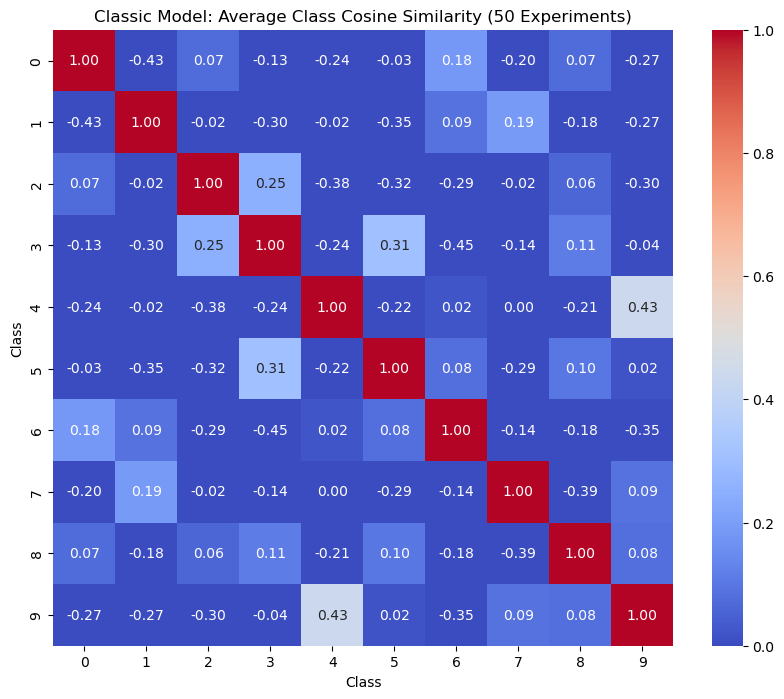

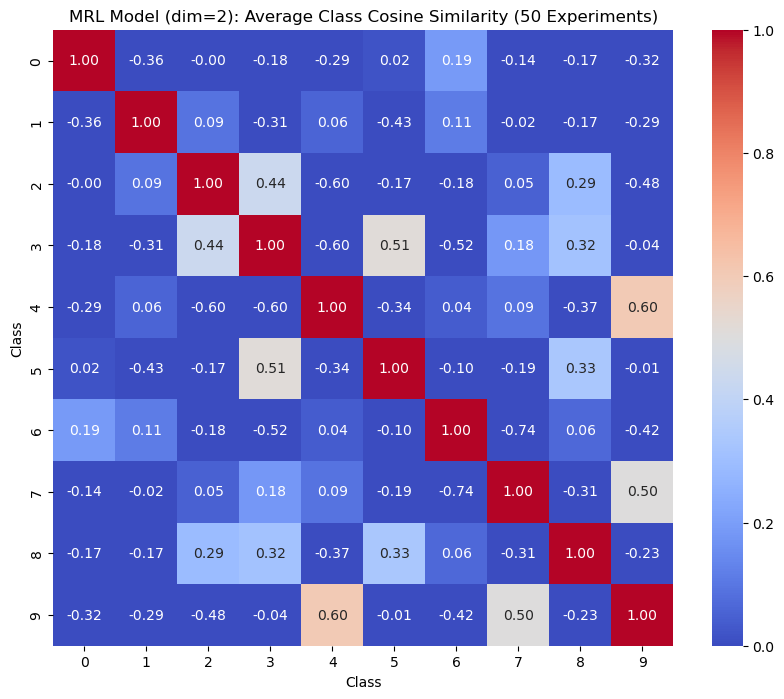

In [179]:


# Helper function to compute class mean embeddings and cosine similarity matrix
def get_class_similarity(model, test_loader, model_type='mrl', dim=2):
    device = next(model.parameters()).device
    model.eval()
    
    # Storage for class embeddings
    class_embeddings = {i: [] for i in range(10)}
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            embeddings = model.embed(x,dim=2)
                
            for emb, label in zip(embeddings.cpu().numpy(), y.cpu().numpy()):
                class_embeddings[label].append(emb)
    
    # Compute mean embeddings for each class
    mean_embeddings = []
    for i in range(10):
        mean_emb = np.mean(class_embeddings[i], axis=0)
        mean_embeddings.append(mean_emb)
    
    # Compute cosine similarity matrix
    similarity_matrix = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            similarity_matrix[i,j] = F.cosine_similarity(
                torch.tensor(mean_embeddings[i]).float(),
                torch.tensor(mean_embeddings[j]).float(),
                dim=0
            ).item()
            
    return similarity_matrix

# Main experiment
N_EXPERIMENTS = 50
accumulated_classic_sim = np.zeros((10, 10))
accumulated_mrl_sim = np.zeros((10, 10))

# Create fixed test loader once
test_loader = DataLoader(test_data, batch_size=128)

for exp in range(N_EXPERIMENTS):
    # Train models
    print(exp)
    classic_model = train_classic_model(train_loader)
    mrl_model = train_mrlmodel(train_loader)
    
    # Compute similarity matrices
    classic_sim = get_class_similarity(classic_model, test_loader)
    mrl_sim = get_class_similarity(mrl_model, test_loader)
    
    # Accumulate results
    accumulated_classic_sim += classic_sim
    accumulated_mrl_sim += mrl_sim

# Average across experiments
avg_classic_sim = accumulated_classic_sim / N_EXPERIMENTS
avg_mrl_sim = accumulated_mrl_sim / N_EXPERIMENTS



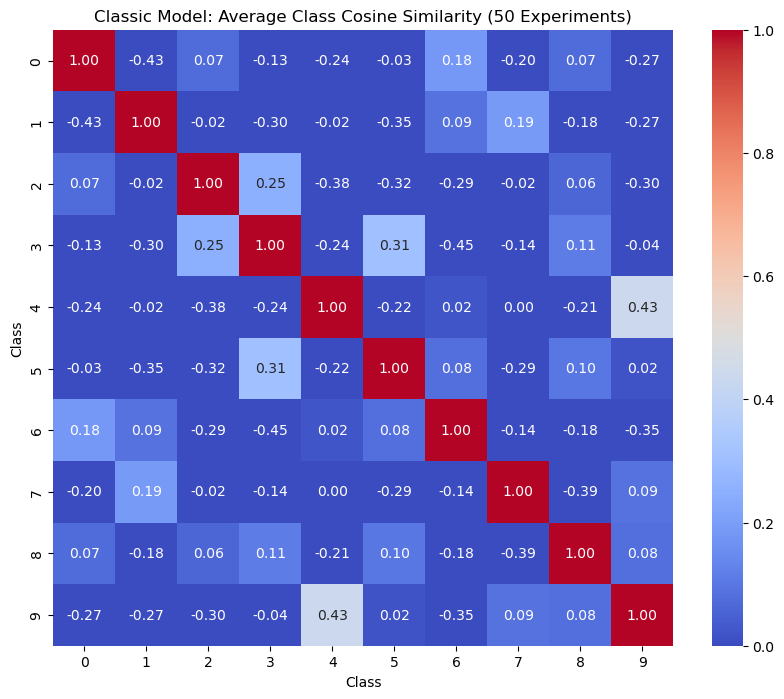

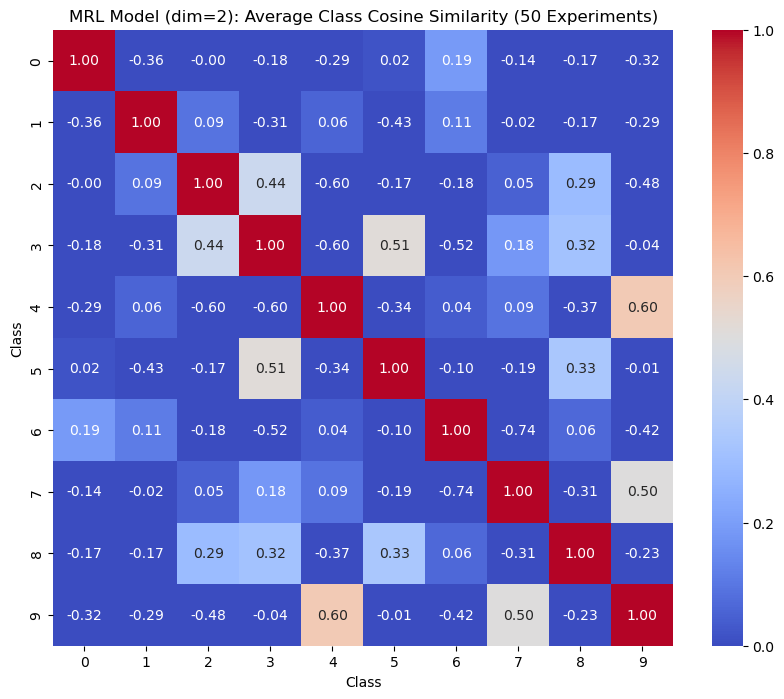

In [180]:
# Visualization
def plot_similarity(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm",
                xticklabels=range(10), yticklabels=range(10),
                vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Class")
    plt.show()

# Plot results
plot_similarity(avg_classic_sim, 
               "Classic Model: Average Class Cosine Similarity (50 Experiments)")
plot_similarity(avg_mrl_sim, 
               "MRL Model (dim=2): Average Class Cosine Similarity (50 Experiments)")

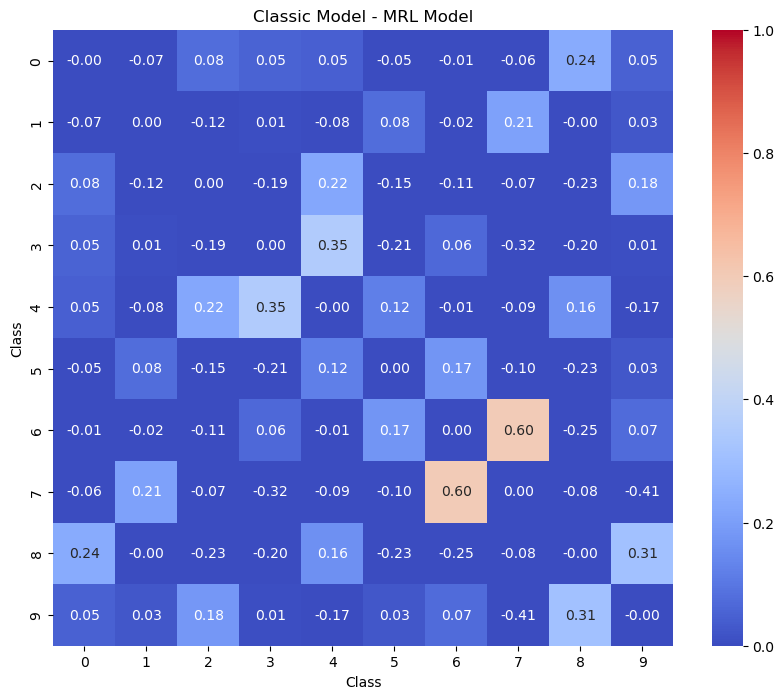

In [185]:
plot_similarity(avg_classic_sim - avg_mrl_sim, 
               "Classic Model - MRL Model")

## Eigenvalues

In [300]:
classic_model = train_classic_model(train_loader)
mrl_model = train_mrlmodel(train_loader)


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.21it/s]


Epoch 1, Loss: 0.7981


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.90it/s]


Epoch 2, Loss: 0.5650


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.78it/s]


Epoch 3, Loss: 0.4531


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.22it/s]


Epoch 4, Loss: 0.4611


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.04it/s]


Epoch 5, Loss: 0.4460


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.82it/s]


Epoch 6, Loss: 0.5250


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.92it/s]


Epoch 7, Loss: 0.2848


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.34it/s]


Epoch 8, Loss: 0.3792


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.28it/s]


Epoch 9, Loss: 0.3820


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.75it/s]


Epoch 10, Loss: 0.3608


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 103.64it/s]


Epoch 1, Loss: 1.7191


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.44it/s]


Epoch 2, Loss: 1.3516


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.04it/s]


Epoch 3, Loss: 1.3707


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.66it/s]


Epoch 4, Loss: 0.8214


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.29it/s]


Epoch 5, Loss: 0.7551


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.47it/s]


Epoch 6, Loss: 0.9326


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.64it/s]


Epoch 7, Loss: 0.5265


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.72it/s]


Epoch 8, Loss: 0.4480


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.41it/s]


Epoch 9, Loss: 0.4017


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.79it/s]

Epoch 10, Loss: 0.3849


In [ ]:
torch.eig

In [322]:
def eigenvalue_distribution(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # compute the covariance matrix of the weights
            weight_cov = torch.mm(module.weight.data, module.weight.data.t())
            
            # compute the eigenvalues
            eigenvalues = torch.linalg.eigvals(weight_cov).detach().cpu().numpy()
            
            # plot the histogram
            plt.hist(eigenvalues, bins=100)
            plt.title(f'Eigenvalue distribution of layer {name}')

            plt.show() 
    return weight_cov, eigenvalues

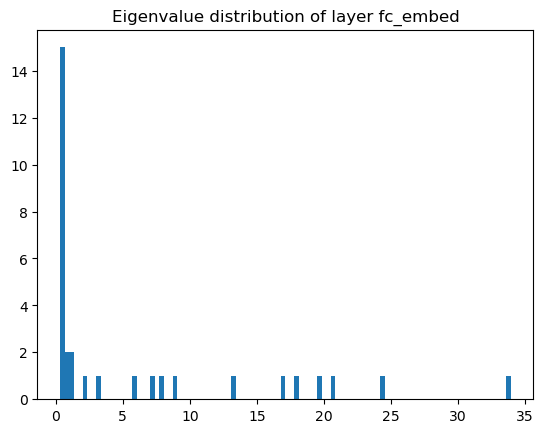

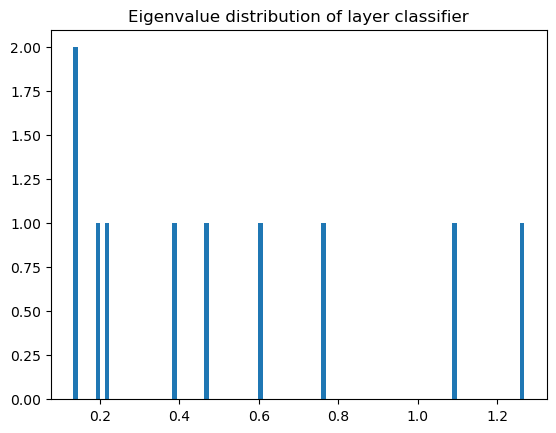

In [324]:
w,e = eigenvalue_distribution(mrl_model)

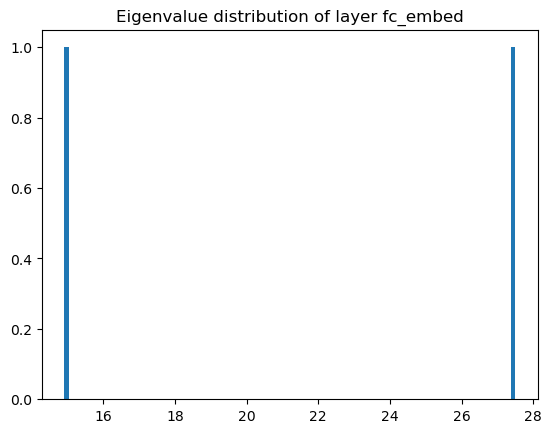

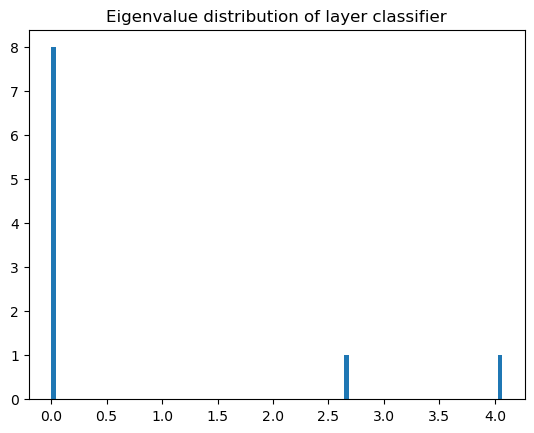

In [314]:
eigenvalue_distribution(classic_model)

# Grad Cam

In [263]:
classic_model = train_classic_model(train_loader)
mrl_model = train_mrlmodel(train_loader)


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 123.22it/s]


Epoch 1, Loss: 0.6854


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.92it/s]


Epoch 2, Loss: 0.6527


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.05it/s]


Epoch 3, Loss: 0.4497


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.16it/s]


Epoch 4, Loss: 0.4291


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.84it/s]


Epoch 5, Loss: 0.3668


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.26it/s]


Epoch 6, Loss: 0.3539


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.89it/s]


Epoch 7, Loss: 0.3951


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.45it/s]


Epoch 8, Loss: 0.2313


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.09it/s]


Epoch 9, Loss: 0.2951


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.50it/s]


Epoch 10, Loss: 0.2612


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.84it/s]


Epoch 1, Loss: 1.6961


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.98it/s]


Epoch 2, Loss: 1.3109


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.56it/s]


Epoch 3, Loss: 0.9367


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.06it/s]


Epoch 4, Loss: 1.0812


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.27it/s]


Epoch 5, Loss: 1.1570


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.55it/s]


Epoch 6, Loss: 0.5757


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.75it/s]


Epoch 7, Loss: 0.6833


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.73it/s]


Epoch 8, Loss: 1.3874


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.32it/s]


Epoch 9, Loss: 0.7582


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.71it/s]

Epoch 10, Loss: 0.5441


In [264]:
mrl_model.eval()
classic_model.eval()
mrl_model.to("cpu")
classic_model.to("cpu")

ClassicCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc_embed): Linear(in_features=1600, out_features=2, bias=True)
  (classifier): Linear(in_features=2, out_features=10, bias=True)
)

In [251]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM

def plot_average_heatmaps(
    model, 
    test_loader, 
    dim=2,                  # The embedding dimension to use in model.predict
    device="cpu",
    target_layer="conv1"
):
    """
    Computes & displays an average Grad-CAM heatmap per MNIST class (0..9).
    
    Args:
        model (nn.Module): Your trained MRLModel or similar.
        test_loader (DataLoader): PyTorch DataLoader yielding (image, label) for MNIST test set.
        dim (int): Dimensionality for model.predict(..., dim=...).
        target_layer (str): Layer name to visualize with Grad-CAM (e.g., 'conv2').
        device (str): 'cpu' or 'cuda'.
    """
    # Move model to device and set eval mode
    model.to(device)
    model.eval()

    # Create the GradCAM object
    cam_extractor = GradCAM(model, target_layer=target_layer)

    # We'll accumulate sums of CAMs for each class 0..9
    num_classes = 10
    cam_sums = [None] * num_classes
    counts = [0] * num_classes

    # Loop over the entire test set
    for images, labels in tqdm.tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Process each image in the batch individually
        for i in range(len(images)):
            x = images[i].unsqueeze(0)  # shape => [1, 1, 28, 28] for MNIST
            label = labels[i].item()

            # 1) Forward pass using model.predict(...) for a chosen dimension
            logits = model.predict(x, dim=dim)  # => shape [1, 10]

            # 2) Generate the Grad-CAM for the *ground-truth* class
            #    TorchCAM returns a dict: {layer_name: [cam_for_batch_item]} 
            activation_map = cam_extractor(label, logits)
            
            # 3) Extract the CAM tensor for this single sample
            #    We expect something like activation_map["conv2"][0] 
            #    but if you only hooked 1 layer, you can do:
            cam_dict = activation_map[0]  # first (and only) key, e.g. "conv2"
            cam_t = cam_dict[0].detach().cpu().numpy()   # shape => [H', W']
            
            # 4) Accumulate sums for each digit
            if cam_sums[label] is None:
                cam_sums[label] = np.zeros_like(cam_t)
            cam_sums[label] += cam_t
            counts[label] += 1

    # -----------------------------
    # Plot the average heatmaps
    # -----------------------------
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for c in range(num_classes):
        if counts[c] > 0:
            avg_cam = cam_sums[c] / counts[c]
        else:
            # If no samples for this class (unlikely in MNIST), just make an empty map
            avg_cam = np.zeros((7, 7))

        # Display heatmap
        axes[c].imshow(avg_cam, cmap="jet")
        axes[c].set_title(f"Class {c} (N={counts[c]})")
        axes[c].axis("off")

    plt.tight_layout()
    plt.show()


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:16<00:00,  4.72it/s]


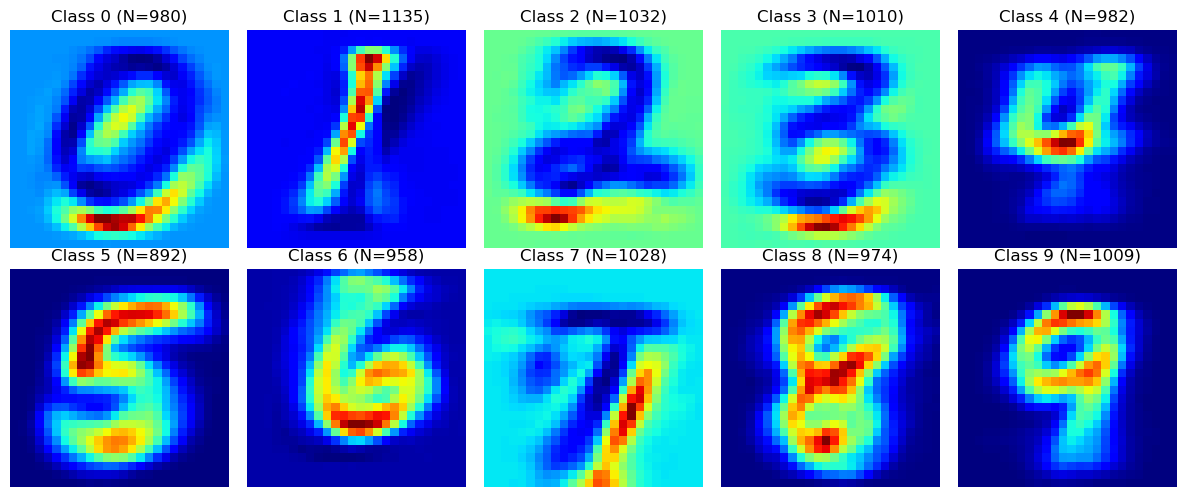

In [252]:
plot_average_heatmaps(mrlmodel,test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.47it/s]


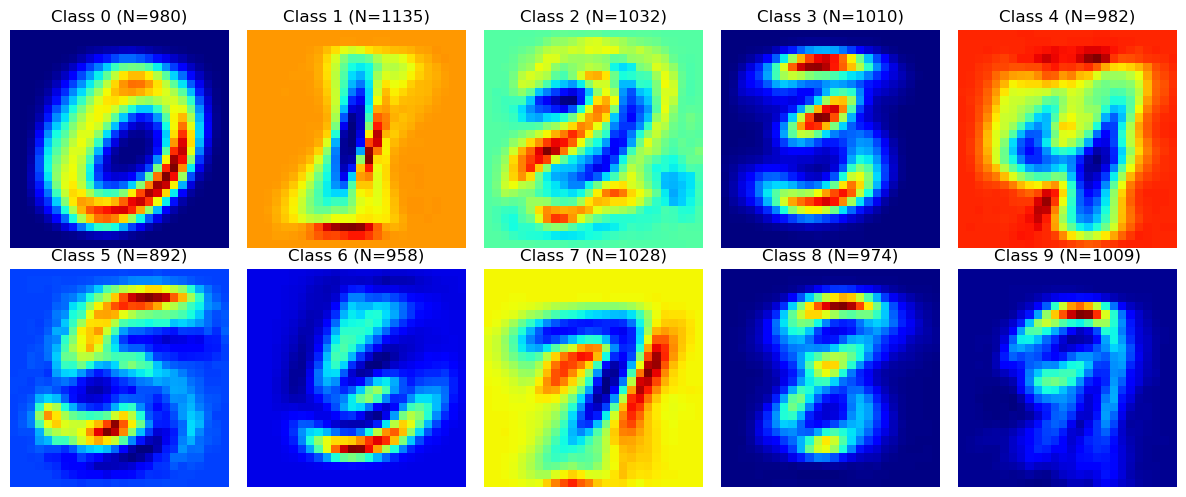

In [253]:
plot_average_heatmaps(classic_model,test_loader)

## MNIST-C

In [258]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os

class NumpyMNISTCDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        # images_file => e.g. "mnist_c/brightness/test_images.npy"
        # labels_file => e.g. "mnist_c/brightness/test_labels.npy"
        self.images = np.load(images_file)  # shape [10000, 28, 28]
        self.labels = np.load(labels_file)  # shape [10000]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]    # shape [28, 28]
        label = self.labels[idx]  # int
        if self.transform:
            img = self.transform(img)
        return img, label

# Example usage:
from torchvision import transforms

# Transform: turn [28,28] numpy to a FloatTensor [1,28,28]
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset_path = ".\\mnist_c\\brightness"
images_file = os.path.join(dataset_path, "test_images.npy")
labels_file = os.path.join(dataset_path, "test_labels.npy")

mnist_c_dataset = NumpyMNISTCDataset(images_file, labels_file, transform=transform)
mnist_c_loader = DataLoader(mnist_c_dataset, batch_size=64, shuffle=False)




In [270]:
import torch
import torch.nn.functional as F

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # For your MRLModel, you might do:
            #   logits_list = model(images)
            #   logits = logits_list[-1]  # or whichever dimension you want
            logits = model.predict(images,dim=2)

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100.0 * correct / total


In [279]:
import glob
dataset_path = ".\\mnist_c\\"
corruptions = [
    "brightness", "canny_edges", "dotted_line", "fog", "glass_blur",
    "identity", "motion_blur", "rotate", "scale", "shear", "spatter",
    "stripe", "translate", "zigzag", "shot_noise"  # etc., based on the release
]

mrl_acc = {}
classic_acc = {}

for corr_type in corruptions:
    mrl_acc[corr_type] = []
    classic_acc[corr_type] = []

for experiment in range(35):
    classic_model = train_classic_model(train_loader)
    mrl_model = train_mrlmodel(train_loader)
        
    for corr_type in corruptions:
        images_file = os.path.join(dataset_path, corr_type, "test_images.npy")
        labels_file = os.path.join(dataset_path, corr_type, "test_labels.npy")
    
        # Load dataset & create loader
        ds = NumpyMNISTCDataset(images_file, labels_file, transform=transform)
        loader = DataLoader(ds, batch_size=64, shuffle=False)
    
        # Evaluate
        acc = evaluate_model(mrl_model, loader, device="cpu")
        print(f"Corruption: {corr_type:15s} | Accuracy = {acc:.2f}%")
        mrl_acc[corr_type].append(acc)
    
    
    for corr_type in corruptions:
        images_file = os.path.join(dataset_path, corr_type, "test_images.npy")
        labels_file = os.path.join(dataset_path, corr_type, "test_labels.npy")
    
        # Load dataset & create loader
        ds = NumpyMNISTCDataset(images_file, labels_file, transform=transform)
        loader = DataLoader(ds, batch_size=64, shuffle=False)
    
        # Evaluate
        acc = evaluate_model(classic_model, loader, device="cpu")
        print(f"Corruption: {corr_type:15s} | Accuracy = {acc:.2f}%")
        classic_acc[corr_type].append(acc)

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.27it/s]


Epoch 1, Loss: 0.8635


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.26it/s]


Epoch 2, Loss: 0.6711


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.07it/s]


Epoch 3, Loss: 0.5730


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.30it/s]


Epoch 4, Loss: 0.5014


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.15it/s]


Epoch 5, Loss: 0.6548


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.64it/s]


Epoch 6, Loss: 0.5688


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.40it/s]


Epoch 7, Loss: 0.4924


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.70it/s]


Epoch 8, Loss: 0.5263


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.99it/s]


Epoch 9, Loss: 0.2507


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.77it/s]


Epoch 10, Loss: 0.3672


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.49it/s]


Epoch 1, Loss: 1.6532


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.45it/s]


Epoch 2, Loss: 1.0924


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.57it/s]


Epoch 3, Loss: 1.4819


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.86it/s]


Epoch 4, Loss: 0.7154


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.96it/s]


Epoch 5, Loss: 0.8288


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.67it/s]


Epoch 6, Loss: 0.7667


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.59it/s]


Epoch 7, Loss: 1.0376


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.14it/s]


Epoch 8, Loss: 0.5186


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.67it/s]


Epoch 9, Loss: 0.8959


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.98it/s]


Epoch 10, Loss: 0.4784
Corruption: brightness      | Accuracy = 37.33%
Corruption: canny_edges     | Accuracy = 34.41%
Corruption: dotted_line     | Accuracy = 76.57%
Corruption: fog             | Accuracy = 18.28%
Corruption: glass_blur      | Accuracy = 55.52%
Corruption: identity        | Accuracy = 91.49%
Corruption: motion_blur     | Accuracy = 64.16%
Corruption: rotate          | Accuracy = 74.80%
Corruption: scale           | Accuracy = 64.77%
Corruption: shear           | Accuracy = 82.79%
Corruption: spatter         | Accuracy = 81.42%
Corruption: stripe          | Accuracy = 23.53%
Corruption: translate       | Accuracy = 34.11%
Corruption: zigzag          | Accuracy = 61.28%
Corruption: shot_noise      | Accuracy = 74.89%
Corruption: brightness      | Accuracy = 38.98%
Corruption: canny_edges     | Accuracy = 37.38%
Corruption: dotted_line     | Accuracy = 65.16%
Corruption: fog             | Accuracy = 18.12%
Corruption: glass_blur      | Accuracy = 50.70%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.05it/s]


Epoch 1, Loss: 0.6168


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.56it/s]


Epoch 2, Loss: 0.5373


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.30it/s]


Epoch 3, Loss: 0.3050


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.84it/s]


Epoch 4, Loss: 0.5197


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.89it/s]


Epoch 5, Loss: 0.4469


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.97it/s]


Epoch 6, Loss: 0.3804


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.63it/s]


Epoch 7, Loss: 0.3708


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.53it/s]


Epoch 8, Loss: 0.2446


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.08it/s]


Epoch 9, Loss: 0.3788


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.90it/s]


Epoch 10, Loss: 0.2276


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.61it/s]


Epoch 1, Loss: 1.1874


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.26it/s]


Epoch 2, Loss: 0.8910


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.84it/s]


Epoch 3, Loss: 1.5297


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.59it/s]


Epoch 4, Loss: 0.7449


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.65it/s]


Epoch 5, Loss: 0.5703


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.22it/s]


Epoch 6, Loss: 1.0092


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.57it/s]


Epoch 7, Loss: 0.9953


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.77it/s]


Epoch 8, Loss: 0.4601


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.35it/s]


Epoch 9, Loss: 0.4051


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.19it/s]


Epoch 10, Loss: 1.3979
Corruption: brightness      | Accuracy = 51.26%
Corruption: canny_edges     | Accuracy = 40.35%
Corruption: dotted_line     | Accuracy = 76.21%
Corruption: fog             | Accuracy = 30.23%
Corruption: glass_blur      | Accuracy = 63.59%
Corruption: identity        | Accuracy = 89.40%
Corruption: motion_blur     | Accuracy = 63.59%
Corruption: rotate          | Accuracy = 65.54%
Corruption: scale           | Accuracy = 54.07%
Corruption: shear           | Accuracy = 76.53%
Corruption: spatter         | Accuracy = 81.57%
Corruption: stripe          | Accuracy = 23.09%
Corruption: translate       | Accuracy = 30.57%
Corruption: zigzag          | Accuracy = 66.89%
Corruption: shot_noise      | Accuracy = 80.09%
Corruption: brightness      | Accuracy = 24.02%
Corruption: canny_edges     | Accuracy = 35.51%
Corruption: dotted_line     | Accuracy = 76.27%
Corruption: fog             | Accuracy = 12.83%
Corruption: glass_blur      | Accuracy = 52.00%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.89it/s]


Epoch 1, Loss: 1.0939


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.98it/s]


Epoch 2, Loss: 0.6456


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.02it/s]


Epoch 3, Loss: 0.6917


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.68it/s]


Epoch 4, Loss: 0.4895


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.90it/s]


Epoch 5, Loss: 0.5109


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.13it/s]


Epoch 6, Loss: 0.3943


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.34it/s]


Epoch 7, Loss: 0.4452


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.79it/s]


Epoch 8, Loss: 0.6578


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.15it/s]


Epoch 9, Loss: 0.2694


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.59it/s]


Epoch 10, Loss: 0.4114


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.23it/s]


Epoch 1, Loss: 1.2543


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.60it/s]


Epoch 2, Loss: 1.2912


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.65it/s]


Epoch 3, Loss: 0.9267


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.83it/s]


Epoch 4, Loss: 1.2621


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.95it/s]


Epoch 5, Loss: 1.4762


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.39it/s]


Epoch 6, Loss: 0.6697


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.96it/s]


Epoch 7, Loss: 0.8233


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.08it/s]


Epoch 8, Loss: 0.3908


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.38it/s]


Epoch 9, Loss: 0.5040


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.57it/s]


Epoch 10, Loss: 0.6205
Corruption: brightness      | Accuracy = 32.07%
Corruption: canny_edges     | Accuracy = 39.91%
Corruption: dotted_line     | Accuracy = 73.82%
Corruption: fog             | Accuracy = 30.16%
Corruption: glass_blur      | Accuracy = 57.12%
Corruption: identity        | Accuracy = 90.79%
Corruption: motion_blur     | Accuracy = 64.53%
Corruption: rotate          | Accuracy = 71.33%
Corruption: scale           | Accuracy = 58.50%
Corruption: shear           | Accuracy = 82.10%
Corruption: spatter         | Accuracy = 82.69%
Corruption: stripe          | Accuracy = 20.21%
Corruption: translate       | Accuracy = 33.42%
Corruption: zigzag          | Accuracy = 59.32%
Corruption: shot_noise      | Accuracy = 80.49%
Corruption: brightness      | Accuracy = 38.12%
Corruption: canny_edges     | Accuracy = 34.86%
Corruption: dotted_line     | Accuracy = 67.90%
Corruption: fog             | Accuracy = 17.55%
Corruption: glass_blur      | Accuracy = 47.58%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.05it/s]


Epoch 1, Loss: 0.7602


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.56it/s]


Epoch 2, Loss: 0.6658


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.30it/s]


Epoch 3, Loss: 0.5500


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.53it/s]


Epoch 4, Loss: 0.5146


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.90it/s]


Epoch 5, Loss: 0.5405


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.75it/s]


Epoch 6, Loss: 0.3225


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.25it/s]


Epoch 7, Loss: 0.3639


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 139.49it/s]


Epoch 8, Loss: 0.3016


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.78it/s]


Epoch 9, Loss: 0.4446


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.30it/s]


Epoch 10, Loss: 0.1853


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.76it/s]


Epoch 1, Loss: 1.5537


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.73it/s]


Epoch 2, Loss: 1.1126


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.31it/s]


Epoch 3, Loss: 1.0433


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.84it/s]


Epoch 4, Loss: 0.7371


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.29it/s]


Epoch 5, Loss: 0.7938


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.19it/s]


Epoch 6, Loss: 0.9303


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.84it/s]


Epoch 7, Loss: 0.5364


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.69it/s]


Epoch 8, Loss: 1.0034


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.98it/s]


Epoch 9, Loss: 0.4304


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.55it/s]


Epoch 10, Loss: 0.7677
Corruption: brightness      | Accuracy = 50.19%
Corruption: canny_edges     | Accuracy = 46.27%
Corruption: dotted_line     | Accuracy = 76.06%
Corruption: fog             | Accuracy = 18.03%
Corruption: glass_blur      | Accuracy = 67.84%
Corruption: identity        | Accuracy = 90.35%
Corruption: motion_blur     | Accuracy = 69.99%
Corruption: rotate          | Accuracy = 68.07%
Corruption: scale           | Accuracy = 61.00%
Corruption: shear           | Accuracy = 80.99%
Corruption: spatter         | Accuracy = 82.60%
Corruption: stripe          | Accuracy = 28.67%
Corruption: translate       | Accuracy = 31.11%
Corruption: zigzag          | Accuracy = 59.98%
Corruption: shot_noise      | Accuracy = 83.43%
Corruption: brightness      | Accuracy = 28.47%
Corruption: canny_edges     | Accuracy = 33.52%
Corruption: dotted_line     | Accuracy = 66.87%
Corruption: fog             | Accuracy = 14.76%
Corruption: glass_blur      | Accuracy = 56.29%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.00it/s]


Epoch 1, Loss: 0.8505


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.93it/s]


Epoch 2, Loss: 0.6267


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.60it/s]


Epoch 3, Loss: 0.4530


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.68it/s]


Epoch 4, Loss: 0.4394


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.25it/s]


Epoch 5, Loss: 0.3284


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.88it/s]


Epoch 6, Loss: 0.3493


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.45it/s]


Epoch 7, Loss: 0.5218


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.41it/s]


Epoch 8, Loss: 0.1645


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.05it/s]


Epoch 9, Loss: 0.2886


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.76it/s]


Epoch 10, Loss: 0.2835


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.10it/s]


Epoch 1, Loss: 1.5811


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.60it/s]


Epoch 2, Loss: 1.5727


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.93it/s]


Epoch 3, Loss: 1.3499


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.46it/s]


Epoch 4, Loss: 0.7272


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.25it/s]


Epoch 5, Loss: 0.7771


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.73it/s]


Epoch 6, Loss: 0.8465


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.43it/s]


Epoch 7, Loss: 0.9472


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.30it/s]


Epoch 8, Loss: 0.5311


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.11it/s]


Epoch 9, Loss: 0.5356


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.88it/s]


Epoch 10, Loss: 0.5465
Corruption: brightness      | Accuracy = 22.92%
Corruption: canny_edges     | Accuracy = 40.10%
Corruption: dotted_line     | Accuracy = 73.58%
Corruption: fog             | Accuracy = 21.43%
Corruption: glass_blur      | Accuracy = 58.07%
Corruption: identity        | Accuracy = 88.98%
Corruption: motion_blur     | Accuracy = 64.15%
Corruption: rotate          | Accuracy = 64.29%
Corruption: scale           | Accuracy = 64.04%
Corruption: shear           | Accuracy = 77.44%
Corruption: spatter         | Accuracy = 80.45%
Corruption: stripe          | Accuracy = 49.20%
Corruption: translate       | Accuracy = 41.54%
Corruption: zigzag          | Accuracy = 53.81%
Corruption: shot_noise      | Accuracy = 79.79%
Corruption: brightness      | Accuracy = 14.04%
Corruption: canny_edges     | Accuracy = 26.30%
Corruption: dotted_line     | Accuracy = 66.95%
Corruption: fog             | Accuracy = 15.39%
Corruption: glass_blur      | Accuracy = 49.93%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.25it/s]


Epoch 1, Loss: 0.8792


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.28it/s]


Epoch 2, Loss: 0.7941


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.15it/s]


Epoch 3, Loss: 0.9211


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.78it/s]


Epoch 4, Loss: 0.6674


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.53it/s]


Epoch 5, Loss: 0.6005


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.02it/s]


Epoch 6, Loss: 0.6077


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.11it/s]


Epoch 7, Loss: 0.4835


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.95it/s]


Epoch 8, Loss: 0.3268


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.19it/s]


Epoch 9, Loss: 0.2168


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.63it/s]


Epoch 10, Loss: 0.5138


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.60it/s]


Epoch 1, Loss: 1.8739


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.64it/s]


Epoch 2, Loss: 1.2786


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.68it/s]


Epoch 3, Loss: 1.2299


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.59it/s]


Epoch 4, Loss: 0.7605


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.24it/s]


Epoch 5, Loss: 1.5687


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.55it/s]


Epoch 6, Loss: 0.5802


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.43it/s]


Epoch 7, Loss: 0.7926


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.93it/s]


Epoch 8, Loss: 0.7920


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.73it/s]


Epoch 9, Loss: 0.7865


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.71it/s]


Epoch 10, Loss: 0.3038
Corruption: brightness      | Accuracy = 36.95%
Corruption: canny_edges     | Accuracy = 43.30%
Corruption: dotted_line     | Accuracy = 75.04%
Corruption: fog             | Accuracy = 25.12%
Corruption: glass_blur      | Accuracy = 61.11%
Corruption: identity        | Accuracy = 90.86%
Corruption: motion_blur     | Accuracy = 60.58%
Corruption: rotate          | Accuracy = 67.58%
Corruption: scale           | Accuracy = 51.23%
Corruption: shear           | Accuracy = 81.51%
Corruption: spatter         | Accuracy = 81.18%
Corruption: stripe          | Accuracy = 31.33%
Corruption: translate       | Accuracy = 37.13%
Corruption: zigzag          | Accuracy = 60.37%
Corruption: shot_noise      | Accuracy = 81.26%
Corruption: brightness      | Accuracy = 23.01%
Corruption: canny_edges     | Accuracy = 30.79%
Corruption: dotted_line     | Accuracy = 68.04%
Corruption: fog             | Accuracy = 21.76%
Corruption: glass_blur      | Accuracy = 67.44%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.92it/s]


Epoch 1, Loss: 0.6889


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.30it/s]


Epoch 2, Loss: 0.6616


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.17it/s]


Epoch 3, Loss: 0.5165


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.14it/s]


Epoch 4, Loss: 0.4072


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.96it/s]


Epoch 5, Loss: 0.2982


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.52it/s]


Epoch 6, Loss: 0.9958


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.43it/s]


Epoch 7, Loss: 0.2588


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.79it/s]


Epoch 8, Loss: 0.4085


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.26it/s]


Epoch 9, Loss: 0.2369


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.42it/s]


Epoch 10, Loss: 0.7137


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.62it/s]


Epoch 1, Loss: 1.2389


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.74it/s]


Epoch 2, Loss: 1.2619


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.63it/s]


Epoch 3, Loss: 1.3326


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.46it/s]


Epoch 4, Loss: 0.5361


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.24it/s]


Epoch 5, Loss: 0.5577


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.38it/s]


Epoch 6, Loss: 0.5834


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.66it/s]


Epoch 7, Loss: 0.4854


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.63it/s]


Epoch 8, Loss: 0.5032


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.48it/s]


Epoch 9, Loss: 0.4787


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.73it/s]


Epoch 10, Loss: 0.4052
Corruption: brightness      | Accuracy = 36.00%
Corruption: canny_edges     | Accuracy = 53.16%
Corruption: dotted_line     | Accuracy = 77.40%
Corruption: fog             | Accuracy = 21.60%
Corruption: glass_blur      | Accuracy = 56.17%
Corruption: identity        | Accuracy = 90.97%
Corruption: motion_blur     | Accuracy = 67.73%
Corruption: rotate          | Accuracy = 70.08%
Corruption: scale           | Accuracy = 62.06%
Corruption: shear           | Accuracy = 82.77%
Corruption: spatter         | Accuracy = 83.18%
Corruption: stripe          | Accuracy = 21.00%
Corruption: translate       | Accuracy = 31.54%
Corruption: zigzag          | Accuracy = 68.89%
Corruption: shot_noise      | Accuracy = 76.88%
Corruption: brightness      | Accuracy = 32.55%
Corruption: canny_edges     | Accuracy = 52.41%
Corruption: dotted_line     | Accuracy = 71.12%
Corruption: fog             | Accuracy = 17.65%
Corruption: glass_blur      | Accuracy = 56.64%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.37it/s]


Epoch 1, Loss: 0.8327


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.22it/s]


Epoch 2, Loss: 0.6891


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.62it/s]


Epoch 3, Loss: 0.5380


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.83it/s]


Epoch 4, Loss: 0.5778


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.98it/s]


Epoch 5, Loss: 0.3746


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.96it/s]


Epoch 6, Loss: 0.5051


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.28it/s]


Epoch 7, Loss: 0.5466


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.36it/s]


Epoch 8, Loss: 0.3781


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.09it/s]


Epoch 9, Loss: 0.3330


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.12it/s]


Epoch 10, Loss: 0.2019


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.71it/s]


Epoch 1, Loss: 1.2813


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.66it/s]


Epoch 2, Loss: 1.0356


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.61it/s]


Epoch 3, Loss: 0.7128


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.26it/s]


Epoch 4, Loss: 1.1578


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.67it/s]


Epoch 5, Loss: 0.5323


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.54it/s]


Epoch 6, Loss: 0.5771


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.02it/s]


Epoch 7, Loss: 0.5782


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.82it/s]


Epoch 8, Loss: 0.6045


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.08it/s]


Epoch 9, Loss: 0.4579


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.58it/s]


Epoch 10, Loss: 0.4239
Corruption: brightness      | Accuracy = 54.03%
Corruption: canny_edges     | Accuracy = 43.79%
Corruption: dotted_line     | Accuracy = 77.00%
Corruption: fog             | Accuracy = 38.39%
Corruption: glass_blur      | Accuracy = 63.92%
Corruption: identity        | Accuracy = 89.94%
Corruption: motion_blur     | Accuracy = 72.59%
Corruption: rotate          | Accuracy = 72.21%
Corruption: scale           | Accuracy = 53.78%
Corruption: shear           | Accuracy = 81.01%
Corruption: spatter         | Accuracy = 81.56%
Corruption: stripe          | Accuracy = 21.34%
Corruption: translate       | Accuracy = 31.53%
Corruption: zigzag          | Accuracy = 59.21%
Corruption: shot_noise      | Accuracy = 80.70%
Corruption: brightness      | Accuracy = 17.90%
Corruption: canny_edges     | Accuracy = 22.70%
Corruption: dotted_line     | Accuracy = 70.45%
Corruption: fog             | Accuracy = 20.55%
Corruption: glass_blur      | Accuracy = 56.51%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.93it/s]


Epoch 1, Loss: 0.8204


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.77it/s]


Epoch 2, Loss: 0.4931


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.65it/s]


Epoch 3, Loss: 0.5172


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.95it/s]


Epoch 4, Loss: 0.6264


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.42it/s]


Epoch 5, Loss: 0.3159


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.76it/s]


Epoch 6, Loss: 0.4260


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.35it/s]


Epoch 7, Loss: 0.2608


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.64it/s]


Epoch 8, Loss: 0.3762


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.33it/s]


Epoch 9, Loss: 0.3081


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.80it/s]


Epoch 10, Loss: 0.2376


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.46it/s]


Epoch 1, Loss: 1.5722


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.64it/s]


Epoch 2, Loss: 0.8709


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 104.05it/s]


Epoch 3, Loss: 1.0762


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.75it/s]


Epoch 4, Loss: 0.8373


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.22it/s]


Epoch 5, Loss: 0.8828


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.81it/s]


Epoch 6, Loss: 0.6344


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.63it/s]


Epoch 7, Loss: 0.4371


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.30it/s]


Epoch 8, Loss: 0.7010


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.72it/s]


Epoch 9, Loss: 0.3382


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.72it/s]


Epoch 10, Loss: 0.5172
Corruption: brightness      | Accuracy = 46.29%
Corruption: canny_edges     | Accuracy = 40.26%
Corruption: dotted_line     | Accuracy = 72.94%
Corruption: fog             | Accuracy = 25.17%
Corruption: glass_blur      | Accuracy = 65.30%
Corruption: identity        | Accuracy = 89.15%
Corruption: motion_blur     | Accuracy = 65.08%
Corruption: rotate          | Accuracy = 66.97%
Corruption: scale           | Accuracy = 56.94%
Corruption: shear           | Accuracy = 82.11%
Corruption: spatter         | Accuracy = 80.99%
Corruption: stripe          | Accuracy = 28.22%
Corruption: translate       | Accuracy = 34.02%
Corruption: zigzag          | Accuracy = 59.07%
Corruption: shot_noise      | Accuracy = 81.71%
Corruption: brightness      | Accuracy = 36.76%
Corruption: canny_edges     | Accuracy = 41.11%
Corruption: dotted_line     | Accuracy = 68.42%
Corruption: fog             | Accuracy = 23.27%
Corruption: glass_blur      | Accuracy = 58.58%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.45it/s]


Epoch 1, Loss: 0.9910


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.38it/s]


Epoch 2, Loss: 0.5674


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.87it/s]


Epoch 3, Loss: 0.5825


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.91it/s]


Epoch 4, Loss: 0.4913


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.71it/s]


Epoch 5, Loss: 0.4420


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.21it/s]


Epoch 6, Loss: 0.3525


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.62it/s]


Epoch 7, Loss: 0.4170


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.72it/s]


Epoch 8, Loss: 0.4314


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.34it/s]


Epoch 9, Loss: 0.3196


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.60it/s]


Epoch 10, Loss: 0.2498


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.80it/s]


Epoch 1, Loss: 2.0578


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.02it/s]


Epoch 2, Loss: 1.2649


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.45it/s]


Epoch 3, Loss: 0.9887


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.03it/s]


Epoch 4, Loss: 0.9137


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.38it/s]


Epoch 5, Loss: 0.6929


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.78it/s]


Epoch 6, Loss: 0.6308


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.91it/s]


Epoch 7, Loss: 0.7819


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.60it/s]


Epoch 8, Loss: 0.3143


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.24it/s]


Epoch 9, Loss: 0.4406


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.72it/s]


Epoch 10, Loss: 0.5730
Corruption: brightness      | Accuracy = 23.93%
Corruption: canny_edges     | Accuracy = 33.99%
Corruption: dotted_line     | Accuracy = 76.90%
Corruption: fog             | Accuracy = 28.30%
Corruption: glass_blur      | Accuracy = 65.14%
Corruption: identity        | Accuracy = 87.31%
Corruption: motion_blur     | Accuracy = 61.67%
Corruption: rotate          | Accuracy = 63.83%
Corruption: scale           | Accuracy = 43.03%
Corruption: shear           | Accuracy = 75.95%
Corruption: spatter         | Accuracy = 79.62%
Corruption: stripe          | Accuracy = 23.51%
Corruption: translate       | Accuracy = 28.82%
Corruption: zigzag          | Accuracy = 63.43%
Corruption: shot_noise      | Accuracy = 78.31%
Corruption: brightness      | Accuracy = 38.33%
Corruption: canny_edges     | Accuracy = 37.31%
Corruption: dotted_line     | Accuracy = 73.52%
Corruption: fog             | Accuracy = 19.83%
Corruption: glass_blur      | Accuracy = 54.15%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.61it/s]


Epoch 1, Loss: 0.8701


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.42it/s]


Epoch 2, Loss: 0.7623


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.31it/s]


Epoch 3, Loss: 0.4967


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.14it/s]


Epoch 4, Loss: 0.3664


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.80it/s]


Epoch 5, Loss: 0.3086


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.23it/s]


Epoch 6, Loss: 0.6021


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.65it/s]


Epoch 7, Loss: 0.4465


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.58it/s]


Epoch 8, Loss: 0.2503


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.86it/s]


Epoch 9, Loss: 0.2203


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.52it/s]


Epoch 10, Loss: 0.3262


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.95it/s]


Epoch 1, Loss: 1.4766


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.51it/s]


Epoch 2, Loss: 1.6157


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.32it/s]


Epoch 3, Loss: 1.0859


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.16it/s]


Epoch 4, Loss: 1.1855


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.73it/s]


Epoch 5, Loss: 0.6639


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.07it/s]


Epoch 6, Loss: 0.6410


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.24it/s]


Epoch 7, Loss: 0.5878


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.51it/s]


Epoch 8, Loss: 0.3618


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.06it/s]


Epoch 9, Loss: 0.3102


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.51it/s]


Epoch 10, Loss: 0.3375
Corruption: brightness      | Accuracy = 51.55%
Corruption: canny_edges     | Accuracy = 33.97%
Corruption: dotted_line     | Accuracy = 75.48%
Corruption: fog             | Accuracy = 35.47%
Corruption: glass_blur      | Accuracy = 57.49%
Corruption: identity        | Accuracy = 89.57%
Corruption: motion_blur     | Accuracy = 66.69%
Corruption: rotate          | Accuracy = 66.21%
Corruption: scale           | Accuracy = 45.29%
Corruption: shear           | Accuracy = 80.32%
Corruption: spatter         | Accuracy = 80.62%
Corruption: stripe          | Accuracy = 34.72%
Corruption: translate       | Accuracy = 33.00%
Corruption: zigzag          | Accuracy = 58.16%
Corruption: shot_noise      | Accuracy = 73.13%
Corruption: brightness      | Accuracy = 40.08%
Corruption: canny_edges     | Accuracy = 45.34%
Corruption: dotted_line     | Accuracy = 76.13%
Corruption: fog             | Accuracy = 22.93%
Corruption: glass_blur      | Accuracy = 60.68%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.28it/s]


Epoch 1, Loss: 0.7691


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.06it/s]


Epoch 2, Loss: 0.6523


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.50it/s]


Epoch 3, Loss: 0.4995


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.73it/s]


Epoch 4, Loss: 0.5195


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.56it/s]


Epoch 5, Loss: 0.3899


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.01it/s]


Epoch 6, Loss: 0.3615


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.88it/s]


Epoch 7, Loss: 0.3088


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.30it/s]


Epoch 8, Loss: 0.3327


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.56it/s]


Epoch 9, Loss: 0.3683


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.15it/s]


Epoch 10, Loss: 0.1720


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.65it/s]


Epoch 1, Loss: 2.0014


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.32it/s]


Epoch 2, Loss: 1.8969


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.06it/s]


Epoch 3, Loss: 0.6892


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.46it/s]


Epoch 4, Loss: 0.6697


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.45it/s]


Epoch 5, Loss: 1.0594


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.27it/s]


Epoch 6, Loss: 0.7726


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.20it/s]


Epoch 7, Loss: 0.4811


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.93it/s]


Epoch 8, Loss: 0.5373


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.63it/s]


Epoch 9, Loss: 0.5481


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.93it/s]


Epoch 10, Loss: 0.3910
Corruption: brightness      | Accuracy = 29.05%
Corruption: canny_edges     | Accuracy = 28.43%
Corruption: dotted_line     | Accuracy = 73.53%
Corruption: fog             | Accuracy = 17.22%
Corruption: glass_blur      | Accuracy = 58.66%
Corruption: identity        | Accuracy = 89.01%
Corruption: motion_blur     | Accuracy = 64.24%
Corruption: rotate          | Accuracy = 72.48%
Corruption: scale           | Accuracy = 45.58%
Corruption: shear           | Accuracy = 81.21%
Corruption: spatter         | Accuracy = 81.67%
Corruption: stripe          | Accuracy = 22.23%
Corruption: translate       | Accuracy = 34.64%
Corruption: zigzag          | Accuracy = 57.87%
Corruption: shot_noise      | Accuracy = 80.94%
Corruption: brightness      | Accuracy = 18.44%
Corruption: canny_edges     | Accuracy = 48.84%
Corruption: dotted_line     | Accuracy = 70.59%
Corruption: fog             | Accuracy = 18.40%
Corruption: glass_blur      | Accuracy = 61.15%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.54it/s]


Epoch 1, Loss: 1.0897


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.43it/s]


Epoch 2, Loss: 0.7563


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.20it/s]


Epoch 3, Loss: 0.7745


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.57it/s]


Epoch 4, Loss: 0.3423


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.99it/s]


Epoch 5, Loss: 0.3482


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.11it/s]


Epoch 6, Loss: 0.3312


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.32it/s]


Epoch 7, Loss: 0.2274


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.86it/s]


Epoch 8, Loss: 0.2599


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.97it/s]


Epoch 9, Loss: 0.3095


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.20it/s]


Epoch 10, Loss: 0.2603


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.50it/s]


Epoch 1, Loss: 1.4174


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.35it/s]


Epoch 2, Loss: 1.0003


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.40it/s]


Epoch 3, Loss: 0.5857


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.31it/s]


Epoch 4, Loss: 0.9815


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.30it/s]


Epoch 5, Loss: 0.9075


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.26it/s]


Epoch 6, Loss: 0.5103


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.74it/s]


Epoch 7, Loss: 0.7181


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.33it/s]


Epoch 8, Loss: 0.5900


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.18it/s]


Epoch 9, Loss: 0.6479


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.13it/s]


Epoch 10, Loss: 0.4019
Corruption: brightness      | Accuracy = 34.79%
Corruption: canny_edges     | Accuracy = 47.94%
Corruption: dotted_line     | Accuracy = 74.94%
Corruption: fog             | Accuracy = 22.28%
Corruption: glass_blur      | Accuracy = 53.68%
Corruption: identity        | Accuracy = 88.58%
Corruption: motion_blur     | Accuracy = 58.41%
Corruption: rotate          | Accuracy = 67.51%
Corruption: scale           | Accuracy = 51.08%
Corruption: shear           | Accuracy = 78.83%
Corruption: spatter         | Accuracy = 80.87%
Corruption: stripe          | Accuracy = 18.07%
Corruption: translate       | Accuracy = 29.35%
Corruption: zigzag          | Accuracy = 63.14%
Corruption: shot_noise      | Accuracy = 80.27%
Corruption: brightness      | Accuracy = 43.49%
Corruption: canny_edges     | Accuracy = 43.37%
Corruption: dotted_line     | Accuracy = 72.68%
Corruption: fog             | Accuracy = 32.50%
Corruption: glass_blur      | Accuracy = 58.74%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.89it/s]


Epoch 1, Loss: 0.7474


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.87it/s]


Epoch 2, Loss: 0.5589


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.46it/s]


Epoch 3, Loss: 0.4865


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.43it/s]


Epoch 4, Loss: 0.3865


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.35it/s]


Epoch 5, Loss: 0.6587


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 139.32it/s]


Epoch 6, Loss: 0.5415


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.75it/s]


Epoch 7, Loss: 0.4466


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 139.02it/s]


Epoch 8, Loss: 0.3112


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.40it/s]


Epoch 9, Loss: 0.3350


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.66it/s]


Epoch 10, Loss: 0.3088


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.66it/s]


Epoch 1, Loss: 1.4926


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.25it/s]


Epoch 2, Loss: 1.7573


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.64it/s]


Epoch 3, Loss: 0.9987


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.27it/s]


Epoch 4, Loss: 0.7803


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.05it/s]


Epoch 5, Loss: 1.2048


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.93it/s]


Epoch 6, Loss: 0.8462


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.15it/s]


Epoch 7, Loss: 0.8294


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.25it/s]


Epoch 8, Loss: 0.7728


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.59it/s]


Epoch 9, Loss: 0.5838


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.25it/s]


Epoch 10, Loss: 0.5092
Corruption: brightness      | Accuracy = 38.36%
Corruption: canny_edges     | Accuracy = 25.16%
Corruption: dotted_line     | Accuracy = 69.03%
Corruption: fog             | Accuracy = 11.76%
Corruption: glass_blur      | Accuracy = 53.68%
Corruption: identity        | Accuracy = 87.87%
Corruption: motion_blur     | Accuracy = 58.41%
Corruption: rotate          | Accuracy = 62.24%
Corruption: scale           | Accuracy = 52.39%
Corruption: shear           | Accuracy = 78.52%
Corruption: spatter         | Accuracy = 77.39%
Corruption: stripe          | Accuracy = 36.80%
Corruption: translate       | Accuracy = 33.75%
Corruption: zigzag          | Accuracy = 54.88%
Corruption: shot_noise      | Accuracy = 70.87%
Corruption: brightness      | Accuracy = 47.29%
Corruption: canny_edges     | Accuracy = 24.49%
Corruption: dotted_line     | Accuracy = 67.04%
Corruption: fog             | Accuracy = 18.37%
Corruption: glass_blur      | Accuracy = 61.20%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.85it/s]


Epoch 1, Loss: 0.8853


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.79it/s]


Epoch 2, Loss: 0.6288


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.47it/s]


Epoch 3, Loss: 0.4244


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.35it/s]


Epoch 4, Loss: 0.5906


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.82it/s]


Epoch 5, Loss: 0.5972


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.25it/s]


Epoch 6, Loss: 0.4788


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.23it/s]


Epoch 7, Loss: 0.5368


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.38it/s]


Epoch 8, Loss: 0.3770


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.33it/s]


Epoch 9, Loss: 0.4204


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.11it/s]


Epoch 10, Loss: 0.2081


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.70it/s]


Epoch 1, Loss: 1.6468


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.88it/s]


Epoch 2, Loss: 0.9124


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.78it/s]


Epoch 3, Loss: 1.1654


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.47it/s]


Epoch 4, Loss: 0.7004


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.92it/s]


Epoch 5, Loss: 0.5661


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.62it/s]


Epoch 6, Loss: 0.4079


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.14it/s]


Epoch 7, Loss: 0.4573


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.39it/s]


Epoch 8, Loss: 0.4065


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.17it/s]


Epoch 9, Loss: 0.3176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 106.34it/s]


Epoch 10, Loss: 0.3926
Corruption: brightness      | Accuracy = 27.48%
Corruption: canny_edges     | Accuracy = 34.21%
Corruption: dotted_line     | Accuracy = 75.86%
Corruption: fog             | Accuracy = 26.99%
Corruption: glass_blur      | Accuracy = 59.09%
Corruption: identity        | Accuracy = 91.86%
Corruption: motion_blur     | Accuracy = 70.56%
Corruption: rotate          | Accuracy = 74.04%
Corruption: scale           | Accuracy = 53.09%
Corruption: shear           | Accuracy = 82.71%
Corruption: spatter         | Accuracy = 83.51%
Corruption: stripe          | Accuracy = 25.89%
Corruption: translate       | Accuracy = 33.35%
Corruption: zigzag          | Accuracy = 52.72%
Corruption: shot_noise      | Accuracy = 82.80%
Corruption: brightness      | Accuracy = 17.59%
Corruption: canny_edges     | Accuracy = 44.39%
Corruption: dotted_line     | Accuracy = 75.70%
Corruption: fog             | Accuracy = 16.19%
Corruption: glass_blur      | Accuracy = 61.11%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.65it/s]


Epoch 1, Loss: 0.8176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.78it/s]


Epoch 2, Loss: 0.6866


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.32it/s]


Epoch 3, Loss: 0.4705


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.46it/s]


Epoch 4, Loss: 0.6503


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.43it/s]


Epoch 5, Loss: 0.5629


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.23it/s]


Epoch 6, Loss: 0.3472


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.02it/s]


Epoch 7, Loss: 0.4134


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.66it/s]


Epoch 8, Loss: 0.2527


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.22it/s]


Epoch 9, Loss: 0.5125


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.49it/s]


Epoch 10, Loss: 0.4377


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.69it/s]


Epoch 1, Loss: 1.7817


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.69it/s]


Epoch 2, Loss: 2.0130


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.31it/s]


Epoch 3, Loss: 1.1869


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.83it/s]


Epoch 4, Loss: 0.9503


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.99it/s]


Epoch 5, Loss: 0.5379


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.11it/s]


Epoch 6, Loss: 0.6638


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.85it/s]


Epoch 7, Loss: 0.6394


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.63it/s]


Epoch 8, Loss: 0.4520


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.88it/s]


Epoch 9, Loss: 0.8539


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.96it/s]


Epoch 10, Loss: 0.5187
Corruption: brightness      | Accuracy = 33.28%
Corruption: canny_edges     | Accuracy = 45.72%
Corruption: dotted_line     | Accuracy = 71.22%
Corruption: fog             | Accuracy = 15.48%
Corruption: glass_blur      | Accuracy = 56.66%
Corruption: identity        | Accuracy = 89.35%
Corruption: motion_blur     | Accuracy = 61.77%
Corruption: rotate          | Accuracy = 68.48%
Corruption: scale           | Accuracy = 54.05%
Corruption: shear           | Accuracy = 81.11%
Corruption: spatter         | Accuracy = 79.94%
Corruption: stripe          | Accuracy = 18.81%
Corruption: translate       | Accuracy = 34.75%
Corruption: zigzag          | Accuracy = 55.25%
Corruption: shot_noise      | Accuracy = 73.27%
Corruption: brightness      | Accuracy = 10.93%
Corruption: canny_edges     | Accuracy = 40.40%
Corruption: dotted_line     | Accuracy = 65.80%
Corruption: fog             | Accuracy = 11.82%
Corruption: glass_blur      | Accuracy = 50.84%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.41it/s]


Epoch 1, Loss: 0.6943


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.55it/s]


Epoch 2, Loss: 0.7793


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.28it/s]


Epoch 3, Loss: 0.5144


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.35it/s]


Epoch 4, Loss: 0.4464


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.17it/s]


Epoch 5, Loss: 0.3390


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.56it/s]


Epoch 6, Loss: 0.2482


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.07it/s]


Epoch 7, Loss: 0.2999


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.00it/s]


Epoch 8, Loss: 0.3312


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.75it/s]


Epoch 9, Loss: 0.3190


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.25it/s]


Epoch 10, Loss: 0.2491


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.58it/s]


Epoch 1, Loss: 1.6369


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.17it/s]


Epoch 2, Loss: 1.4981


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.17it/s]


Epoch 3, Loss: 1.5718


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.48it/s]


Epoch 4, Loss: 0.8795


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.70it/s]


Epoch 5, Loss: 0.4183


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.47it/s]


Epoch 6, Loss: 0.5504


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.44it/s]


Epoch 7, Loss: 1.0378


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.02it/s]


Epoch 8, Loss: 0.5245


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.88it/s]


Epoch 9, Loss: 0.5414


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.00it/s]


Epoch 10, Loss: 0.5208
Corruption: brightness      | Accuracy = 43.57%
Corruption: canny_edges     | Accuracy = 33.48%
Corruption: dotted_line     | Accuracy = 75.65%
Corruption: fog             | Accuracy = 31.01%
Corruption: glass_blur      | Accuracy = 62.09%
Corruption: identity        | Accuracy = 89.57%
Corruption: motion_blur     | Accuracy = 63.13%
Corruption: rotate          | Accuracy = 65.63%
Corruption: scale           | Accuracy = 61.22%
Corruption: shear           | Accuracy = 79.96%
Corruption: spatter         | Accuracy = 79.07%
Corruption: stripe          | Accuracy = 40.55%
Corruption: translate       | Accuracy = 36.55%
Corruption: zigzag          | Accuracy = 61.40%
Corruption: shot_noise      | Accuracy = 71.52%
Corruption: brightness      | Accuracy = 26.58%
Corruption: canny_edges     | Accuracy = 51.81%
Corruption: dotted_line     | Accuracy = 70.45%
Corruption: fog             | Accuracy = 11.89%
Corruption: glass_blur      | Accuracy = 55.14%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.18it/s]


Epoch 1, Loss: 0.8842


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.03it/s]


Epoch 2, Loss: 0.6809


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.12it/s]


Epoch 3, Loss: 0.5730


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.52it/s]


Epoch 4, Loss: 0.5663


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.49it/s]


Epoch 5, Loss: 0.4784


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.82it/s]


Epoch 6, Loss: 0.3134


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 139.53it/s]


Epoch 7, Loss: 0.3521


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 139.01it/s]


Epoch 8, Loss: 0.3320


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.03it/s]


Epoch 9, Loss: 0.3575


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 141.27it/s]


Epoch 10, Loss: 0.3422


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.01it/s]


Epoch 1, Loss: 1.6462


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.51it/s]


Epoch 2, Loss: 1.0661


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.62it/s]


Epoch 3, Loss: 1.1376


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.08it/s]


Epoch 4, Loss: 0.7386


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.60it/s]


Epoch 5, Loss: 0.8986


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.86it/s]


Epoch 6, Loss: 1.3722


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.73it/s]


Epoch 7, Loss: 0.5678


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.19it/s]


Epoch 8, Loss: 0.7597


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.05it/s]


Epoch 9, Loss: 0.4331


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.49it/s]


Epoch 10, Loss: 0.6026
Corruption: brightness      | Accuracy = 31.75%
Corruption: canny_edges     | Accuracy = 36.81%
Corruption: dotted_line     | Accuracy = 74.87%
Corruption: fog             | Accuracy = 25.95%
Corruption: glass_blur      | Accuracy = 49.09%
Corruption: identity        | Accuracy = 88.80%
Corruption: motion_blur     | Accuracy = 65.64%
Corruption: rotate          | Accuracy = 69.48%
Corruption: scale           | Accuracy = 58.40%
Corruption: shear           | Accuracy = 80.02%
Corruption: spatter         | Accuracy = 80.48%
Corruption: stripe          | Accuracy = 31.25%
Corruption: translate       | Accuracy = 30.75%
Corruption: zigzag          | Accuracy = 59.77%
Corruption: shot_noise      | Accuracy = 79.54%
Corruption: brightness      | Accuracy = 39.99%
Corruption: canny_edges     | Accuracy = 26.61%
Corruption: dotted_line     | Accuracy = 65.05%
Corruption: fog             | Accuracy = 24.25%
Corruption: glass_blur      | Accuracy = 48.10%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.28it/s]


Epoch 1, Loss: 1.0436


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 145.30it/s]


Epoch 2, Loss: 0.6444


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 141.90it/s]


Epoch 3, Loss: 0.6174


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 144.52it/s]


Epoch 4, Loss: 0.4428


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 141.94it/s]


Epoch 5, Loss: 0.3973


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 141.90it/s]


Epoch 6, Loss: 0.3346


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 145.02it/s]


Epoch 7, Loss: 0.4265


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 140.71it/s]


Epoch 8, Loss: 0.2315


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 141.59it/s]


Epoch 9, Loss: 0.3880


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 144.21it/s]


Epoch 10, Loss: 0.3101


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.99it/s]


Epoch 1, Loss: 1.8527


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.61it/s]


Epoch 2, Loss: 1.1331


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.50it/s]


Epoch 3, Loss: 0.9756


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.54it/s]


Epoch 4, Loss: 0.9329


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.65it/s]


Epoch 5, Loss: 0.5532


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 102.97it/s]


Epoch 6, Loss: 0.5113


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.70it/s]


Epoch 7, Loss: 0.6668


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.52it/s]


Epoch 8, Loss: 0.3729


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.91it/s]


Epoch 9, Loss: 0.3112


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.19it/s]


Epoch 10, Loss: 0.4466
Corruption: brightness      | Accuracy = 47.20%
Corruption: canny_edges     | Accuracy = 32.16%
Corruption: dotted_line     | Accuracy = 72.60%
Corruption: fog             | Accuracy = 26.86%
Corruption: glass_blur      | Accuracy = 57.41%
Corruption: identity        | Accuracy = 87.92%
Corruption: motion_blur     | Accuracy = 65.53%
Corruption: rotate          | Accuracy = 64.87%
Corruption: scale           | Accuracy = 55.44%
Corruption: shear           | Accuracy = 76.77%
Corruption: spatter         | Accuracy = 80.94%
Corruption: stripe          | Accuracy = 40.81%
Corruption: translate       | Accuracy = 30.37%
Corruption: zigzag          | Accuracy = 52.39%
Corruption: shot_noise      | Accuracy = 78.83%
Corruption: brightness      | Accuracy = 50.40%
Corruption: canny_edges     | Accuracy = 44.35%
Corruption: dotted_line     | Accuracy = 66.92%
Corruption: fog             | Accuracy = 24.20%
Corruption: glass_blur      | Accuracy = 61.25%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.83it/s]


Epoch 1, Loss: 1.2943


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 146.48it/s]


Epoch 2, Loss: 0.6175


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 145.72it/s]


Epoch 3, Loss: 0.6105


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 145.48it/s]


Epoch 4, Loss: 0.5213


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 143.88it/s]


Epoch 5, Loss: 0.8083


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 145.61it/s]


Epoch 6, Loss: 0.6403


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 140.67it/s]


Epoch 7, Loss: 0.5258


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 140.52it/s]


Epoch 8, Loss: 0.4555


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.73it/s]


Epoch 9, Loss: 0.3882


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 141.41it/s]


Epoch 10, Loss: 0.3617


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.70it/s]


Epoch 1, Loss: 2.1889


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.62it/s]


Epoch 2, Loss: 1.0262


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.60it/s]


Epoch 3, Loss: 1.0931


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.59it/s]


Epoch 4, Loss: 1.1331


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 120.13it/s]


Epoch 5, Loss: 0.6102


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.90it/s]


Epoch 6, Loss: 0.9654


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.96it/s]


Epoch 7, Loss: 0.5106


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.63it/s]


Epoch 8, Loss: 0.5068


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.19it/s]


Epoch 9, Loss: 0.3236


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.99it/s]


Epoch 10, Loss: 0.3551
Corruption: brightness      | Accuracy = 28.88%
Corruption: canny_edges     | Accuracy = 38.30%
Corruption: dotted_line     | Accuracy = 74.79%
Corruption: fog             | Accuracy = 16.58%
Corruption: glass_blur      | Accuracy = 57.78%
Corruption: identity        | Accuracy = 89.58%
Corruption: motion_blur     | Accuracy = 64.71%
Corruption: rotate          | Accuracy = 70.34%
Corruption: scale           | Accuracy = 51.56%
Corruption: shear           | Accuracy = 80.86%
Corruption: spatter         | Accuracy = 81.73%
Corruption: stripe          | Accuracy = 39.16%
Corruption: translate       | Accuracy = 29.64%
Corruption: zigzag          | Accuracy = 57.44%
Corruption: shot_noise      | Accuracy = 79.10%
Corruption: brightness      | Accuracy = 19.89%
Corruption: canny_edges     | Accuracy = 32.96%
Corruption: dotted_line     | Accuracy = 69.38%
Corruption: fog             | Accuracy = 19.69%
Corruption: glass_blur      | Accuracy = 53.67%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.09it/s]


Epoch 1, Loss: 0.8057


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.01it/s]


Epoch 2, Loss: 0.6545


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.57it/s]


Epoch 3, Loss: 0.6809


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.98it/s]


Epoch 4, Loss: 0.6961


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.31it/s]


Epoch 5, Loss: 0.2905


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.70it/s]


Epoch 6, Loss: 0.4277


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.06it/s]


Epoch 7, Loss: 0.4217


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.53it/s]


Epoch 8, Loss: 0.3443


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.04it/s]


Epoch 9, Loss: 0.4378


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.80it/s]


Epoch 10, Loss: 0.1998


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.58it/s]


Epoch 1, Loss: 1.3735


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.00it/s]


Epoch 2, Loss: 0.8420


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.82it/s]


Epoch 3, Loss: 0.7722


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.37it/s]


Epoch 4, Loss: 0.6899


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.07it/s]


Epoch 5, Loss: 1.1592


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.56it/s]


Epoch 6, Loss: 0.9215


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.78it/s]


Epoch 7, Loss: 0.5119


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.23it/s]


Epoch 8, Loss: 1.3685


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.29it/s]


Epoch 9, Loss: 0.6589


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.10it/s]


Epoch 10, Loss: 0.4529
Corruption: brightness      | Accuracy = 28.22%
Corruption: canny_edges     | Accuracy = 42.85%
Corruption: dotted_line     | Accuracy = 74.97%
Corruption: fog             | Accuracy = 15.33%
Corruption: glass_blur      | Accuracy = 55.61%
Corruption: identity        | Accuracy = 90.36%
Corruption: motion_blur     | Accuracy = 61.54%
Corruption: rotate          | Accuracy = 70.82%
Corruption: scale           | Accuracy = 48.53%
Corruption: shear           | Accuracy = 79.76%
Corruption: spatter         | Accuracy = 82.56%
Corruption: stripe          | Accuracy = 34.52%
Corruption: translate       | Accuracy = 29.35%
Corruption: zigzag          | Accuracy = 67.00%
Corruption: shot_noise      | Accuracy = 80.54%
Corruption: brightness      | Accuracy = 28.16%
Corruption: canny_edges     | Accuracy = 32.66%
Corruption: dotted_line     | Accuracy = 68.35%
Corruption: fog             | Accuracy = 15.78%
Corruption: glass_blur      | Accuracy = 56.45%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.10it/s]


Epoch 1, Loss: 0.7602


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.89it/s]


Epoch 2, Loss: 0.4835


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.95it/s]


Epoch 3, Loss: 0.5821


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.33it/s]


Epoch 4, Loss: 0.3812


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.23it/s]


Epoch 5, Loss: 0.4105


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.17it/s]


Epoch 6, Loss: 0.3826


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.43it/s]


Epoch 7, Loss: 0.3252


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.20it/s]


Epoch 8, Loss: 0.2292


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.69it/s]


Epoch 9, Loss: 0.3177


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.61it/s]


Epoch 10, Loss: 0.4088


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.73it/s]


Epoch 1, Loss: 1.9372


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.73it/s]


Epoch 2, Loss: 1.2279


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.46it/s]


Epoch 3, Loss: 1.0557


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.52it/s]


Epoch 4, Loss: 0.5523


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.40it/s]


Epoch 5, Loss: 0.7972


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.04it/s]


Epoch 6, Loss: 0.6070


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.44it/s]


Epoch 7, Loss: 0.4312


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.53it/s]


Epoch 8, Loss: 0.8586


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.17it/s]


Epoch 9, Loss: 0.3897


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.23it/s]


Epoch 10, Loss: 0.2818
Corruption: brightness      | Accuracy = 22.11%
Corruption: canny_edges     | Accuracy = 30.96%
Corruption: dotted_line     | Accuracy = 78.57%
Corruption: fog             | Accuracy = 24.73%
Corruption: glass_blur      | Accuracy = 54.93%
Corruption: identity        | Accuracy = 89.47%
Corruption: motion_blur     | Accuracy = 63.91%
Corruption: rotate          | Accuracy = 65.08%
Corruption: scale           | Accuracy = 52.76%
Corruption: shear           | Accuracy = 79.40%
Corruption: spatter         | Accuracy = 80.22%
Corruption: stripe          | Accuracy = 23.69%
Corruption: translate       | Accuracy = 34.58%
Corruption: zigzag          | Accuracy = 58.46%
Corruption: shot_noise      | Accuracy = 77.25%
Corruption: brightness      | Accuracy = 18.85%
Corruption: canny_edges     | Accuracy = 36.12%
Corruption: dotted_line     | Accuracy = 68.83%
Corruption: fog             | Accuracy = 13.70%
Corruption: glass_blur      | Accuracy = 57.54%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.20it/s]


Epoch 1, Loss: 1.3511


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.74it/s]


Epoch 2, Loss: 0.4553


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.70it/s]


Epoch 3, Loss: 0.3886


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 122.74it/s]


Epoch 4, Loss: 0.4793


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.24it/s]


Epoch 5, Loss: 0.3273


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.70it/s]


Epoch 6, Loss: 0.3358


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.13it/s]


Epoch 7, Loss: 0.2655


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.84it/s]


Epoch 8, Loss: 0.2463


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.75it/s]


Epoch 9, Loss: 0.2135


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.27it/s]


Epoch 10, Loss: 0.1828


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.12it/s]


Epoch 1, Loss: 2.0536


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.21it/s]


Epoch 2, Loss: 1.1850


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.87it/s]


Epoch 3, Loss: 1.0793


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.16it/s]


Epoch 4, Loss: 0.7571


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.56it/s]


Epoch 5, Loss: 0.5259


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.00it/s]


Epoch 6, Loss: 0.5621


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.51it/s]


Epoch 7, Loss: 0.5840


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.41it/s]


Epoch 8, Loss: 1.0869


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.67it/s]


Epoch 9, Loss: 0.3889


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.67it/s]


Epoch 10, Loss: 0.6322
Corruption: brightness      | Accuracy = 43.75%
Corruption: canny_edges     | Accuracy = 27.34%
Corruption: dotted_line     | Accuracy = 75.70%
Corruption: fog             | Accuracy = 19.73%
Corruption: glass_blur      | Accuracy = 62.68%
Corruption: identity        | Accuracy = 88.71%
Corruption: motion_blur     | Accuracy = 67.06%
Corruption: rotate          | Accuracy = 67.72%
Corruption: scale           | Accuracy = 41.49%
Corruption: shear           | Accuracy = 74.76%
Corruption: spatter         | Accuracy = 81.39%
Corruption: stripe          | Accuracy = 30.47%
Corruption: translate       | Accuracy = 28.67%
Corruption: zigzag          | Accuracy = 63.57%
Corruption: shot_noise      | Accuracy = 79.82%
Corruption: brightness      | Accuracy = 20.23%
Corruption: canny_edges     | Accuracy = 38.97%
Corruption: dotted_line     | Accuracy = 74.63%
Corruption: fog             | Accuracy = 14.62%
Corruption: glass_blur      | Accuracy = 67.73%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.94it/s]


Epoch 1, Loss: 0.8024


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.19it/s]


Epoch 2, Loss: 0.5158


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.91it/s]


Epoch 3, Loss: 0.3451


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.87it/s]


Epoch 4, Loss: 0.3304


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.26it/s]


Epoch 5, Loss: 0.5238


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.83it/s]


Epoch 6, Loss: 0.3174


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.83it/s]


Epoch 7, Loss: 0.2791


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.08it/s]


Epoch 8, Loss: 0.2479


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.83it/s]


Epoch 9, Loss: 0.2450


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.99it/s]


Epoch 10, Loss: 0.6329


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.45it/s]


Epoch 1, Loss: 1.9370


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.32it/s]


Epoch 2, Loss: 0.7814


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.27it/s]


Epoch 3, Loss: 1.1290


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.66it/s]


Epoch 4, Loss: 0.8490


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.98it/s]


Epoch 5, Loss: 0.4390


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.02it/s]


Epoch 6, Loss: 0.7044


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.87it/s]


Epoch 7, Loss: 0.6089


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.46it/s]


Epoch 8, Loss: 1.0240


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.05it/s]


Epoch 9, Loss: 0.6067


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.57it/s]


Epoch 10, Loss: 1.2329
Corruption: brightness      | Accuracy = 16.50%
Corruption: canny_edges     | Accuracy = 26.88%
Corruption: dotted_line     | Accuracy = 75.31%
Corruption: fog             | Accuracy = 15.48%
Corruption: glass_blur      | Accuracy = 63.56%
Corruption: identity        | Accuracy = 87.82%
Corruption: motion_blur     | Accuracy = 56.96%
Corruption: rotate          | Accuracy = 66.00%
Corruption: scale           | Accuracy = 50.52%
Corruption: shear           | Accuracy = 77.06%
Corruption: spatter         | Accuracy = 79.09%
Corruption: stripe          | Accuracy = 48.63%
Corruption: translate       | Accuracy = 33.16%
Corruption: zigzag          | Accuracy = 62.06%
Corruption: shot_noise      | Accuracy = 75.79%
Corruption: brightness      | Accuracy = 32.13%
Corruption: canny_edges     | Accuracy = 43.36%
Corruption: dotted_line     | Accuracy = 71.62%
Corruption: fog             | Accuracy = 24.60%
Corruption: glass_blur      | Accuracy = 53.02%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.88it/s]


Epoch 1, Loss: 0.6118


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.72it/s]


Epoch 2, Loss: 0.5002


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.75it/s]


Epoch 3, Loss: 0.4067


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.81it/s]


Epoch 4, Loss: 0.2785


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.94it/s]


Epoch 5, Loss: 0.5872


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.16it/s]


Epoch 6, Loss: 0.3230


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.40it/s]


Epoch 7, Loss: 0.5759


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.07it/s]


Epoch 8, Loss: 0.3197


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.06it/s]


Epoch 9, Loss: 0.3401


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.58it/s]


Epoch 10, Loss: 0.2863


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.62it/s]


Epoch 1, Loss: 1.5705


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.95it/s]


Epoch 2, Loss: 1.0299


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.30it/s]


Epoch 3, Loss: 1.6067


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.50it/s]


Epoch 4, Loss: 1.1475


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.30it/s]


Epoch 5, Loss: 1.1749


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.85it/s]


Epoch 6, Loss: 0.5423


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.82it/s]


Epoch 7, Loss: 1.1535


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.18it/s]


Epoch 8, Loss: 0.6932


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.25it/s]


Epoch 9, Loss: 0.4452


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 119.29it/s]


Epoch 10, Loss: 0.6068
Corruption: brightness      | Accuracy = 34.98%
Corruption: canny_edges     | Accuracy = 26.90%
Corruption: dotted_line     | Accuracy = 69.47%
Corruption: fog             | Accuracy = 15.60%
Corruption: glass_blur      | Accuracy = 52.90%
Corruption: identity        | Accuracy = 88.28%
Corruption: motion_blur     | Accuracy = 58.51%
Corruption: rotate          | Accuracy = 64.09%
Corruption: scale           | Accuracy = 51.28%
Corruption: shear           | Accuracy = 74.70%
Corruption: spatter         | Accuracy = 78.78%
Corruption: stripe          | Accuracy = 29.97%
Corruption: translate       | Accuracy = 29.86%
Corruption: zigzag          | Accuracy = 57.49%
Corruption: shot_noise      | Accuracy = 75.34%
Corruption: brightness      | Accuracy = 30.93%
Corruption: canny_edges     | Accuracy = 39.64%
Corruption: dotted_line     | Accuracy = 74.80%
Corruption: fog             | Accuracy = 20.01%
Corruption: glass_blur      | Accuracy = 62.59%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.24it/s]


Epoch 1, Loss: 1.0513


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 129.37it/s]


Epoch 2, Loss: 0.7398


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.65it/s]


Epoch 3, Loss: 0.4060


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.77it/s]


Epoch 4, Loss: 0.5070


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.19it/s]


Epoch 5, Loss: 0.3568


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.57it/s]


Epoch 6, Loss: 0.3689


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.73it/s]


Epoch 7, Loss: 0.8350


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.72it/s]


Epoch 8, Loss: 0.2961


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.21it/s]


Epoch 9, Loss: 0.3050


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.96it/s]


Epoch 10, Loss: 0.3495


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.98it/s]


Epoch 1, Loss: 1.6410


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.23it/s]


Epoch 2, Loss: 2.3972


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.37it/s]


Epoch 3, Loss: 1.5656


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.68it/s]


Epoch 4, Loss: 1.2205


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.22it/s]


Epoch 5, Loss: 0.4676


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.83it/s]


Epoch 6, Loss: 0.7370


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.00it/s]


Epoch 7, Loss: 0.4751


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.28it/s]


Epoch 8, Loss: 1.1353


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.81it/s]


Epoch 9, Loss: 0.3874


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.21it/s]


Epoch 10, Loss: 0.5538
Corruption: brightness      | Accuracy = 38.30%
Corruption: canny_edges     | Accuracy = 48.93%
Corruption: dotted_line     | Accuracy = 70.21%
Corruption: fog             | Accuracy = 28.61%
Corruption: glass_blur      | Accuracy = 58.39%
Corruption: identity        | Accuracy = 89.52%
Corruption: motion_blur     | Accuracy = 65.58%
Corruption: rotate          | Accuracy = 69.10%
Corruption: scale           | Accuracy = 58.62%
Corruption: shear           | Accuracy = 81.26%
Corruption: spatter         | Accuracy = 80.81%
Corruption: stripe          | Accuracy = 25.59%
Corruption: translate       | Accuracy = 33.74%
Corruption: zigzag          | Accuracy = 55.34%
Corruption: shot_noise      | Accuracy = 77.63%
Corruption: brightness      | Accuracy = 29.78%
Corruption: canny_edges     | Accuracy = 52.05%
Corruption: dotted_line     | Accuracy = 75.82%
Corruption: fog             | Accuracy = 24.59%
Corruption: glass_blur      | Accuracy = 55.18%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.86it/s]


Epoch 1, Loss: 0.7035


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.83it/s]


Epoch 2, Loss: 0.7713


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.05it/s]


Epoch 3, Loss: 0.5728


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.27it/s]


Epoch 4, Loss: 0.4186


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.49it/s]


Epoch 5, Loss: 0.5627


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.18it/s]


Epoch 6, Loss: 0.4594


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.23it/s]


Epoch 7, Loss: 0.4449


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.03it/s]


Epoch 8, Loss: 0.5442


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.70it/s]


Epoch 9, Loss: 0.5091


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.29it/s]


Epoch 10, Loss: 0.2956


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.38it/s]


Epoch 1, Loss: 1.4372


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.93it/s]


Epoch 2, Loss: 1.1366


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.71it/s]


Epoch 3, Loss: 1.0042


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.99it/s]


Epoch 4, Loss: 0.6951


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.83it/s]


Epoch 5, Loss: 0.9859


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.75it/s]


Epoch 6, Loss: 0.7579


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.81it/s]


Epoch 7, Loss: 0.4282


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.02it/s]


Epoch 8, Loss: 0.6179


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.08it/s]


Epoch 9, Loss: 0.5006


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.41it/s]


Epoch 10, Loss: 0.3025
Corruption: brightness      | Accuracy = 28.55%
Corruption: canny_edges     | Accuracy = 45.62%
Corruption: dotted_line     | Accuracy = 71.63%
Corruption: fog             | Accuracy = 20.03%
Corruption: glass_blur      | Accuracy = 58.41%
Corruption: identity        | Accuracy = 90.99%
Corruption: motion_blur     | Accuracy = 64.27%
Corruption: rotate          | Accuracy = 71.97%
Corruption: scale           | Accuracy = 58.16%
Corruption: shear           | Accuracy = 81.74%
Corruption: spatter         | Accuracy = 82.62%
Corruption: stripe          | Accuracy = 20.62%
Corruption: translate       | Accuracy = 33.98%
Corruption: zigzag          | Accuracy = 58.91%
Corruption: shot_noise      | Accuracy = 81.78%
Corruption: brightness      | Accuracy = 21.15%
Corruption: canny_edges     | Accuracy = 46.16%
Corruption: dotted_line     | Accuracy = 66.82%
Corruption: fog             | Accuracy = 18.87%
Corruption: glass_blur      | Accuracy = 50.51%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.32it/s]


Epoch 1, Loss: 0.8809


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.61it/s]


Epoch 2, Loss: 0.7203


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.51it/s]


Epoch 3, Loss: 0.5155


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.24it/s]


Epoch 4, Loss: 0.6752


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.03it/s]


Epoch 5, Loss: 0.2878


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.72it/s]


Epoch 6, Loss: 0.5684


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.94it/s]


Epoch 7, Loss: 0.3298


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.50it/s]


Epoch 8, Loss: 0.4023


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.81it/s]


Epoch 9, Loss: 0.2669


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.81it/s]


Epoch 10, Loss: 0.2983


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.51it/s]


Epoch 1, Loss: 1.1515


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.50it/s]


Epoch 2, Loss: 1.0763


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.61it/s]


Epoch 3, Loss: 0.9173


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.44it/s]


Epoch 4, Loss: 0.4746


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.12it/s]


Epoch 5, Loss: 0.7625


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.71it/s]


Epoch 6, Loss: 0.3582


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.40it/s]


Epoch 7, Loss: 0.5836


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.79it/s]


Epoch 8, Loss: 0.6168


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.33it/s]


Epoch 9, Loss: 0.8288


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.58it/s]


Epoch 10, Loss: 0.5425
Corruption: brightness      | Accuracy = 25.00%
Corruption: canny_edges     | Accuracy = 28.42%
Corruption: dotted_line     | Accuracy = 73.91%
Corruption: fog             | Accuracy = 15.91%
Corruption: glass_blur      | Accuracy = 55.97%
Corruption: identity        | Accuracy = 91.03%
Corruption: motion_blur     | Accuracy = 62.75%
Corruption: rotate          | Accuracy = 72.51%
Corruption: scale           | Accuracy = 56.68%
Corruption: shear           | Accuracy = 80.50%
Corruption: spatter         | Accuracy = 82.28%
Corruption: stripe          | Accuracy = 37.43%
Corruption: translate       | Accuracy = 34.03%
Corruption: zigzag          | Accuracy = 63.02%
Corruption: shot_noise      | Accuracy = 77.49%
Corruption: brightness      | Accuracy = 36.29%
Corruption: canny_edges     | Accuracy = 53.89%
Corruption: dotted_line     | Accuracy = 72.08%
Corruption: fog             | Accuracy = 15.72%
Corruption: glass_blur      | Accuracy = 65.34%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 125.06it/s]


Epoch 1, Loss: 0.8896


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.47it/s]


Epoch 2, Loss: 0.7512


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.80it/s]


Epoch 3, Loss: 0.6115


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.76it/s]


Epoch 4, Loss: 0.4585


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.41it/s]


Epoch 5, Loss: 0.6801


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.35it/s]


Epoch 6, Loss: 0.3116


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.16it/s]


Epoch 7, Loss: 0.2915


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.40it/s]


Epoch 8, Loss: 0.4057


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.35it/s]


Epoch 9, Loss: 0.3412


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.39it/s]


Epoch 10, Loss: 0.3485


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.02it/s]


Epoch 1, Loss: 1.1651


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.98it/s]


Epoch 2, Loss: 0.9311


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.93it/s]


Epoch 3, Loss: 0.8381


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.73it/s]


Epoch 4, Loss: 1.0424


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.57it/s]


Epoch 5, Loss: 0.7219


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.19it/s]


Epoch 6, Loss: 1.1608


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.64it/s]


Epoch 7, Loss: 0.4131


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.90it/s]


Epoch 8, Loss: 0.5068


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.99it/s]


Epoch 9, Loss: 0.5534


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.31it/s]


Epoch 10, Loss: 0.5125
Corruption: brightness      | Accuracy = 38.63%
Corruption: canny_edges     | Accuracy = 42.18%
Corruption: dotted_line     | Accuracy = 78.04%
Corruption: fog             | Accuracy = 28.78%
Corruption: glass_blur      | Accuracy = 57.47%
Corruption: identity        | Accuracy = 91.51%
Corruption: motion_blur     | Accuracy = 68.40%
Corruption: rotate          | Accuracy = 69.47%
Corruption: scale           | Accuracy = 59.97%
Corruption: shear           | Accuracy = 83.12%
Corruption: spatter         | Accuracy = 84.09%
Corruption: stripe          | Accuracy = 25.44%
Corruption: translate       | Accuracy = 33.54%
Corruption: zigzag          | Accuracy = 60.66%
Corruption: shot_noise      | Accuracy = 79.27%
Corruption: brightness      | Accuracy = 15.59%
Corruption: canny_edges     | Accuracy = 49.33%
Corruption: dotted_line     | Accuracy = 69.83%
Corruption: fog             | Accuracy = 17.51%
Corruption: glass_blur      | Accuracy = 61.47%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.00it/s]


Epoch 1, Loss: 0.9783


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 133.35it/s]


Epoch 2, Loss: 0.6779


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.78it/s]


Epoch 3, Loss: 0.4206


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.05it/s]


Epoch 4, Loss: 0.4838


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.40it/s]


Epoch 5, Loss: 0.3734


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.11it/s]


Epoch 6, Loss: 0.3828


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.36it/s]


Epoch 7, Loss: 0.5370


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.58it/s]


Epoch 8, Loss: 0.3318


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.75it/s]


Epoch 9, Loss: 0.3247


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.23it/s]


Epoch 10, Loss: 0.1769


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.98it/s]


Epoch 1, Loss: 2.2880


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.03it/s]


Epoch 2, Loss: 0.9702


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.81it/s]


Epoch 3, Loss: 0.9791


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.62it/s]


Epoch 4, Loss: 0.9237


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.63it/s]


Epoch 5, Loss: 0.8150


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.72it/s]


Epoch 6, Loss: 0.5066


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.51it/s]


Epoch 7, Loss: 0.8913


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.94it/s]


Epoch 8, Loss: 0.5187


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.91it/s]


Epoch 9, Loss: 0.4899


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.87it/s]


Epoch 10, Loss: 0.4634
Corruption: brightness      | Accuracy = 25.55%
Corruption: canny_edges     | Accuracy = 46.85%
Corruption: dotted_line     | Accuracy = 76.82%
Corruption: fog             | Accuracy = 14.58%
Corruption: glass_blur      | Accuracy = 60.94%
Corruption: identity        | Accuracy = 89.39%
Corruption: motion_blur     | Accuracy = 69.12%
Corruption: rotate          | Accuracy = 68.27%
Corruption: scale           | Accuracy = 54.67%
Corruption: shear           | Accuracy = 78.46%
Corruption: spatter         | Accuracy = 81.41%
Corruption: stripe          | Accuracy = 40.08%
Corruption: translate       | Accuracy = 32.36%
Corruption: zigzag          | Accuracy = 56.53%
Corruption: shot_noise      | Accuracy = 76.68%
Corruption: brightness      | Accuracy = 18.04%
Corruption: canny_edges     | Accuracy = 39.45%
Corruption: dotted_line     | Accuracy = 77.30%
Corruption: fog             | Accuracy = 16.57%
Corruption: glass_blur      | Accuracy = 48.23%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 127.90it/s]


Epoch 1, Loss: 0.7811


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.36it/s]


Epoch 2, Loss: 0.5011


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.41it/s]


Epoch 3, Loss: 0.4635


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 134.77it/s]


Epoch 4, Loss: 0.3879


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.65it/s]


Epoch 5, Loss: 0.3428


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.13it/s]


Epoch 6, Loss: 0.2188


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.16it/s]


Epoch 7, Loss: 0.2777


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.88it/s]


Epoch 8, Loss: 0.1387


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.20it/s]


Epoch 9, Loss: 0.2380


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.45it/s]


Epoch 10, Loss: 0.2484


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.84it/s]


Epoch 1, Loss: 1.2673


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.87it/s]


Epoch 2, Loss: 0.8651


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 115.83it/s]


Epoch 3, Loss: 1.8461


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.75it/s]


Epoch 4, Loss: 1.7753


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.66it/s]


Epoch 5, Loss: 0.7019


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.10it/s]


Epoch 6, Loss: 0.5761


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.55it/s]


Epoch 7, Loss: 0.4107


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.68it/s]


Epoch 8, Loss: 0.6029


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.44it/s]


Epoch 9, Loss: 0.8628


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.22it/s]


Epoch 10, Loss: 0.6669
Corruption: brightness      | Accuracy = 35.75%
Corruption: canny_edges     | Accuracy = 35.17%
Corruption: dotted_line     | Accuracy = 76.65%
Corruption: fog             | Accuracy = 15.18%
Corruption: glass_blur      | Accuracy = 59.91%
Corruption: identity        | Accuracy = 90.07%
Corruption: motion_blur     | Accuracy = 62.27%
Corruption: rotate          | Accuracy = 68.57%
Corruption: scale           | Accuracy = 54.13%
Corruption: shear           | Accuracy = 81.02%
Corruption: spatter         | Accuracy = 80.84%
Corruption: stripe          | Accuracy = 45.09%
Corruption: translate       | Accuracy = 37.09%
Corruption: zigzag          | Accuracy = 62.45%
Corruption: shot_noise      | Accuracy = 73.02%
Corruption: brightness      | Accuracy = 43.27%
Corruption: canny_edges     | Accuracy = 44.82%
Corruption: dotted_line     | Accuracy = 76.33%
Corruption: fog             | Accuracy = 29.79%
Corruption: glass_blur      | Accuracy = 58.44%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 126.94it/s]


Epoch 1, Loss: 0.8792


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.56it/s]


Epoch 2, Loss: 0.7096


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.17it/s]


Epoch 3, Loss: 0.4176


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.60it/s]


Epoch 4, Loss: 0.3806


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.10it/s]


Epoch 5, Loss: 0.3682


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.02it/s]


Epoch 6, Loss: 0.4306


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.32it/s]


Epoch 7, Loss: 0.3064


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.91it/s]


Epoch 8, Loss: 0.2710


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.56it/s]


Epoch 9, Loss: 0.2482


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 131.23it/s]


Epoch 10, Loss: 0.2295


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.59it/s]


Epoch 1, Loss: 1.8893


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.27it/s]


Epoch 2, Loss: 1.9085


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.07it/s]


Epoch 3, Loss: 0.8185


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.25it/s]


Epoch 4, Loss: 0.8574


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.88it/s]


Epoch 5, Loss: 0.8538


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.39it/s]


Epoch 6, Loss: 1.0400


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.89it/s]


Epoch 7, Loss: 0.8252


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.66it/s]


Epoch 8, Loss: 0.8315


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.42it/s]


Epoch 9, Loss: 0.4578


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.26it/s]


Epoch 10, Loss: 0.8235
Corruption: brightness      | Accuracy = 36.33%
Corruption: canny_edges     | Accuracy = 41.47%
Corruption: dotted_line     | Accuracy = 74.99%
Corruption: fog             | Accuracy = 26.93%
Corruption: glass_blur      | Accuracy = 57.69%
Corruption: identity        | Accuracy = 90.23%
Corruption: motion_blur     | Accuracy = 61.70%
Corruption: rotate          | Accuracy = 66.36%
Corruption: scale           | Accuracy = 56.98%
Corruption: shear           | Accuracy = 81.16%
Corruption: spatter         | Accuracy = 80.52%
Corruption: stripe          | Accuracy = 20.32%
Corruption: translate       | Accuracy = 36.21%
Corruption: zigzag          | Accuracy = 57.44%
Corruption: shot_noise      | Accuracy = 76.37%
Corruption: brightness      | Accuracy = 20.75%
Corruption: canny_edges     | Accuracy = 19.19%
Corruption: dotted_line     | Accuracy = 75.99%
Corruption: fog             | Accuracy = 18.67%
Corruption: glass_blur      | Accuracy = 62.04%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 128.67it/s]


Epoch 1, Loss: 0.7869


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.21it/s]


Epoch 2, Loss: 0.7281


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.68it/s]


Epoch 3, Loss: 0.5649


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.38it/s]


Epoch 4, Loss: 0.4377


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.88it/s]


Epoch 5, Loss: 0.3612


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.35it/s]


Epoch 6, Loss: 0.3060


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.37it/s]


Epoch 7, Loss: 0.4673


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.61it/s]


Epoch 8, Loss: 0.6477


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.92it/s]


Epoch 9, Loss: 0.3526


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.39it/s]


Epoch 10, Loss: 0.3822


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.88it/s]


Epoch 1, Loss: 1.5208


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.59it/s]


Epoch 2, Loss: 1.0135


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.31it/s]


Epoch 3, Loss: 1.3346


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.56it/s]


Epoch 4, Loss: 1.2038


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.90it/s]


Epoch 5, Loss: 0.6516


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.56it/s]


Epoch 6, Loss: 0.5891


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.46it/s]


Epoch 7, Loss: 0.7831


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.13it/s]


Epoch 8, Loss: 0.6364


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.97it/s]


Epoch 9, Loss: 0.6851


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.48it/s]


Epoch 10, Loss: 0.7477
Corruption: brightness      | Accuracy = 35.52%
Corruption: canny_edges     | Accuracy = 40.08%
Corruption: dotted_line     | Accuracy = 73.17%
Corruption: fog             | Accuracy = 20.44%
Corruption: glass_blur      | Accuracy = 52.45%
Corruption: identity        | Accuracy = 87.70%
Corruption: motion_blur     | Accuracy = 57.19%
Corruption: rotate          | Accuracy = 64.06%
Corruption: scale           | Accuracy = 52.53%
Corruption: shear           | Accuracy = 77.63%
Corruption: spatter         | Accuracy = 80.49%
Corruption: stripe          | Accuracy = 49.15%
Corruption: translate       | Accuracy = 27.54%
Corruption: zigzag          | Accuracy = 55.46%
Corruption: shot_noise      | Accuracy = 79.29%
Corruption: brightness      | Accuracy = 29.17%
Corruption: canny_edges     | Accuracy = 31.18%
Corruption: dotted_line     | Accuracy = 68.48%
Corruption: fog             | Accuracy = 18.99%
Corruption: glass_blur      | Accuracy = 55.03%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 121.43it/s]


Epoch 1, Loss: 0.9951


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.42it/s]


Epoch 2, Loss: 0.8063


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.59it/s]


Epoch 3, Loss: 0.5692


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.24it/s]


Epoch 4, Loss: 0.4131


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.47it/s]


Epoch 5, Loss: 0.3864


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.23it/s]


Epoch 6, Loss: 0.2599


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.92it/s]


Epoch 7, Loss: 0.3475


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 135.98it/s]


Epoch 8, Loss: 0.3272


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 138.11it/s]


Epoch 9, Loss: 0.4142


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.58it/s]


Epoch 10, Loss: 0.3827


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 111.71it/s]


Epoch 1, Loss: 2.3630


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 112.49it/s]


Epoch 2, Loss: 1.1436


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 113.88it/s]


Epoch 3, Loss: 1.0283


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 118.17it/s]


Epoch 4, Loss: 0.8111


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.76it/s]


Epoch 5, Loss: 0.7625


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.32it/s]


Epoch 6, Loss: 0.6703


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.15it/s]


Epoch 7, Loss: 1.1700


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.89it/s]


Epoch 8, Loss: 0.4883


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 117.80it/s]


Epoch 9, Loss: 0.5495


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.72it/s]


Epoch 10, Loss: 0.7361
Corruption: brightness      | Accuracy = 27.89%
Corruption: canny_edges     | Accuracy = 35.52%
Corruption: dotted_line     | Accuracy = 71.46%
Corruption: fog             | Accuracy = 31.10%
Corruption: glass_blur      | Accuracy = 60.13%
Corruption: identity        | Accuracy = 89.95%
Corruption: motion_blur     | Accuracy = 66.94%
Corruption: rotate          | Accuracy = 68.71%
Corruption: scale           | Accuracy = 60.46%
Corruption: shear           | Accuracy = 82.07%
Corruption: spatter         | Accuracy = 81.69%
Corruption: stripe          | Accuracy = 23.90%
Corruption: translate       | Accuracy = 33.86%
Corruption: zigzag          | Accuracy = 53.89%
Corruption: shot_noise      | Accuracy = 80.20%
Corruption: brightness      | Accuracy = 20.77%
Corruption: canny_edges     | Accuracy = 35.25%
Corruption: dotted_line     | Accuracy = 69.89%
Corruption: fog             | Accuracy = 17.22%
Corruption: glass_blur      | Accuracy = 56.07%
Corruption: ident

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 124.00it/s]


Epoch 1, Loss: 0.7967


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.68it/s]


Epoch 2, Loss: 0.3824


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 132.22it/s]


Epoch 3, Loss: 0.6609


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.96it/s]


Epoch 4, Loss: 0.3442


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.11it/s]


Epoch 5, Loss: 0.3367


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.08it/s]


Epoch 6, Loss: 0.2102


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.01it/s]


Epoch 7, Loss: 0.4585


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.49it/s]


Epoch 8, Loss: 0.6308


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 136.22it/s]


Epoch 9, Loss: 0.2128


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 137.11it/s]


Epoch 10, Loss: 0.3090


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.80it/s]


Epoch 1, Loss: 1.3474


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 116.82it/s]


Epoch 2, Loss: 1.1372


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.88it/s]


Epoch 3, Loss: 1.4384


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 107.66it/s]


Epoch 4, Loss: 0.6018


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 109.53it/s]


Epoch 5, Loss: 0.9349


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 108.33it/s]


Epoch 6, Loss: 0.5643


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.50it/s]


Epoch 7, Loss: 0.4529


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 114.02it/s]


Epoch 8, Loss: 0.7031


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 110.88it/s]


Epoch 9, Loss: 0.4470


100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:04<00:00, 117.19it/s]


Epoch 10, Loss: 0.3359
Corruption: brightness      | Accuracy = 52.07%
Corruption: canny_edges     | Accuracy = 32.12%
Corruption: dotted_line     | Accuracy = 76.01%
Corruption: fog             | Accuracy = 41.03%
Corruption: glass_blur      | Accuracy = 66.00%
Corruption: identity        | Accuracy = 90.17%
Corruption: motion_blur     | Accuracy = 71.14%
Corruption: rotate          | Accuracy = 70.88%
Corruption: scale           | Accuracy = 55.50%
Corruption: shear           | Accuracy = 79.34%
Corruption: spatter         | Accuracy = 80.62%
Corruption: stripe          | Accuracy = 54.07%
Corruption: translate       | Accuracy = 33.96%
Corruption: zigzag          | Accuracy = 55.33%
Corruption: shot_noise      | Accuracy = 78.21%
Corruption: brightness      | Accuracy = 30.85%
Corruption: canny_edges     | Accuracy = 52.14%
Corruption: dotted_line     | Accuracy = 74.13%
Corruption: fog             | Accuracy = 19.62%
Corruption: glass_blur      | Accuracy = 63.75%
Corruption: ident

In [280]:
{k:sum(v)/len(v) for k,v in classic_acc.items()}

{'brightness': 28.65199999999999,
 'canny_edges': 39.10457142857144,
 'dotted_line': 70.83828571428569,
 'fog': 19.091714285714282,
 'glass_blur': 57.00257142857143,
 'identity': 91.0622857142857,
 'motion_blur': 62.70428571428573,
 'rotate': 69.20628571428571,
 'scale': 56.59542857142858,
 'shear': 80.54485714285714,
 'spatter': 81.25428571428573,
 'stripe': 29.86371428571428,
 'translate': 31.58028571428571,
 'zigzag': 55.79857142857143,
 'shot_noise': 80.48942857142856}

In [281]:
{k:sum(v)/len(v) for k,v in mrl_acc.items()}

{'brightness': 35.600857142857144,
 'canny_edges': 37.80028571428571,
 'dotted_line': 74.58285714285715,
 'fog': 23.422,
 'glass_blur': 58.755714285714305,
 'identity': 89.61571428571428,
 'motion_blur': 64.3,
 'rotate': 68.274,
 'scale': 54.56571428571429,
 'shear': 79.87114285714286,
 'spatter': 81.11114285714285,
 'stripe': 31.067428571428575,
 'translate': 32.91057142857142,
 'zigzag': 59.22514285714286,
 'shot_noise': 78.18571428571425}

In [287]:
sum({k:np.mean(v) for k,v in classic_acc.items()}.values())/len(classic_acc),sum({k:np.std(v) for k,v in classic_acc.items()}.values())/len(classic_acc)

(56.91923809523811, 5.057787280007449)

In [288]:
sum({k:np.mean(v) for k,v in mrl_acc.items()}.values())/len(mrl_acc),sum({k:np.std(v) for k,v in mrl_acc.items()}.values())/len(mrl_acc)

(57.95255238095238, 4.493568635189267)

In [278]:
np.mean(classic_acc), np.std(classic_acc),np.max(classic_acc),np.min(classic_acc)

(57.96266666666667, 24.951729256484185, 92.74, 10.5)

# Visualizing Embeddings

## Utils

In [140]:

def sample_from_mnist(model,dataset, n=1000,dim=None):
    indices = np.random.choice(len(test_data), size=n, replace=False)
    sampled_data = Subset(test_data, indices)
    model = model.to("cpu")
    model.eval()
    samples = []
    labels = []
    for x,y in DataLoader(sampled_data):
        x, y = x.to("cpu"), y.to("cpu")
        samples.append(model.embed(x,dim=dim).detach().numpy().squeeze(0))
        labels.append(int(y))
    return np.array(samples),labels

In [113]:
def plot_embeddings_2d(embeddings, labels, title="2D Embeddings"):
    """
    Plots 2D embeddings using PCA and colors each class with a unique color.

    Args:
        embeddings (np.ndarray or torch.Tensor): The embeddings to plot, shape (num_samples, embedding_dim).
        labels (np.ndarray or torch.Tensor): The class labels for each embedding, shape (num_samples,).
        title (str): Title of the plot.
    """
    # Convert inputs to numpy arrays if they are PyTorch tensors
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Get unique classes and assign colors
    unique_classes = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_classes))  # Use a colormap with enough colors

    # Plot each class with a different color
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(unique_classes):
        class_indices = labels == cls
        plt.scatter(
            embeddings[class_indices, 0],  # x-axis
            embeddings[class_indices, 1],  # y-axis
            color=colors(i),  # Unique color for each class
            label=f"Class {cls}",  # Legend label
            alpha=0.7,  # Transparency
            edgecolors='w',  # White edges for better visibility
            s=50  # Marker size
        )

    # Add labels and title
    plt.xlabel("D1")
    plt.ylabel("D2")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Plotting classic model

In [121]:
x, y =sample_from_mnist(model_classic,test_data,100,dim=2)

C:\Users\David S\AppData\Local\Temp\ipykernel_16408\1399908285.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))  # Use a colormap with enough colors


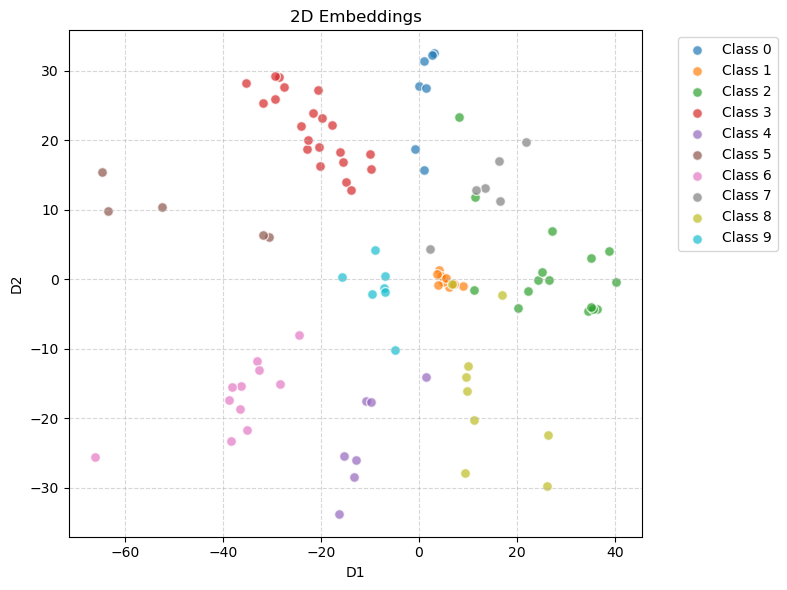

In [124]:
plot_embeddings_2d(x,y)

## Plotting ME model

In [125]:
x, y =sample_from_mnist(model,test_data,100,dim=2)

C:\Users\David S\AppData\Local\Temp\ipykernel_16408\1399908285.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))  # Use a colormap with enough colors


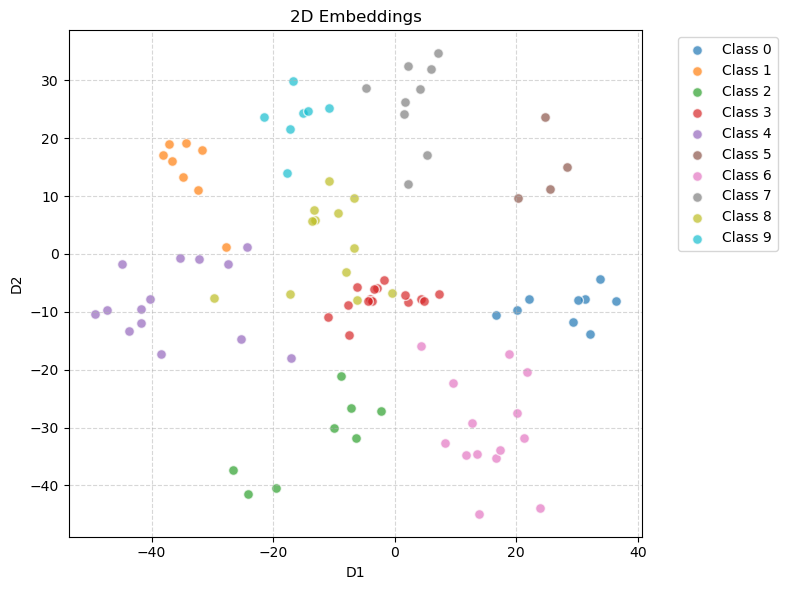

In [126]:
plot_embeddings_2d(x,y)